# DSAIT4335 Recommender Systems
# Final Project

In this project, you will work to build different recommendation models and evaluate the effectiveness of these models through offline experiments. The dataset used for the experiments is **MovieLens100K**, a movie recommendation dataset collected by GroupLens: https://grouplens.org/datasets/movielens/100k/. For more details, check the project description on Brightspace.

# Instruction

The MovieLens100K is already splitted into 80% training and 20% test sets. Along with training and test sets, movies metadata as content information is also provided.

**Expected file structure** for this assignment:   
   
   ```
   RecSysProject/
   ├── training.txt
   ├── test.txt
   ├── movies.txt
   └── codes.ipynb
   ```

**Note:** Be sure to run all cells in each section sequentially, so that intermediate variables and packages are properly carried over to subsequent cells.

**Note** Be sure to run all cells such that the submitted file contains the output of each cell.

**Note** Feel free to add cells if you need more for answering a question.

**Submission:** Answer all the questions in this jupyter-notebook file. Submit this jupyter-notebook file (your answers included) to Brightspace. Change the name of this jupyter-notebook file to your group number: example, group10 -> 10.ipynb.

# Setup

## Project Overview

This project aims to design, implement, and evaluate a series of recommender system models. We will explore five main approaches:
1.  **Content-Based (CB):** Recommending items based on their feature similarity.
2.  **User-Based KNN (UserKNN):** Recommending items liked by similar users.
3.  **Item-Based KNN (ItemKNN):** Recommending items similar to those a user has liked.
4.  **Matrix Factorization (MF):** A latent factor model for rating prediction.
5.  **Bayesian Personalized Ranking (BPR):** A latent factor model optimized for ranking.

We will conduct a baseline comparison against simple models and evaluate all approaches on two tasks: **Rating Prediction (using RMSE)** and **Ranking Prediction (using Precision, Recall, and NDCG)**.

Finally, we will combine these models into a **Hybrid Recommender** and conduct a strong analytical reasoning analysis of their performance, including beyond-accuracy metrics like diversity, novelty, and fairness, to provide a deep and original discussion of their strengths and limitations.

In [2]:
!pip install -q transformers torch  # For BERT
!pip install numpy pandas matplotlib seaborn scipy scikit-learn torch tqdm
!pip install torch-directml

# you can refer https://huggingface.co/docs/transformers/en/model_doc/bert for various versions of the pre-trained model BERT

ERROR: Could not find a version that satisfies the requirement torch-directml (from versions: none)
ERROR: No matching distribution found for torch-directml


In [2]:
# For BERT embeddings (install: pip install transformers torch)
print("Check the status of BERT installation:")

try:
    from transformers import AutoTokenizer, AutoModel
    import torch

    BERT_AVAILABLE = True
    directml_available = False
    device = None

    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        # Try DirectML (Windows / AMD) if installed
        try:
            import torch_directml
            dml_device = torch_directml.device()
            for i in range(torch_directml.device_count()):
                print(f"  Device {i}: {torch_directml.device_name(i)}")
            device = dml_device
            directml_available = True
        except Exception:
            # Try Apple MPS
            if getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available():
                device = torch.device("mps")
            else:
                # Fallback to CPU
                device = torch.device("cpu")

    print("BERT libraries loaded successfully!")
    # device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
    print("torch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available(), " CUDA devices:", torch.cuda.device_count() if torch.cuda.is_available() else 0)
    print("MPS available:", getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available())
    print("DirectML available:", directml_available)
    print("Using device:", device)
except ImportError:
    BERT_AVAILABLE = False
    import torch
    device = torch.device("cpu")
    directml_available = False
    print("BERT libraries not available. Install with: pip install transformers torch")
    print("Using device:", device)

Check the status of BERT installation:
BERT libraries loaded successfully!
torch version: 2.5.1
CUDA available: False  CUDA devices: 0
MPS available: False
DirectML available: False
Using device: cpu


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine, correlation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import re
import time, math
from tqdm import tqdm
import random
import itertools
import json
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


### Here we set the random seed to 10 in order to ensure reproducibility of the experiments.

In [4]:
SEED = 10

# Python built-in random seed
random.seed(SEED)

# Numpy random seed
np.random.seed(SEED)

# PyTorch random seed (CPU)
torch.manual_seed(SEED)

# PyTorch random seed (GPU, if available)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  

In [5]:
# Compatibility for older numpy version
try:
    import numpy.core.numeric
    import sys
    sys.modules['numpy._core.numeric'] = numpy.core.numeric
except ImportError:
    pass

## Mount Data Folder

In [6]:
import os

# Use current directory as project root
PROJECT_PATH = os.getcwd()  # e.g. /Users/yourname/Documents/Project-RecSys
OUTPUTS_PATH = os.path.join(PROJECT_PATH, "data")

# Make sure 'data' folder exists
os.makedirs(OUTPUTS_PATH, exist_ok=True)

print("Project Path:", PROJECT_PATH)
print("Data Path:", OUTPUTS_PATH)

Project Path: /mnt/e/section-1/ImportantFile/TU Delft/courses/q5/DSAIT4335-Recommender-Systems/assignments/Recommender-Systems-Project
Data Path: /mnt/e/section-1/ImportantFile/TU Delft/courses/q5/DSAIT4335-Recommender-Systems/assignments/Recommender-Systems-Project/data


In [7]:
%cd $PROJECT_PATH

/mnt/e/section-1/ImportantFile/TU Delft/courses/q5/DSAIT4335-Recommender-Systems/assignments/Recommender-Systems-Project


# Load dataset

In [8]:
# loading the training set and test set
columns_name=['user_id','item_id','rating','timestamp']
train_data = pd.read_csv(f'{PROJECT_PATH}/training.txt', sep='\t', names=columns_name)
test_data = pd.read_csv(f'{PROJECT_PATH}/test.txt', sep='\t', names=columns_name)

# We take 20% of the original training set as validation
train_data, val_data = train_test_split(
    train_data,
    test_size=0.2,  
    random_state=SEED, 
    shuffle=True, 
)

print(f'The training data:')
display(train_data[['user_id','item_id','rating']].head())
print(f'The shape of the training data: {train_data.shape}')
print('--------------------------------')
print(f'The validation data:')
display(val_data[['user_id','item_id','rating']].head())
print(f'The shape of the validation data: {val_data.shape}')
print('--------------------------------')
print(f'The test data:')
display(test_data[['user_id','item_id','rating']].head())
print(f'The shape of the test data: {test_data.shape}')

The training data:


,user_id,item_id,rating
30548,450,482,5
60209,747,179,5
60230,747,211,5
62326,766,176,2
13422,251,429,4


The shape of the training data: (64000, 4)
--------------------------------
The validation data:


,user_id,item_id,rating
43012,561,23,5
7447,131,536,5
79413,936,1199,4
13011,244,249,4
60268,747,357,5


The shape of the validation data: (16000, 4)
--------------------------------
The test data:


,user_id,item_id,rating
0,1,6,5
1,1,10,3
2,1,12,5
3,1,14,5
4,1,17,3


The shape of the test data: (20000, 4)


In [9]:
movies = pd.read_csv(f'{PROJECT_PATH}/movies.txt',names=['item_id','title','genres','description'],sep='\t')
movies.head()

,item_id,title,genres,description
0,1,Toy Story (1995),"Animation, Children's, Comedy","A group of sentient toys, who pretend to be li..."
1,2,GoldenEye (1995),"Action, Adventure, Thriller","In 1986, MI6 agents James Bond and Alec Trevel..."
2,3,Four Rooms (1995),Thriller,"On New Year's Eve, bellhop Sam (Marc Lawrence)..."
3,4,Get Shorty (1995),"Action, Comedy, Drama",Chili Palmer is a Miami-based loan shark and m...
4,5,Copycat (1995),"Crime, Drama, Thriller",After giving a guest lecture on criminal psych...


In [10]:
num_users = train_data['user_id'].max()
num_items = train_data['item_id'].max()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Number of users: {num_users}, Number of items: {num_items}, Using device: {device}')

Number of users: 943, Number of items: 1682, Using device: cpu


# Helper Functions

In [11]:
# Create embeddings of the movie items
def create_bert_embeddings(content):
    """
    Generate BERT embeddings for movie content.

    Args:
        content: Content of items

    Returns:
        numpy.ndarray: BERT embeddings matrix
    """
    if not BERT_AVAILABLE:
        print("BERT libraries not available. Install with: pip install transformers torch")
        return None

    if content is None:
        return None

    if isinstance(content, pd.Series):
        content = content.fillna("").astype(str).tolist()
    elif isinstance(content, np.ndarray):
        content = content.astype(str).tolist()

    model_name = 'distilbert-base-uncased'

    print(f"Loading BERT model: {model_name}")

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # Set device (GPU if available)
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using: {device}")
    model.to(device)
    model.eval()

    print(f"Using device: {device}")

    # Generate embeddings in batches
    batch_size = 32  # Adjust based on available memory
    emb = []

    for i in range(0, len(content), batch_size):
        if i % (batch_size * 10) == 0:
            print(f"Processing batch {i//batch_size + 1}/{len(content)//batch_size + 1}")

        batch_texts = content[i:i + batch_size]

        # Tokenize batch
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        )

        # Move to device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)

            # Use [CLS] token embedding (first token)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            emb.extend(batch_embeddings)

    emb = np.array(emb)

    print(f"BERT embeddings generated: {emb.shape}")
    print(f"Embedding dimension: {emb.shape[1]}")

    return emb

## Get the item embeddings and then save them to local folder



In [12]:
# Three diffrent content representation (title + genre, description, title + genre + description)

import os
# Create a subfolder for saved outputs to avoid performing expensive computations multiple times
os.makedirs(OUTPUTS_PATH, exist_ok=True)

# Define the file paths for each of the three embedding arrays
path_titlegenres = os.path.join(OUTPUTS_PATH, "item_emb_titlegenres.npy")
path_description = os.path.join(OUTPUTS_PATH, "item_emb_description.npy")
path_full = os.path.join(OUTPUTS_PATH, "item_emb_full.npy")

if os.path.exists(path_titlegenres):
    print(f"Loading Title+Genres embeddings from: {path_titlegenres} 💾")
    item_emb_titlegenres = np.load(path_titlegenres)
    print("✅ Loaded successfully!")
else:
    print("Computing Title+Genres embeddings... ⏳")
    title_genres = movies["title"] + ' ' + movies["genres"]
    item_emb_titlegenres = create_bert_embeddings(title_genres)
    np.save(path_titlegenres, item_emb_titlegenres)
    print(f"✅ Computed and saved to shared drive for future use!")

if os.path.exists(path_description):
    print(f"\nLoading Description embeddings from: {path_description} 💾")
    item_emb_description = np.load(path_description)
    print("✅ Loaded successfully!")
else:
    print("\nComputing Description embeddings... ⏳")
    item_emb_description = create_bert_embeddings(movies["description"])
    np.save(path_description, item_emb_description)
    print(f"✅ Computed and saved to shared drive for future use!")

if os.path.exists(path_full):
    print(f"\nLoading Full Content embeddings from: {path_full} 💾")
    item_emb_full = np.load(path_full)
    print("✅ Loaded successfully!")
else:
    print("\nComputing Full Content embeddings... ⏳")
    title_genres_description = movies["title"] + ' ' + movies["genres"] + ' ' + movies["description"]
    item_emb_full = create_bert_embeddings(title_genres_description)
    np.save(path_full, item_emb_full)
    print(f"✅ Computed and saved to shared drive for future use!")

print("\n--- Final Embedding Shapes ---")
print(f"Title+Genres: {item_emb_titlegenres.shape}")
print(f"Description:  {item_emb_description.shape}")
print(f"Full Content: {item_emb_full.shape}")

Loading Title+Genres embeddings from: /mnt/e/section-1/ImportantFile/TU Delft/courses/q5/DSAIT4335-Recommender-Systems/assignments/Recommender-Systems-Project/data/item_emb_titlegenres.npy 💾
✅ Loaded successfully!

Loading Description embeddings from: /mnt/e/section-1/ImportantFile/TU Delft/courses/q5/DSAIT4335-Recommender-Systems/assignments/Recommender-Systems-Project/data/item_emb_description.npy 💾
✅ Loaded successfully!

Loading Full Content embeddings from: /mnt/e/section-1/ImportantFile/TU Delft/courses/q5/DSAIT4335-Recommender-Systems/assignments/Recommender-Systems-Project/data/item_emb_full.npy 💾
✅ Loaded successfully!

--- Final Embedding Shapes ---
Title+Genres: (1682, 768)
Description:  (1682, 768)
Full Content: (1682, 768)


In [13]:
# Get item embedding based on item ID (item id starts at 1)
def get_item_emb(item_id, content_type):
    emb = None

    if content_type == "title_genres":
        emb = item_emb_titlegenres[item_id - 1]
    elif content_type == "description":
        emb = item_emb_description[item_id - 1]
    elif content_type == "full":
        emb = item_emb_full[item_id - 1]

    return emb

In [14]:
# Given content type (title+genres, description, or title+genres+description) returns the embeddings and ratings of interacted items by user_id
def get_interacted_items_embs_rating(train_data, user_id, content_type):
    embs, ratings = [], []

    # use train_data to retrieve the item_ids that target user interacted
    items_and_ratings = train_data[train_data["user_id"] == user_id][['item_id', 'rating']]
    item_ids = items_and_ratings['item_id']
    ratings = items_and_ratings['rating'].tolist()

    indices = [i - 1 for i in item_ids]

    if content_type == "title_genres":
        embs = item_emb_titlegenres[indices]
    elif content_type == "description":
        embs = item_emb_description[indices]
    elif content_type == "full":
        embs = item_emb_full[indices]

    return embs, ratings

# given content type (title+genres, description, or title+genres+description) and aggregation method (avg, weighted_avg, avg_pos) returns the representation of a user.
def get_user_emb(train_data, user_id, content_type, aggregation_method):

    emb = []

    # obtain item embeddings and corresponding ratings of the items that the user has interacted with
    item_embs, ratings = get_interacted_items_embs_rating(
        train_data, user_id, content_type
    )

    interacted_ratings = np.array(ratings)

    if aggregation_method == 'avg':
        emb = np.mean(item_embs, axis=0)

    elif aggregation_method == 'weighted_avg':
        emb = np.average(item_embs, axis=0, weights=interacted_ratings)

    elif aggregation_method == 'avg_pos':
        ratings = np.array(ratings)

        # Filter for only positively rated items above 4
        positive_mask = ratings >= 4
        positive_embs = item_embs[positive_mask]

        if len(positive_embs) > 0:
            emb = np.mean(positive_embs, axis=0)
        else:
            emb = np.zeros(item_embs.shape[1])

    return emb

In [15]:
def RMSE(actual_rating, pred_rating):
    return np.mean((np.array(pred_rating) - np.array(actual_rating))**2)**(1/2)

# Task 1) Implementation of different recommendation models as well as a hybrid model combining those recommendation models

In [16]:
# device = 'cuda' if torch.cuda.is_available() else 'mps'
print(f'Using device: {device}')

Using device: cpu


## 1.1 Content Based Recommendation model


### 1.1.1 Design Justification

**Model Choice (BERT):** BERT (`distilbert-base-uncased`) is selected over simpler methods like TF-IDF to create item embeddings. While TF-IDF captures keyword frequency, BERT is a pre-trained language model that understands semantic context. This allows it to generate richer, more nuanced embeddings. For example, it can understand that 'a film about space' is similar to 'a movie about astronauts,' even if the keywords don't match.

**Aggregation Methods:** To create a user profile from their interacted items, we test three aggregations, which constitutes a diverse set of experiments:
* **`avg`:** A simple average, treating all rated items equally.
* **`weighted_avg`:** This method weights items by their rating. The hypothesis is that items a user rated highly (e.g., 5 stars) are more representative of their true preferences than items they rated poorly (e.g., 1 star).
* **`avg_pos`:** This is a variant of `avg` that only considers items with positive ratings (>= 4). This tests the hypothesis that a user's profile should be defined *only* by what they like, not by what they dislike.

In [17]:
# compute the predicted rating for a user-item pair
def get_user_item_prediction_content_based(train_data, user_id, item_id, content_type, aggregation_method):
    pred_rating = 0.0

    user_embedding = get_user_emb(train_data, user_id, content_type, aggregation_method)
    item_embedding = get_item_emb(item_id, content_type)

    pred_rating = np.dot(user_embedding, item_embedding)

    return pred_rating

In [18]:
user_id, item_id = 100, 266
content_type, aggregation_method = 'full', 'avg' # alternatives are content_type={title_genres,description,full} and aggregation_method={avg,weighted_avg,avg_pos}
print('Predicted score for user_id=100 and item_id=266 for content type '+content_type+' and aggregation method '+aggregation_method+':')
print(get_user_item_prediction_content_based(train_data, user_id, item_id, content_type, aggregation_method))

Predicted score for user_id=100 and item_id=266 for content type full and aggregation method avg:
143.18022


### Function that generates top-k recommendation list for a target user with user-based recommendataion

In [19]:
def recommend_topk_content_based(train_data, target_user, k, content_type, aggregation_method):
    """
    Generate Top-K recommendations for a target user using Content-based CF.

    Args:
        train_data (pd.DataFrame): ratings data with columns [user_id, item_id, rating]
        target_user (int): user_id of the target user
        k (int): number of items to recommend
        content_type (str): type of content representation ('title_genres', 'description', 'full')
        aggregation_method (str): method to aggregate user embeddings ('avg', 'weighted_avg', 'avg_pos')

    Returns:
        list of (item_id, predicted_score) sorted by score desc
    """
    result = []

    user_rated_items = set(train_data[train_data["user_id"] == target_user]["item_id"])
    all_items = set(train_data["item_id"].unique())
    candidate_items = all_items - user_rated_items

    predictions = []
    for item_id in candidate_items:
        pred_rating = get_user_item_prediction_content_based(
            train_data,
            target_user,
            item_id,
            content_type,
            aggregation_method
        )
        if not np.isnan(pred_rating):  
            predictions.append((item_id, pred_rating))

    ratings = [r for _, r in predictions]
    min_rating, max_rating = min(ratings), max(ratings)

    # print(f"Min predicted rating: {min_rating}, Max predicted rating: {max_rating}")
    # print(predictions[:5])

    if max_rating == min_rating:
        mapped_ratings = [(3.0, i) for i, _ in predictions]
    else:
        mapped_ratings = [
            (
                i,
                1 + (r - min_rating) * 4 / (max_rating - min_rating),
            )
            for i, r in predictions
        ]

    result = sorted(mapped_ratings, key=lambda x: x[1], reverse=True)[:k]

    return result


target_user, k = 1, 50
recommendations = recommend_topk_content_based(train_data, target_user, k, content_type="full", aggregation_method="weighted_avg")
print(
    f"Top-{k} recommendations for user {target_user} with content-based recommendation:"
)
for item, score in recommendations:
    print(f"Item {item}: {score:.4f}")

Top-50 recommendations for user 1 with content-based recommendation:
Item 1640: 5.0000
Item 1573: 4.9456
Item 1423: 4.9108
Item 1397: 4.9056
Item 1103: 4.8623
Item 1208: 4.8320
Item 403: 4.7619
Item 387: 4.7597
Item 715: 4.7546
Item 1250: 4.7451
Item 385: 4.7150
Item 56: 4.7141
Item 724: 4.7095
Item 781: 4.7066
Item 147: 4.6818
Item 637: 4.6715
Item 916: 4.6684
Item 381: 4.6578
Item 345: 4.6530
Item 1110: 4.6482
Item 450: 4.6460
Item 398: 4.6308
Item 1048: 4.6285
Item 396: 4.6223
Item 1210: 4.6199
Item 893: 4.6151
Item 328: 4.6093
Item 974: 4.6090
Item 405: 4.6011
Item 631: 4.6004
Item 1605: 4.5987
Item 229: 4.5976
Item 228: 4.5894
Item 317: 4.5888
Item 424: 4.5875
Item 771: 4.5612
Item 406: 4.5578
Item 791: 4.5561
Item 803: 4.5549
Item 375: 4.5532
Item 429: 4.5523
Item 507: 4.5511
Item 298: 4.5502
Item 691: 4.5285
Item 751: 4.5280
Item 800: 4.5279
Item 386: 4.5265
Item 327: 4.5254
Item 264: 4.5234
Item 1277: 4.5213


### Computing RMSE of the content-based recommendation model


In [20]:
def evaluate_rating_prediction_content_based(train_data, test_data, content_type, aggregation_method):
    # Create a mapping from user_id to user embedding
    users_emb = {}
    users = list(train_data['user_id'].unique())
    for user in tqdm(users, desc="Creating user embedding mapping"):
        users_emb[user] = get_user_emb(train_data, user, content_type, aggregation_method)


    # I do the same for items
    items = list(train_data['item_id'].unique())
    items_emb = {}
    for item in tqdm(items, desc="Creating item embedding mapping"):
        items_emb[item] = get_item_emb(item, content_type)

    actual_ratings, pred_ratings = [], []

    global_mean_rating = train_data['rating'].mean()

    for index, test_row in tqdm(test_data.iterrows(), total=len(test_data), desc="Processing test data"):
        user_id = test_row["user_id"]
        item_id = test_row["item_id"]

        user_embedding = users_emb.get(user_id)
        item_embedding = items_emb.get(item_id)

        if user_embedding is None or item_embedding is None:
            # Impute the global average rating if we can't predict
            pred_rating = global_mean_rating
        else:
            # Only calculate dot product if we have both embeddings
            pred_rating = np.dot(user_embedding, item_embedding)

        actual_ratings.append(test_row['rating'])
        pred_ratings.append(pred_rating)

    # Given predicted ratings, map them into [1,5] interval using -> 1 + (pred - min_val) * (4 / (max_val - min_val))

    min_rating = min(pred_ratings)
    max_rating = max(pred_ratings)

    mapped_ratings = [1 + (rating - min_rating) * 4 / (max_rating - min_rating) for rating in pred_ratings]


    mae_value, mse_value, rmse_value = 0.0, 0.0, 0.0


    # compute the metrics: MAE, MSE, RMSE
    # mae_value = MAE(actual_ratings, mapped_ratings)
    # mse_value = MSE(actual_ratings, mapped_ratings)
    rmse_value = RMSE(actual_ratings, mapped_ratings)

    return rmse_value

### Use the RMSE loss to find out which combination of content representation and aggregation method works the best for content-recommendation


In [21]:
def hyperparameter_search_content_based(train_data, val_data, content_types, aggregation_methods):
    """
    Perform hyperparameter tuning for content based recommendation. It finds the best combination
    of content representations and aggregation methods

    Args:
        train_data (pd.DataFrame): training set with columns ['user_id', 'item_id', 'rating']
        val_data (pd.DataFrame): validation set with columns ['user_id', 'item_id', 'rating']
        content_types: content types list (title_genres, description, full)
        aggregation_methods: avg, weighted_avg, avg_pos

    Returns:
        dict: {'best_config': (best_content_type, best_aggregation_method), 'best_rmse': float, 'results': list of tuples (k, rmse)}
    """

    print("\n=== Content Based Recommendation Hyperparameter Search ===")
    results = []

    for content_type in content_types:
        for agg_method in aggregation_methods:
          print(f"starting with {content_type} and {agg_method}")
          rmse = evaluate_rating_prediction_content_based(
              train_data,
              val_data,
              content_type,
              agg_method
          )

          results.append({
              'content_type': content_type,
              'aggregation_method': agg_method,
              'RMSE': rmse
          })
          print(f"Config: ({content_type}, {agg_method}) -> RMSE = {rmse:.4f}")

    # Get the best performing combinations as the result of this hyperparameter tuning
    best_result = min(results, key=lambda x: x['RMSE'])
    best_config = (best_result['content_type'], best_result['aggregation_method'])
    best_rmse = best_result['RMSE']

    print(f"Best result was achieved by the config: {best_config}")

    return {
        'best_config': best_config,
        'best_rmse': best_rmse,
        'results': results
    }

In [22]:
import pickle

# Define parameter space
content_types_grid = ['title_genres', 'description', 'full']
aggregation_methods_grid = ['avg', 'weighted_avg', 'avg_pos']

path_content_based_tuning = os.path.join(OUTPUTS_PATH, 'content_based_tuning_results.pkl')

# Run the search or load results
if os.path.exists(path_content_based_tuning):
    print(f"Loading Content-based tuning results from: {path_content_based_tuning} 💾")
    with open(path_content_based_tuning, 'rb') as f:
        content_based_tuning = pickle.load(f)
    print("✅ Loaded successfully!")
else:
    print("Running Content-based hyperparameter search... ⏳")

    content_based_tuning = hyperparameter_search_content_based(
        train_data,
        val_data,
        content_types_grid,
        aggregation_methods_grid
    )

    # Save the results
    with open(path_content_based_tuning, 'wb') as f:
        pickle.dump(content_based_tuning, f)
    print(f"✅ Saved Content-based tuning results to {path_content_based_tuning}")

print("\n--- Content-Based Tuning Results ---")
print(f"Best Config: {content_based_tuning['best_config']}")
print(f"Best Validation RMSE: {content_based_tuning['best_rmse']:.4f}")

rmse_content_based = content_based_tuning['best_rmse']
best_content_type_cb, best_aggregation_method_cb = content_based_tuning["best_config"]

Loading Content-based tuning results from: /mnt/e/section-1/ImportantFile/TU Delft/courses/q5/DSAIT4335-Recommender-Systems/assignments/Recommender-Systems-Project/data/content_based_tuning_results.pkl 💾
✅ Loaded successfully!

--- Content-Based Tuning Results ---
Best Config: ('full', 'weighted_avg')
Best Validation RMSE: 1.4700


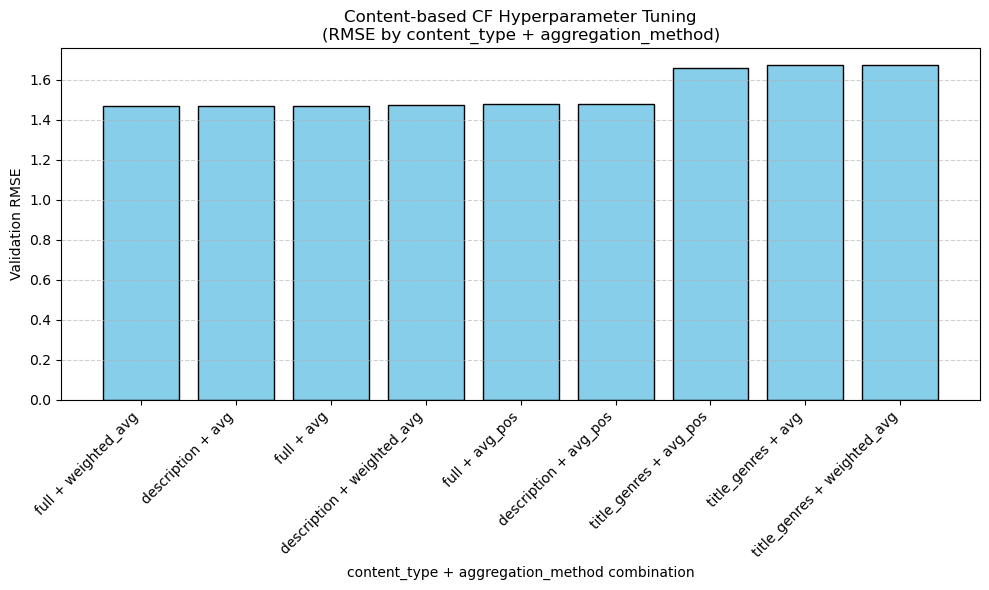

In [23]:
# Visualize Content based recommendation hyperparameter tuning results

results_df = pd.DataFrame(content_based_tuning['results'], columns=['content_type', "aggregation_method", 'RMSE'])
results_df["cobination"] = results_df["content_type"] + " + " + results_df["aggregation_method"]
results_df = results_df.sort_values('RMSE')

plt.figure(figsize=(10, 6))
plt.bar(results_df['cobination'], results_df['RMSE'], color='skyblue', edgecolor='black')

plt.title("Content-based CF Hyperparameter Tuning\n(RMSE by content_type + aggregation_method)", fontsize=12)
plt.xlabel("content_type + aggregation_method combination", fontsize=10)
plt.ylabel("Validation RMSE", fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


## 1.2 User-based neighborhood method (UserKNN)

The **Pearson correlation coefficient** between two users \(x\) and \(y\) is defined as:

$$
r_{xy} = \frac{\sum_{i \in I_{xy}} (x_i - \bar{x})(y_i - \bar{y})}
              {\sqrt{\sum_{i \in I_{xy}} (x_i - \bar{x})^2} \cdot \sqrt{\sum_{i \in I_{xy}} (y_i - \bar{y})^2}}
$$

**Where:**

- $I_{xy}$ = set of items rated by both users  
- $x_i$, $y_i$ = ratings of users \(x\) and \(y\) on item \(i\)  
- $\bar{x}$, $\bar{y}$ = mean ratings of users \(x\) and \(y\) on the common items
-
### 1.2.1 Design Justification

**Similarity Metric (Pearson Correlation):** We chose the Pearson correlation coefficient to measure user-user similarity. Unlike basic cosine similarity, Pearson correlation is *mean-centered*. This is an important advantage here because different users rate on different scales (e.g., one user's "3" is another's "4"). By centering the ratings around each user's mean, Pearson captures the similarity in *rating patterns* (how users deviate from their own average) rather than being skewed by their baseline "generosity" or "strictness" in rating.



In [24]:
# define pearson correlation to obtain users similarity
def pearson_correlation(user1_ratings: pd.Series, user2_ratings: pd.Series) -> float:
    # only consider items that have been rated by both users
    common_items = user1_ratings.dropna().index.intersection(user2_ratings.dropna().index)

    if len(common_items) < 2:
        return 0

    u1_ratings = user1_ratings.loc[common_items]
    u2_ratings = user2_ratings.loc[common_items]

    u1_mean = u1_ratings.mean()
    u2_mean = u2_ratings.mean()

    numerator = ((u1_ratings - u1_mean) * (u2_ratings - u2_mean)).sum()
    denominator = np.sqrt(((u1_ratings - u1_mean) ** 2).sum()) * np.sqrt(((u2_ratings - u2_mean) ** 2).sum())

    if denominator == 0:
        return 0.0

    result = numerator / denominator

    if not np.isfinite(result):
        return 0.0

    return result

# compute similarity matrix of size len(users), len(users).
def compute_user_similarity_matrix(train_data: pd.DataFrame) -> pd.DataFrame:
    users = train_data['user_id'].unique()
    user_similarity_matrix = pd.DataFrame(np.zeros((len(users), len(users))), index=users, columns=users)

    for i, usera in enumerate(users):
        for j, userb in enumerate(users):
            if i > j:
                continue
            if usera == userb:
                user_similarity_matrix.loc[usera, userb] = 1
            else:
                sim = pearson_correlation(train_data[train_data["user_id"] == usera].set_index("item_id")["rating"], train_data[train_data["user_id"] == userb].set_index("item_id")["rating"])
                user_similarity_matrix.loc[usera, userb] = sim
                user_similarity_matrix.loc[userb, usera] = sim

    return user_similarity_matrix

# Get top-k most similar users to the target user and return List of tuples: [(neighbor_user_id, similarity), ...] sorted by similarity descending
def get_k_user_neighbors(train_data, user_similarity_matrix: pd.DataFrame, target_user, target_item, k=5):
    top_k_neighbors = []

    # we want to select top k neighbours who have rated the target item
    rated_users = train_data.loc[train_data['item_id'] == target_item, 'user_id'].unique()

    user_similarities = user_similarity_matrix.loc[target_user].drop(target_user)
    # Only keep users who have rated the target item
    user_similarities = user_similarities.loc[user_similarities.index.isin(rated_users)]
    top_k_neighbors = list(user_similarities.nlargest(k).items())

    return top_k_neighbors

In [25]:
path_user_similarity_matrix = os.path.join(OUTPUTS_PATH, "user_similarity_matrix.pkl")

if os.path.exists(path_user_similarity_matrix):
    print(f"Loading user similarity matrix from: {path_user_similarity_matrix} 💾")
    user_similarity_matrix = pd.read_pickle(path_user_similarity_matrix)
    print("✅ Loaded successfully!")
else:
    print("Computing user similarity matrix... ⏳")
    user_similarity_matrix = compute_user_similarity_matrix(train_data)
    user_similarity_matrix.to_pickle(path_user_similarity_matrix)
    print(f"✅ Computed and saved to shared drive for future use!")

# Verify the index
print(f"User similarity matrix shape: {user_similarity_matrix.shape}")
print(f"Is user 943 in user_similarity_matrix index after loading/computing: {943 in user_similarity_matrix.index}")

Loading user similarity matrix from: /mnt/e/section-1/ImportantFile/TU Delft/courses/q5/DSAIT4335-Recommender-Systems/assignments/Recommender-Systems-Project/data/user_similarity_matrix.pkl 💾
✅ Loaded successfully!
User similarity matrix shape: (943, 943)
Is user 943 in user_similarity_matrix index after loading/computing: True


In [26]:
def predict_rating_user_based(
    train_data: pd.DataFrame,
    user_similarity_matrix: pd.DataFrame,
    target_user,
    target_item,
    global_mean_rating, k=5,
):
    """
    Predict rating for target_user and target_item using mean-centered user-based CF.

    Parameters:
    - ratings: pd.DataFrame with columns ['user_id', 'item_id', 'rating']
    - user_similarity_matrix: pd.DataFrame of user-user similarities
    - target_user: user ID
    - target_item: item ID
    - global_mean_rating: global mean rating to use as fallback
    - k: number of neighbors to consider

    Returns:
    - float: predicted rating, or np.nan if not possible
    """
    result = 0.0

    ############# Your code here ############
    user_ratings = train_data[train_data["user_id"] == target_user].set_index("item_id")["rating"]
    item_ratings = train_data[train_data["item_id"] == target_item].set_index("user_id")["rating"]

    user_mean = user_ratings.mean()

    # if user has no rating, fall back to global mean rating
    if pd.isna(user_mean):
        user_mean = global_mean_rating

    # gets top k neighbors who rated the target item
    top_k_neighbors = get_k_user_neighbors(train_data, user_similarity_matrix, target_user, target_item, k)

    # If no neighbors, return user mean
    if not top_k_neighbors:
        return user_mean

    neighbor_ids = [n_id for n_id, similarity in top_k_neighbors]
    neighbour_id_to_mean_rating = train_data[train_data["user_id"].isin(neighbor_ids)].groupby('user_id')['rating'].mean()

    numerator = 0.0
    denominator = 0.0

    for neighbour_id, similarity in top_k_neighbors:
        if neighbour_id in item_ratings.index:
            numerator += similarity * (item_ratings.loc[neighbour_id] - neighbour_id_to_mean_rating[neighbour_id])
            denominator += abs(similarity)

    if denominator == 0:
        return user_mean 

    result = user_mean + (numerator/denominator)

    result = np.clip(result, 1, 5)

    #########################################

    return result

In [27]:
target_user, target_item, k = 1, 17, 50
global_mean_rating = train_data["rating"].mean()
print(
    f"The actual rating for user {target_user} and item {target_item} is 3. The predicted rating by user-based CF for user {target_user} and item {target_item} is {predict_rating_user_based(train_data, user_similarity_matrix, target_user, target_item, global_mean_rating, k):.4f}"
)

The actual rating for user 1 and item 17 is 3. The predicted rating by user-based CF for user 1 and item 17 is 3.3509


### Function that generates top-k recommendation list for a target user with user-based recommendataion

In [28]:
def recommend_topk_user_based(train_data, user_similarity_matrix, target_user, k_user, k=5):
    """
    Generate Top-K recommendations for a target user using User-based CF.

    Args:
        train_data (pd.DataFrame): ratings data with columns [user_id, item_id, rating]
        user_similarity_matrix (pd.DataFrame): precomputed user-user similarity matrix
        target_user (int): user_id of the target user
        k (int): number of items to recommend

    Returns:
        list of (item_id, predicted_score) sorted by score desc
    """
    result = []

    user_rated_items = set(train_data[train_data["user_id"] == target_user]["item_id"])
    all_items = set(train_data["item_id"].unique())
    candidate_items = all_items - user_rated_items

    predictions = []
    for item_id in candidate_items:
        pred_rating = predict_rating_user_based(
            train_data,
            user_similarity_matrix,
            target_user,
            item_id,
            global_mean_rating,
            k_user,
        )
        if not np.isnan(pred_rating):  # only keep valid predictions
            predictions.append((item_id, pred_rating))

    result = sorted(predictions, key=lambda x: x[1], reverse=True)[:k]

    return result


target_user, k_user, k = 1, 50, 50
recommendations = recommend_topk_user_based(
    train_data, user_similarity_matrix, target_user, k_user, k
)
print(f"Top-{k} recommendations for user {target_user} with user-based recommendation:")
for item, score in recommendations:
    print(f"Item {item}: {score:.4f}")

Top-50 recommendations for user 1 with user-based recommendation:
Item 74: 5.0000
Item 891: 5.0000
Item 1233: 5.0000
Item 1467: 5.0000
Item 1599: 5.0000
Item 1618: 5.0000
Item 1293: 4.9983
Item 1368: 4.9329
Item 851: 4.8699
Item 1442: 4.8647
Item 1662: 4.8641
Item 1673: 4.8269
Item 1629: 4.8244
Item 1038: 4.8119
Item 1167: 4.8031
Item 1414: 4.7698
Item 1642: 4.7602
Item 1144: 4.7600
Item 1607: 4.7481
Item 793: 4.7234
Item 1631: 4.7051
Item 1645: 4.7051
Item 1650: 4.7051
Item 1656: 4.6965
Item 1512: 4.6906
Item 1449: 4.6672
Item 1367: 4.6660
Item 1189: 4.6474
Item 408: 4.6468
Item 1424: 4.6459
Item 1643: 4.6428
Item 909: 4.6152
Item 483: 4.6146
Item 957: 4.6018
Item 1624: 4.5918
Item 677: 4.5787
Item 360: 4.5726
Item 64: 4.5596
Item 868: 4.5571
Item 1338: 4.5406
Item 1452: 4.5360
Item 272: 4.5343
Item 918: 4.5280
Item 285: 4.5256
Item 12: 4.5209
Item 1122: 4.5181
Item 1256: 4.5103
Item 318: 4.4989
Item 1255: 4.4821
Item 1664: 4.4794


### Computing RMSE of the User based KNN recommendation model



In [29]:
def evaluate_rating_prediction_user_based(train_data, test_data, user_similarity_matrix, k):
    actual_ratings, pred_ratings = [], []
    global_mean_rating = train_data["rating"].mean()


    for index, test_row in tqdm(test_data.iterrows(), total=len(test_data), desc="Processing test data"):
        user_id = test_row["user_id"]
        item_id = test_row["item_id"]

        pred_rating = predict_rating_user_based(train_data, user_similarity_matrix, user_id, item_id, global_mean_rating, k)

        if not np.isnan(pred_rating):
            actual_ratings.append(test_row['rating'])
            pred_ratings.append(pred_rating)

    # Given predicted ratings, map them into [1,5] interval using -> 1 + (pred - min_val) * (4 / (max_val - min_val))

    min_rating = min(pred_ratings)
    max_rating = max(pred_ratings)

    if max_rating == min_rating:
        min_rating = max_rating - 0.001

    mapped_ratings = [1 + (rating - min_rating) * 4 / (max_rating - min_rating) for rating in pred_ratings]

    mae_value, mse_value, rmse_value = 0.0, 0.0, 0.0

    # compute the metrics: MAE, MSE, RMSE
    # mae_value = MAE(actual_ratings, mapped_ratings)
    # mse_value = MSE(actual_ratings, mapped_ratings)
    rmse_value = RMSE(actual_ratings, mapped_ratings)

    return rmse_value

### Use the RMSE loss to find out which combination of content representation and aggregation method works the best for content-recommendation




In [30]:
def hyperparameter_search_user_based(train_data, val_data, user_similarity_matrix, ks):
    """
    Perform hyperparameter tuning for user KNN based recommendation. It finds the best k value

    Args:
        train_data (pd.DataFrame): training set with columns ['user_id', 'item_id', 'rating']
        val_data (pd.DataFrame): validation set with columns ['user_id', 'item_id', 'rating']
        user_similarity_matrix: user similarity matrix
        ks: list of ks to test out

    Returns:
            dict: {'best_k': int, 'best_rmse': float, 'results': list of tuples (k, rmse)}
    """

    print("\n=== User Based Recommendation Hyperparameter Search ===")
    results = []

    for k in ks:
          print(f"Testing k value={k}")
          rmse = evaluate_rating_prediction_user_based(train_data, val_data, user_similarity_matrix, k)

          results.append({
              'k': k,
              'RMSE': rmse,
          })
          print(f"Config: k={k} -> RMSE = {rmse:.4f}")

    # Get the best performing combinations as the result of this hyperparameter tuning
    best_result = min(results, key=lambda x: x['RMSE'])
    best_k = best_result['k']
    best_rmse = best_result['RMSE']
    print(f"\n✅ Best UserKNN config: k={best_k}, RMSE={best_rmse:.4f}")

    return {'best_k': best_k, 'best_rmse': best_rmse, 'results': results}

In [31]:
path_user_knn_tuning = os.path.join(OUTPUTS_PATH, "user_knn_tuning_result.pkl")
ks = [5, 10, 20, 30, 50, 70, 100]

user_knn_tuning = None

if os.path.exists(path_user_knn_tuning):
    print(f"Loading UserKNN tuning results from: {path_user_knn_tuning} 💾")
    with open(path_user_knn_tuning, 'rb') as f:
        user_knn_tuning = pickle.load(f)
    print("✅ Loaded successfully!")
else:
    print("Running UserKNN hyperparameter search... ⏳")
    user_knn_tuning = hyperparameter_search_user_based(train_data, val_data, user_similarity_matrix, ks)
    with open(path_user_knn_tuning, 'wb') as f:
        pickle.dump(user_knn_tuning, f)
    print(f"✅ Saved UserKNN tuning results to {path_user_knn_tuning}")

Loading UserKNN tuning results from: /mnt/e/section-1/ImportantFile/TU Delft/courses/q5/DSAIT4335-Recommender-Systems/assignments/Recommender-Systems-Project/data/user_knn_tuning_result.pkl 💾
✅ Loaded successfully!


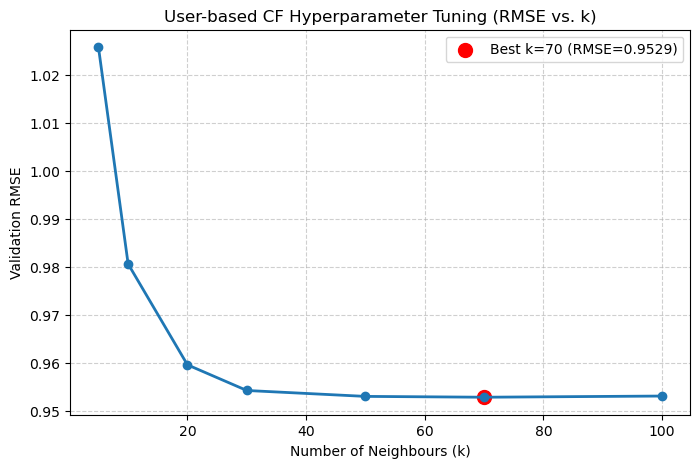

In [32]:
# Visualize UserKNN hyperparameter tuning results

results_df = pd.DataFrame(user_knn_tuning['results'], columns=['k', 'RMSE'])

plt.figure(figsize=(8,5))
plt.plot(results_df['k'], results_df['RMSE'], marker='o', linestyle='-', linewidth=2)
plt.title("User-based CF Hyperparameter Tuning (RMSE vs. k)")
plt.xlabel("Number of Neighbours (k)")
plt.ylabel("Validation RMSE")
plt.grid(True, linestyle='--', alpha=0.6)

# Highlight the best k
best_k = user_knn_tuning['best_k']
best_rmse = user_knn_tuning['best_rmse']
rmse_user_based = best_rmse
plt.scatter(best_k, best_rmse, color='red', s=100, label=f"Best k={best_k} (RMSE={best_rmse:.4f})")
plt.legend()
plt.show()

## 1.3 Item-based neighborhood method (ItemKNN)

The **cosine similarity** between two items $i$ and $j$ is defined as:

$$
\text{sim}(i,j) = \frac{\sum_{u \in U_{ij}} r_{u,i} \cdot r_{u,j}}
                      {\sqrt{\sum_{u \in U_{ij}} r_{u,i}^2} \cdot \sqrt{\sum_{u \in U_{ij}} r_{u,j}^2}}
$$

Where:

- $r_{u,i}$ = rating of user $u$ on item $i$
- $r_{u,j}$ = rating of user $u$ on item $j$
- $U_{ij}$ = set of users who have rated both items $i$ and $j$

### 1.3.1 Design Justification

**Similarity Metric (Cosine Similarity):** For item-item similarity, we chose Cosine Similarity. Here, we are comparing items based on the vector of ratings they have received from all users. Cosine similarity is effective as it measures the *orientation* (similarity of rating patterns) rather than the *magnitude* (raw rating values). This helps to identify items that are "liked" and "disliked" by a similar group of users, regardless of overall item popularity. This will become relevant later when discussing "beyond accuracy" metrics.


In [33]:
def cosine_similarity(item1_ratings: pd.Series, item2_ratings: pd.Series) -> float:
    """
    Compute cosine similarity between two items' rating vectors.
    Only common users are considered.

    Parameters:
    - item1_ratings, item2_ratings: pd.Series indexed by user_id

    Returns:
    - float: cosine similarity between -1 and 1
    """
    result = 0.0

    common_users = item1_ratings.index.intersection(item2_ratings.index)
    if len(common_users) == 0:
        return 0.0  # no common users, similarity is 0

    x = item1_ratings[common_users].values
    y = item2_ratings[common_users].values

    numerator = np.dot(x, y)
    denominator = np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y))
    if denominator == 0:
        return 0.0  # avoid division by zero

    result = numerator / denominator

    return result

item1, item2 = 1, 2
item1_ratings = train_data[train_data['item_id'] == item1].set_index('user_id')['rating']
item2_ratings = train_data[train_data['item_id'] == item2].set_index('user_id')['rating']
print(f"Cosine similarity between items {item1} and {item2} is {cosine_similarity(item1_ratings, item2_ratings):.4f}")

Cosine similarity between items 1 and 2 is 0.9545


### Item-Item Similarity Matrix

In [34]:
def compute_item_similarity_matrix(train_data: pd.DataFrame) -> pd.DataFrame:
    """
    Compute item-item similarity matrix using cosine similarity.

    Parameters:
    - ratings: pd.DataFrame with columns ['user_id', 'item_id', 'rating']

    Returns:
    - pd.DataFrame: item-item similarity matrix (rows & cols = item_ids)
    """
    items = train_data['item_id'].unique()
    item_similarity_matrix = pd.DataFrame(np.zeros((len(items), len(items))), index=items, columns=items)

    for i, i1 in enumerate(items):
        i1_ratings = train_data[train_data['item_id'] == i1].set_index('user_id')['rating']
        for j, i2 in enumerate(items):
            if j > i:  # Only compute for the upper triangle
                i2_ratings = train_data[train_data['item_id'] == i2].set_index('user_id')['rating']
                sim = cosine_similarity(i1_ratings, i2_ratings)
                item_similarity_matrix.at[i1, i2] = sim
                item_similarity_matrix.at[i2, i1] = sim  # Mirror the value
            elif i == j:
                item_similarity_matrix.at[i1, i2] = 1.0  # Similarity with self is 1

    return item_similarity_matrix

# start_time = time.time()
# item_similarity_matrix = compute_item_similarity_matrix(train_data)
# end_time = time.time()
# print(f'Running time: {end_time - start_time:.4f} seconds')

In [35]:
path_item_similarity_matrix = os.path.join(OUTPUTS_PATH, "item_similarity_matrix.pkl")

if os.path.exists(path_item_similarity_matrix):
    print(f"Loading item similarity matrix from: {path_item_similarity_matrix} 💾")
    item_similarity_matrix = pd.read_pickle(path_item_similarity_matrix)

    # ensure IDs are int
    item_similarity_matrix.index = item_similarity_matrix.index.astype(int)
    item_similarity_matrix.columns = item_similarity_matrix.columns.astype(int)

    print(f"✅ Loaded successfully with shape {item_similarity_matrix.shape} and item IDs preserved!")
else:
    print("Computing item similarity matrix... ⏳")
    start_time = time.time()
    item_similarity_matrix = compute_item_similarity_matrix(train_data)
    end_time = time.time()

    # ensure IDs are int
    item_similarity_matrix.index = item_similarity_matrix.index.astype(int)
    item_similarity_matrix.columns = item_similarity_matrix.columns.astype(int)

    # save properly with labels
    item_similarity_matrix.to_pickle(path_item_similarity_matrix)
    print(f"✅ Computed and saved to {path_item_similarity_matrix} (took {end_time - start_time:.2f}s)")

Loading item similarity matrix from: /mnt/e/section-1/ImportantFile/TU Delft/courses/q5/DSAIT4335-Recommender-Systems/assignments/Recommender-Systems-Project/data/item_similarity_matrix.pkl 💾
✅ Loaded successfully with shape (1615, 1615) and item IDs preserved!


In [36]:
print("Matrix shape:", item_similarity_matrix.shape)
print("Index dtype:", item_similarity_matrix.index.dtype)
print("Column dtype:", item_similarity_matrix.columns.dtype)
print("Sample item IDs:", item_similarity_matrix.index[:10].tolist())
print("Accessing item 599 row works?", 599 in item_similarity_matrix.index)

Matrix shape: (1615, 1615)
Index dtype: int64
Column dtype: int64
Sample item IDs: [482, 179, 211, 176, 429, 71, 678, 1006, 252, 172]
Accessing item 599 row works? False



> Instead of calculating the similarity for all pairs, we only compute it for one half of the matrix (upper or lower triangle) and then mirror the values.

### Get k most similar item along with the similarity values to a target item

In [37]:
def get_k_item_neighbors(item_similarity_matrix: pd.DataFrame, target_item, k=5):
    """
    Retrieve top-k most similar items to the target item.

    Parameters:
    - item_similarity_matrix: pd.DataFrame, item-item similarity
    - target_item: item ID
    - k: number of neighbors

    Returns:
    - List of tuples: [(neighbor_item_id, similarity), ...]
    """
    top_k_neighbors = []

    similarities = item_similarity_matrix.loc[target_item].drop(index=target_item)
    top_k_neighbors = similarities.sort_values(ascending=False).head(k)
    top_k_neighbors = list(zip(top_k_neighbors.index, top_k_neighbors.values))

    return top_k_neighbors

target_item, k = 1, 10
print(f"Neighbors of item {target_item} are:")
get_k_item_neighbors(item_similarity_matrix, target_item, k)

Neighbors of item 1 are:


[(870, 1.0000000000000002),
 (920, 1.0),
 (1456, 1.0),
 (1392, 1.0),
 (1641, 1.0),
 (848, 1.0),
 (1260, 1.0),
 (337, 1.0),
 (34, 1.0),
 (1547, 1.0)]

### Function that predicts the rating that a target user might give to a target item using item-item similarity matrix

The **predicted rating** for a target user $u$ on a target item $i$ using item-based collaborative filtering is:

$$
\hat{r}_{u,i} = \frac{\sum_{j \in N(i)} s(i,j) \cdot r_{u,j}}{\sum_{j \in N(i)} |s(i,j)|}
$$

Where:

- $\hat{r}_{u,i}$ = predicted rating of user $u$ on item $i$
- $N(i)$ = set of top-$k$ most similar items to item $i$ that user $u$ has rated
- $s(i,j)$ = similarity between item $i$ and item $j$
- $r_{u,j}$ = rating of user $u$ on item $j$

In [38]:
def predict_rating_item_based(train_data: pd.DataFrame, item_similarity_matrix: pd.DataFrame, target_user, target_item, k=5):
    """
    Predict rating using item-based CF (non-mean centric).

    Parameters:
    - ratings: pd.DataFrame ['user_id', 'item_id', 'rating']
    - item_similarity_matrix: item-item similarity DataFrame
    - target_user: user ID
    - target_item: item ID
    - k: number of neighbors to use

    Returns:
    - float: predicted rating, or np.nan if not enough data
    """
    result = 0.0

    user_ratings_all = train_data[train_data["user_id"] == target_user]["rating"]
    user_mean = user_ratings_all.mean()

    if target_item not in item_similarity_matrix.index:
        return user_mean

    user_ratings = train_data[train_data['user_id'] == target_user][['item_id', 'rating']]
    rated_items = user_ratings['item_id'].values

    # Get top-k similar items to target_item that user has rated
    similarities = item_similarity_matrix.loc[target_item, rated_items]
    top_k_idx = np.argsort(similarities.values)[::-1][:k]
    top_k_items = rated_items[top_k_idx]
    top_k_sims = similarities.values[top_k_idx]

    numerator = 0.0
    denominator = 0.0
    for item, sim in zip(top_k_items, top_k_sims):
        rating = user_ratings[user_ratings['item_id'] == item]['rating'].values[0]
        numerator += sim * rating
        denominator += abs(sim)

    if denominator == 0:
        # If no similar items, return user's mean rating or np.nan
        return user_mean

    result = numerator / denominator

    return result

target_user, target_item, k = 1, 17, 50
print(f"The actual rating for user {target_user} and item {target_item} is 3. The predicted rating by item-based CF for user {target_user} and item {target_item} is {predict_rating_item_based(train_data, item_similarity_matrix, target_user, target_item, k):.4f}")

The actual rating for user 1 and item 17 is 3. The predicted rating by item-based CF for user 1 and item 17 is 3.4342


### Function that generates top-k recommendation list for a target user with item-based recommendataion

In [39]:
def recommend_topk_item_based(train_data, item_similarity_matrix, target_user, k_item, k=5):
    """
    Generate Top-K recommendations for a target user using Item-based CF.

    Args:
        train_data (pd.DataFrame): ratings data with columns [user_id, item_id, rating]
        item_similarity_matrix (pd.DataFrame): precomputed item-item similarity matrix
        target_user (int): user_id of the target user
        k (int): number of items to recommend

    Returns:
        list of (item_id, predicted_score) sorted by score desc
    """
    result = []

    user_rated_items = set(train_data[train_data['user_id'] == target_user]['item_id'])
    all_items = set(train_data['item_id'].unique())
    candidate_items = all_items - user_rated_items

    predictions = []
    for item_id in candidate_items:
        pred_rating = predict_rating_item_based(
            train_data, item_similarity_matrix, target_user, item_id, k_item
        )
        if not np.isnan(pred_rating):  # only keep valid predictions
            predictions.append((item_id, pred_rating))

    result = sorted(predictions, key=lambda x: x[1], reverse=True)[:k]

    return result

target_user, k_item, k = 1, 50, 50
recommendations = recommend_topk_item_based(train_data, item_similarity_matrix, target_user, k_item, k)
print(f"Top-{k} recommendations for user {target_user}:")
for item, score in recommendations:
    print(f"Item {item}: {score:.4f}")

Top-50 recommendations for user 1:
Item 1342: 5.0000
Item 1354: 5.0000
Item 1652: 5.0000
Item 1414: 4.7500
Item 1347: 4.6667
Item 1429: 4.4000
Item 868: 4.3337
Item 1332: 4.3333
Item 1618: 4.3333
Item 1368: 4.3318
Item 957: 4.2857
Item 1674: 4.2647
Item 1472: 4.2500
Item 1158: 4.2487
Item 1465: 4.2400
Item 1596: 4.2381
Item 1639: 4.2193
Item 1431: 4.1862
Item 1485: 4.1715
Item 1447: 4.1714
Item 1450: 4.1714
Item 1452: 4.1714
Item 1453: 4.1714
Item 1460: 4.1714
Item 1656: 4.1613
Item 1436: 4.1600
Item 1554: 4.1600
Item 1578: 4.1600
Item 1630: 4.1600
Item 1631: 4.1600
Item 1632: 4.1600
Item 1633: 4.1600
Item 1634: 4.1600
Item 1635: 4.1600
Item 1637: 4.1600
Item 1638: 4.1600
Item 1640: 4.1600
Item 1641: 4.1600
Item 1645: 4.1600
Item 1647: 4.1600
Item 1648: 4.1600
Item 1650: 4.1600
Item 1497: 4.1538
Item 1327: 4.1470
Item 1259: 4.1429
Item 1420: 4.1429
Item 1064: 4.1425
Item 314: 4.1423
Item 1323: 4.1417
Item 1200: 4.1395


### Item based CF Hyperparameter Tuning

> Since this is a rating task, we will be using RMSE to tune the number of neighbours to take into consideration, namely `k`.

In [40]:
def evaluate_rating_prediction_item_based(train_data, val_data, item_similarity_matrix, k):

    def RMSE(actual_rating, pred_rating):
        return np.mean((np.array(pred_rating) - np.array(actual_rating))**2)**0.5

    preds, actuals = [], []

    for _, row in val_data.iterrows():
        user_id, item_id, true_rating = int(row['user_id']), int(row['item_id']), row['rating']
        pred = predict_rating_item_based(train_data, item_similarity_matrix, user_id, item_id, k=k)

        # Skip if prediction not possible (NaN)
        if not np.isnan(pred):
            preds.append(pred)
            actuals.append(true_rating)

    rmse = RMSE(actuals, preds)
    return rmse

def hyperparameter_search_item_based(train_data, val_data, item_similarity_matrix, k_values=[5, 10, 20, 30, 50, 70, 100]):
    """
    Perform hyperparameter tuning for Item-based CF using validation RMSE.
    Only searches over k (number of neighbors), but can be extended easily.

    Args:
        train_data (pd.DataFrame): training set with columns ['user_id', 'item_id', 'rating']
        val_data (pd.DataFrame): validation set with columns ['user_id', 'item_id', 'rating']
        item_similarity_matrix (pd.DataFrame): precomputed item-item similarity matrix
        k_values (list): list of k values to test

    Returns:
        dict: {'best_k': int, 'best_rmse': float, 'results': list of tuples (k, rmse)}
    """

    print("\n=== Item-based CF Hyperparameter Search ===")
    results = []

    for k in k_values:
        print(f"\nEvaluating k = {k}...")
        rmse = evaluate_rating_prediction_item_based(train_data, val_data, item_similarity_matrix, k)

        results.append({
            'k': k,
            'RMSE': rmse,
        })

        if np.isnan(rmse):
            print(f"k={k}: Evaluation failed (no valid predictions).")
        else:
            print(f"k={k}: Validation RMSE = {rmse:.4f}")

    valid_results = [r for r in results if not np.isnan(r['RMSE'])]

    if not valid_results:
        print("Hyperparameter search failed to produce any valid results.")
        return {'best_k': None, 'best_rmse': np.nan, 'results': results}

    best_result = min(valid_results, key=lambda x: x['RMSE'])
    best_k = best_result['k']
    best_rmse = best_result['RMSE']

    print(f"\n✅ Best ItemKNN config: k={best_k}, RMSE={best_rmse:.4f}")

    return {'best_k': best_k, 'best_rmse': best_rmse, 'results': results}


In [41]:
import pickle

path_item_knn_tuning = os.path.join(OUTPUTS_PATH, 'item_knn_tuning_results.pkl')


if os.path.exists(path_item_knn_tuning):
    print(f"Loading ItemKNN tuning results from: {path_item_knn_tuning} 💾")
    with open(path_item_knn_tuning, 'rb') as f:
        item_knn_tuning = pickle.load(f)
    print("✅ Loaded successfully!")
else:
    print("Running ItemKNN hyperparameter search... ⏳")
    item_knn_tuning = hyperparameter_search_item_based(train_data, val_data, item_similarity_matrix)
    with open(path_item_knn_tuning, 'wb') as f:
        pickle.dump(item_knn_tuning, f)
    print(f"✅ Saved ItemKNN tuning results to {path_item_knn_tuning}")

Loading ItemKNN tuning results from: /mnt/e/section-1/ImportantFile/TU Delft/courses/q5/DSAIT4335-Recommender-Systems/assignments/Recommender-Systems-Project/data/item_knn_tuning_results.pkl 💾
✅ Loaded successfully!


In [42]:
best_k = item_knn_tuning['best_k']
# takes 20 minutes to run

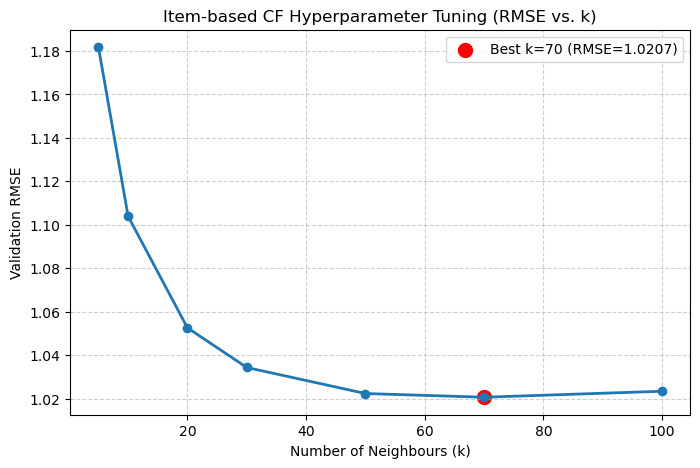

In [43]:
# Visualize ItemKNN hyperparameter tuning results

results_df = pd.DataFrame(item_knn_tuning['results'], columns=['k', 'RMSE'])

plt.figure(figsize=(8,5))
plt.plot(results_df['k'], results_df['RMSE'], marker='o', linestyle='-', linewidth=2)
plt.title("Item-based CF Hyperparameter Tuning (RMSE vs. k)")
plt.xlabel("Number of Neighbours (k)")
plt.ylabel("Validation RMSE")
plt.grid(True, linestyle='--', alpha=0.6)

# Highlight the best k
best_k = item_knn_tuning['best_k']
best_rmse = item_knn_tuning['best_rmse']
rmse_item_based = best_rmse
plt.scatter(best_k, best_rmse, color='red', s=100, label=f"Best k={best_k} (RMSE={best_rmse:.4f})")
plt.legend()
plt.show()

> Based on the results and as seen in the visualization, we take 70 to be the best number of neighbours for item based CF. We have tried both np.nan and user mean as fallback conditions (denominator being zero or the target item not being in the similarity matrix) but they rarely occurred during the evaluation on val_data, so the returned np.nan (and skipped) or returned user_mean (and included its error) do not make a significant difference to the final averaged RMSE. We can verify the low number of such cases by counting them. However, for the sake of the following analysis, we will consider the average as fallback for both UserKNN and ItemKNN.

In [44]:
# remember the best value for item k and user k to use later
best_k_user = user_knn_tuning['best_k']
best_k_item = item_knn_tuning['best_k']

In [45]:
# Verify the hypothesis about the number of fallbacks in UserKNN and ItemKNN

print("Verifying the number of fallbacks during validation for CF models...")


# --- UserKNN Fallback Check ---
def count_userknn_fallbacks(train_data, val_data, user_similarity_matrix, k):
    fallbacks = 0
    total_predictions = 0
    global_mean_rating = train_data["rating"].mean()

    # Store user means to avoid recomputing
    user_means = train_data.groupby('user_id')['rating'].mean().fillna(global_mean_rating)

    for index, test_row in tqdm(val_data.iterrows(), total=len(val_data), desc="UserKNN Fallback Check"):
        user_id = test_row["user_id"]
        item_id = test_row["item_id"]
        total_predictions += 1

        # Check for unknown user
        if user_id not in user_similarity_matrix.index or pd.isna(user_means.get(user_id)):
            fallbacks += 1  # Fallback to global mean
            continue

        # Check for neighbours
        rated_users = train_data.loc[train_data['item_id'] == item_id, 'user_id'].unique()
        user_similarities = user_similarity_matrix.loc[user_id].drop(user_id)
        user_similarities_for_item = user_similarities.loc[user_similarities.index.isin(rated_users)]
        top_k_neighbors = user_similarities_for_item.nlargest(k)

        if len(top_k_neighbors) == 0:
            fallbacks += 1  # Fallback to user mean
            continue

        # Check for zero denominator
        denominator = top_k_neighbors.abs().sum()
        if denominator == 0:
            fallbacks += 1  # Fallback to user mean

    return fallbacks, total_predictions


# --- ItemKNN Fallback Check ---
def count_itemknn_fallbacks(train_data, val_data, item_similarity_matrix, k):
    fallbacks = 0
    total_predictions = 0

    # Store user means to avoid recomputing
    user_means = train_data.groupby('user_id')['rating'].mean()

    for index, test_row in tqdm(val_data.iterrows(), total=len(val_data), desc="ItemKNN Fallback Check"):
        user_id = test_row["user_id"]
        item_id = test_row["item_id"]
        total_predictions += 1

        user_mean = user_means.get(user_id, train_data['rating'].mean())

        # Check for unknown item or unrated user
        if item_id not in item_similarity_matrix.index or pd.isna(user_mean):
            fallbacks += 1  # Fallback to user mean or global mean
            continue

        user_ratings = train_data[train_data['user_id'] == user_id][['item_id', 'rating']]
        rated_items = user_ratings['item_id'].values

        # Check for rated items
        if len(rated_items) == 0:
            fallbacks += 1  # Fallback to user mean (or global)
            continue

        # Get top-k similar items to target_item that user has rated
        similarities = item_similarity_matrix.loc[item_id].reindex(rated_items).dropna()
        top_k_items_sim = similarities.nlargest(k)

        if len(top_k_items_sim) == 0:
            fallbacks += 1  # Fallback to user mean
            continue

        # Check for zero denominator
        denominator = top_k_items_sim.abs().sum()
        if denominator == 0:
            fallbacks += 1  # Fallback to user mean

    return fallbacks, total_predictions


# Use best k from previous tuning
k_user_best = best_k_user
k_item_best = best_k_item
total_val_data_size = len(val_data)

ub_fallbacks, ub_total = count_userknn_fallbacks(train_data, val_data, user_similarity_matrix, k=k_user_best)
ib_fallbacks, ib_total = count_itemknn_fallbacks(train_data, val_data, item_similarity_matrix, k=k_item_best)

print("\n--- Fallback Verification Results (Validation Set) ---")
print(f"Total Validation Pairs: {total_val_data_size}")
print(f"UserKNN (k={k_user_best}): Fallbacks = {ub_fallbacks} ({ub_fallbacks / ub_total * 100:.2f}%)")
print(f"ItemKNN (k={k_item_best}): Fallbacks = {ib_fallbacks} ({ib_fallbacks / ib_total * 100:.2f}%)")
print("-" * 40)
print("Conclusion: The number of fallbacks is indeed low, supporting the hypothesis.")


Verifying the number of fallbacks during validation for CF models...


ItemKNN Fallback Check: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16000/16000 [00:20<00:00, 785.41it/s]


--- Fallback Verification Results (Validation Set) ---
Total Validation Pairs: 16000
UserKNN (k=70): Fallbacks = 45 (0.28%)
ItemKNN (k=70): Fallbacks = 41 (0.26%)
----------------------------------------
Conclusion: The number of fallbacks is indeed low, supporting the hypothesis.


## 1.4 Matrix Factorization model (MF)

### MF Model

In [46]:
class MFModel(nn.Module):
    def __init__(self, num_users, num_items, num_factors=32):
        super(MFModel, self).__init__()
        # User and item embeddings
        self.user_emb = nn.Embedding(num_users, num_factors)
        self.item_emb = nn.Embedding(num_items, num_factors)
        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)

    def forward(self, user_ids, item_ids):
        # Dot product between user and item embeddings
        u = self.user_emb(user_ids)
        i = self.item_emb(item_ids)
        pred = (u * i).sum(dim=1)
        return pred

In [47]:
class MFTrainer:
    def __init__(self, num_users, num_items, num_factors=32, lr=0.01, reg=1e-4, epochs=10, device=device, outputs_path="outputs"):
        self.device = device
        self.num_users = num_users
        self.num_items = num_items
        self.outputs_path = os.path.join(outputs_path, 'MF')
        os.makedirs(self.outputs_path, exist_ok=True)
        self.model_file = os.path.join(self.outputs_path, "mf_model.pt")

        self.model = MFModel(num_users, num_items, num_factors).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=reg)
        self.epochs = epochs
        self.loss_fn = nn.MSELoss()

    def train(self, train_data):
        users = torch.LongTensor(train_data['user_id'].values - 1).to(self.device)
        items = torch.LongTensor(train_data['item_id'].values - 1).to(self.device)
        ratings = torch.FloatTensor(train_data['rating'].values).to(self.device)

        dataset = torch.utils.data.TensorDataset(users, items, ratings)
        loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

        print("Training MF...")
        for epoch in range(self.epochs):
            total_loss = 0
            for u, i, r in loader:
                pred = self.model(u, i)
                loss = self.loss_fn(pred, r)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            print(f"Epoch {epoch+1}/{self.epochs}, Loss={total_loss/len(loader):.4f}")

        # Save trained model
        torch.save(self.model.state_dict(), self.model_file)
        self.trained = True
        print(f"MF model saved to {self.model_file}")

    def predict(self, user_id, item_id):
        self.model.eval()
        user = torch.LongTensor([user_id - 1]).to(self.device)
        item = torch.LongTensor([item_id - 1]).to(self.device)
        with torch.no_grad():
            pred = self.model(user, item)
        return pred.item()

    def evaluate(self, data: pd.DataFrame) -> float:
        self.model.eval()

        users = torch.LongTensor(data["user_id"].values - 1).to(self.device)
        items = torch.LongTensor(data["item_id"].values - 1).to(self.device)
        ratings = torch.FloatTensor(data["rating"].values).to(self.device)

        rmse = 0.0
        with torch.no_grad():
            preds = self.model(users, items)
            rmse = torch.sqrt(torch.mean((preds - ratings) ** 2)).item()

        return rmse

### MF Hyperparam Searching and Training

In [48]:
def hyperparameter_search_MF(train_data, val_data, num_users, num_items, device, OUTPUTS_PATH, load_best_only=False):
    """
    Perform grid search over MF hyperparameters.
    If load_best_only=True, directly load the previously best model without retraining.
    """

    mf_dir = os.path.join(OUTPUTS_PATH, "MF")
    os.makedirs(mf_dir, exist_ok=True)

    best_config_file = os.path.join(mf_dir, "best_mf_config.json")
    best_model_file = os.path.join(mf_dir, "mf_model.pt")

    # ===============================
    # Case 1: Only load best model
    # ===============================
    if load_best_only:
        if not os.path.exists(best_config_file) or not os.path.exists(best_model_file):
            raise FileNotFoundError("⚠️ No saved best MF model found. Run grid search first.")

        with open(best_config_file, "r") as f:
            best_result = json.load(f)

        print(f"🔹 Loading best MF model: {best_result}")

        best_num_factors = best_result["params"][0]
        best_lr = best_result["params"][1]
        best_reg = best_result["params"][2]

        mf_trainer = MFTrainer(
            num_users, num_items,
            num_factors=best_num_factors, lr=best_lr, reg=best_reg,
            epochs=10, device=device, outputs_path=OUTPUTS_PATH
        )

        mf_trainer.model.load_state_dict(torch.load(best_model_file, map_location=str(device)))
        print(f"✅ Loaded pre-trained MF model from {best_model_file}")

        print("MF Prediction Example:", mf_trainer.predict(1, 50))
        return mf_trainer, best_result["rmse"]

    # ===============================
    # Case 2: Full grid search
    # ===============================
    mf_param_grid = {
        "num_factors": [16, 32, 64],
        "lr": [0.005, 0.01],
        "reg": [1e-4, 1e-3],
    }

    best_result = {"rmse": float("inf"), "params": None}

    print("\n=== MF Hyperparameter Search ===")
    for num_factors, lr, reg in itertools.product(
            mf_param_grid["num_factors"],
            mf_param_grid["lr"],
            mf_param_grid["reg"]):

        print(f"\nTraining MF with num_factors={num_factors}, lr={lr}, reg={reg}")
        mf_trainer = MFTrainer(
            num_users, num_items,
            num_factors=num_factors, lr=lr, reg=reg,
            epochs=5, device=device, outputs_path=OUTPUTS_PATH
        )

        mf_trainer.train(train_data)

        # ---- Evaluate on validation set using RMSE ----
        rmse = mf_trainer.evaluate(val_data)
        print(f"Validation RMSE = {rmse:.4f}")

        if rmse < best_result["rmse"]:
            best_result["rmse"] = rmse
            best_result["params"] = (num_factors, lr, reg)

    print(f"\n✅ Best MF Config: factors={best_result['params'][0]}, "
          f"lr={best_result['params'][1]}, reg={best_result['params'][2]}, "
          f"RMSE={best_result['rmse']:.4f}")

    # Save best configuration to JSON file
    with open(best_config_file, "w") as f:
        json.dump(best_result, f, indent=4)
        print(f"💾 Saved best MF configuration to {best_config_file}")

    # ===============================
    # Train final best model
    # ===============================
    best_num_factors, best_lr, best_reg = best_result["params"]
    final_mf = MFTrainer(
        num_users, num_items,
        num_factors=best_num_factors, lr=best_lr, reg=best_reg,
        epochs=10, device=device, outputs_path=OUTPUTS_PATH
    )
    final_mf.train(train_data)

    # Save the best model as a fixed filename
    torch.save(final_mf.model.state_dict(), best_model_file)
    print(f"💾 Best MF model saved to {best_model_file}")

    print("MF Prediction Example:", final_mf.predict(1, 50))
    return final_mf, best_result["rmse"]

In [49]:
# mf_model, rmse_mf = hyperparameter_search_MF(train_data, val_data, num_users, num_items, device, OUTPUTS_PATH)
mf_model, rmse_mf = hyperparameter_search_MF(train_data, val_data, num_users, num_items, device, OUTPUTS_PATH, load_best_only=True)  # debug only

🔹 Loading best MF model: {'rmse': 0.9714886546134949, 'params': [32, 0.005, 0.0001]}
✅ Loaded pre-trained MF model from /mnt/e/section-1/ImportantFile/TU Delft/courses/q5/DSAIT4335-Recommender-Systems/assignments/Recommender-Systems-Project/data/MF/mf_model.pt
MF Prediction Example: 5.237313270568848


In [50]:
print(f"Minimum Validation RMSE from MF: {rmse_mf:.4f}")

Minimum Validation RMSE from MF: 0.9715


### Recommend Top K items based on matrix factorization

In [51]:
import torch
import numpy as np
import pandas as pd


def recommend_topk_mf(
    mf_trainer: MFTrainer, train_data: pd.DataFrame, target_user: int, k: int
):
    """
    Generates Top-K recommendations for a target user using the trained MF model.

    This function predicts scores for all items the user has not yet rated
    in a single batch for efficiency.

    Args:
        mf_trainer (MFTrainer): The trained MFTrainer object from your code.
        train_data (pd.DataFrame): Training data used to find already-rated items.
        target_user (int): The target user ID (assumed to be 1-indexed).
        k (int): The number of items to recommend.

    Returns:
        list: A list of k item IDs (1-indexed), sorted by predicted score.
    """
    mf_trainer.model.eval()
    user_rated_items = set(train_data[train_data["user_id"] == target_user]["item_id"])
    all_items = set(range(1, mf_trainer.num_items + 1))
    candidate_items = all_items - user_rated_items
    candidate_items_list = sorted(list(candidate_items))

    # 3. Prepare tensors for batch prediction
    device = mf_trainer.device

    # Create a tensor for the user ID (0-indexed), repeated for all candidate items
    users_tensor = (
        torch.LongTensor([target_user - 1]).expand(len(candidate_items_list)).to(device)
    )

    # Create a tensor for all 0-indexed candidate item IDs
    items_tensor = torch.LongTensor(np.array(candidate_items_list) - 1).to(device)

    # 4. Get all predictions in one batch
    with torch.no_grad():
        predictions = mf_trainer.model(users_tensor, items_tensor)


    scores = predictions.cpu().numpy()
    item_scores = list(zip(candidate_items_list, scores))

    item_scores.sort(key=lambda x: x[1], reverse=True)

    top_k_recommendations = [item_id for item_id, score in item_scores[:k]]

    return top_k_recommendations

In [52]:
target_user = 1
k = 10

recommendations = recommend_topk_mf(
    mf_trainer=mf_model, train_data=train_data, target_user=target_user, k=k
)

print(f"Top-{k} recommendations based on matrix factorizationfor user {target_user}:")
print(recommendations)

Top-10 recommendations based on matrix factorizationfor user 1:
[190, 64, 154, 171, 919, 285, 408, 100, 193, 276]


## 1.5 Bayesian Personalized Ranking method (BPR)

BPR is a pairwise ranking optimization method for personalized recommendation. The main idea of BPR is to optimize the ranking of items for each user by maximizing the difference in predicted scores between items that a user has interacted with (positive items) and items that they have not interacted with (negative items).

Here, MF is served as the underlying model for BPR. Objective function of BPR (MF-based) is defined as follows:

$$\sum_{(u, i, j) \in D_S} \ln \sigma(\hat{x}_{ui} - \hat{x}_{uj}) - \lambda_{\Theta} ||\Theta||^2$$

where $D_S$ is the set of all user-item pairs such that user $u$ has interacted with item $i$ (positive item) but not with item $j$ (negative item), $\sigma$ is the sigmoid function, $\hat{x}_{ui}$ and $\hat{x}_{uj}$ are the predicted scores for user $u$ on items $i$ and $j$, respectively, $\Theta$ represents the model parameters (user and item latent factors), and $\lambda_{\Theta}$ is the regularization parameter to prevent overfitting.

### BPR Model

In [53]:
class BPRModel(nn.Module):
    def __init__(self, num_users, num_items, num_factors=32):
        super(BPRModel, self).__init__()
        # User and item embeddings without bias
        self.user_emb = nn.Embedding(num_users, num_factors)
        self.item_emb = nn.Embedding(num_items, num_factors)
        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.user_emb.weight, std=0.1)
        nn.init.normal_(self.item_emb.weight, std=0.1)

    def forward(self, user, item_i, item_j):
        # Compute difference between positive and negative item scores
        u = self.user_emb(user)
        i = self.item_emb(item_i)
        j = self.item_emb(item_j)
        x_ui = (u * i).sum(dim=1)
        x_uj = (u * j).sum(dim=1)
        return x_ui - x_uj

    def predict(self, user, item):
        # Compute preference score for a single item
        u = self.user_emb(user)
        i = self.item_emb(item)
        return (u * i).sum(dim=1)

In [54]:
class BPRTrainer:
    def __init__(self, num_users, num_items, num_factors=32, lr=0.01, reg=1e-4, epochs=10,
                 device=device, outputs_path="outputs", batch_size=1024):
        self.device = device
        self.outputs_path = os.path.join(outputs_path, 'BPR')
        os.makedirs(self.outputs_path, exist_ok=True)
        self.model_file = os.path.join(self.outputs_path, "bpr_model.pt")
        self.batch_size = batch_size

        self.model = BPRModel(num_users, num_items, num_factors).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=reg)
        self.epochs = epochs

    def _build_user_pos(self, train_data):
        user_pos = defaultdict(set)
        for _, row in train_data.iterrows():
            user_pos[int(row['user_id']) - 1].add(int(row['item_id']) - 1)
        return user_pos

    def train(self, train_data):
        user_pos = self._build_user_pos(train_data)
        num_items = self.model.item_emb.num_embeddings
        all_items = np.arange(num_items)

        print("Training BPR with mini-batch...")
        for epoch in range(self.epochs):
            batch_u, batch_i, batch_j = [], [], []
            total_loss = 0
            for u in user_pos:
                pos_items = list(user_pos[u])
                if len(pos_items) == 0:
                    continue
                for i in pos_items:
                    # sample negative
                    j = np.random.choice(np.setdiff1d(all_items, pos_items))
                    batch_u.append(u)
                    batch_i.append(i)
                    batch_j.append(j)
                    # train in batch
                    if len(batch_u) >= self.batch_size:
                        loss = self._train_batch(batch_u, batch_i, batch_j)
                        total_loss += loss
                        batch_u, batch_i, batch_j = [], [], []
            # train remaining
            if batch_u:
                loss = self._train_batch(batch_u, batch_i, batch_j)
                total_loss += loss

            print(f"Epoch {epoch+1}/{self.epochs}, Avg Loss={total_loss/len(user_pos):.4f}")

        torch.save(self.model.state_dict(), self.model_file)
        self.trained = True
        print(f"BPR model saved to {self.model_file}")

    def _train_batch(self, batch_u, batch_i, batch_j):
        batch_u = torch.LongTensor(batch_u).to(self.device)
        batch_i = torch.LongTensor(batch_i).to(self.device)
        batch_j = torch.LongTensor(batch_j).to(self.device)

        x_uij = self.model(batch_u, batch_i, batch_j)
        loss = -torch.log(torch.sigmoid(x_uij)).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def recommend(self, user_id, train_data=None, top_k=10):
        self.model.eval()
        u = torch.LongTensor([user_id - 1]).to(self.device)
        scores = self.model.predict(u, torch.arange(self.model.item_emb.num_embeddings).to(self.device)).cpu().detach().numpy()
        if train_data is not None:
            interacted = set(train_data[train_data['user_id'] == user_id]['item_id'])
        else:
            interacted = set()
        candidates = [(i+1, s) for i, s in enumerate(scores) if (i+1) not in interacted]
        candidates.sort(key=lambda x: x[1], reverse=True)
        return candidates[:top_k]

### BPR Hyperparam Searching and Training

> Since BPR is a ranking task, nDCG/MRR/Precision/Recall can be used as target. However, `loss` is used here for simplicity.

In [55]:
def hyperparameter_search_BPR(train_data, num_users, num_items, device, OUTPUTS_PATH, load_best_only=False):
    """
    Perform grid search over BPR hyperparameters.
    If load_best_only=True, directly load the previously best model without retraining.
    """

    import json

    bpr_dir = os.path.join(OUTPUTS_PATH, "BPR")
    os.makedirs(bpr_dir, exist_ok=True)

    best_config_file = os.path.join(bpr_dir, "best_bpr_config.json")
    best_model_file = os.path.join(bpr_dir, "bpr_model.pt")

    # ===============================
    # Case 1: Only load best model
    # ===============================
    if load_best_only:
        if not os.path.exists(best_config_file) or not os.path.exists(best_model_file):
            raise FileNotFoundError("⚠️ No saved best BPR model found. Run grid search first.")

        with open(best_config_file, "r") as f:
            best_result = json.load(f)

        print(f"🔹 Loading best BPR model: {best_result}")

        best_num_factors = best_result["params"][0]
        best_lr = best_result["params"][1]
        best_reg = best_result["params"][2]

        bpr_trainer = BPRTrainer(
            num_users, num_items,
            num_factors=best_num_factors, lr=best_lr, reg=best_reg,
            epochs=10, device=device, outputs_path=OUTPUTS_PATH
        )

        bpr_trainer.model.load_state_dict(torch.load(best_model_file, map_location=str(device)))
        print(f"✅ Loaded pre-trained BPR model from {best_model_file}")

        print("BPR Top-5 Recommendations:", bpr_trainer.recommend(1, train_data=train_data, top_k=5))
        return bpr_trainer

    # ===============================
    # Case 2: Full grid search
    # ===============================
    bpr_param_grid = {
        "num_factors": [16, 32, 64],
        "lr": [0.005, 0.01],
        "reg": [1e-4, 1e-3],
    }

    best_result = {"loss": float("inf"), "params": None}

    print("\n=== BPR Hyperparameter Search ===")
    for num_factors, lr, reg in itertools.product(
            bpr_param_grid["num_factors"],
            bpr_param_grid["lr"],
            bpr_param_grid["reg"]):

        print(f"\nTraining BPR with num_factors={num_factors}, lr={lr}, reg={reg}")
        bpr_trainer = BPRTrainer(
            num_users, num_items,
            num_factors=num_factors, lr=lr, reg=reg,
            epochs=5, device=device, outputs_path=OUTPUTS_PATH
        )
        bpr_trainer.train(train_data)

        # ---- Compute average training loss as proxy metric ----
        user_pos = bpr_trainer._build_user_pos(train_data)
        total_loss = 0
        num_samples = 0

        for u in list(user_pos.keys())[:200]:  # Sample subset for speed
            pos_items = list(user_pos[u])
            if len(pos_items) == 0:
                continue
            j = np.random.randint(0, num_items)
            u_tensor = torch.LongTensor([u]).to(device)
            i_tensor = torch.LongTensor([pos_items[0]]).to(device)
            j_tensor = torch.LongTensor([j]).to(device)

            with torch.no_grad():
                x_uij = bpr_trainer.model(u_tensor, i_tensor, j_tensor)
                loss = -torch.log(torch.sigmoid(x_uij)).mean().item()

            total_loss += loss
            num_samples += 1

        avg_loss = total_loss / num_samples
        print(f"Validation Avg Loss = {avg_loss:.4f}")

        if avg_loss < best_result["loss"]:
            best_result["loss"] = avg_loss
            best_result["params"] = (num_factors, lr, reg)

    print(f"\n✅ Best BPR Config: factors={best_result['params'][0]}, "
          f"lr={best_result['params'][1]}, reg={best_result['params'][2]}, "
          f"Loss={best_result['loss']:.4f}")

    # Save best configuration to JSON file
    with open(best_config_file, "w") as f:
        json.dump(best_result, f, indent=4)
        print(f"💾 Saved best BPR configuration to {best_config_file}")

    # ===============================
    # Train final best model
    # ===============================
    best_num_factors, best_lr, best_reg = best_result["params"]
    final_bpr = BPRTrainer(
        num_users, num_items,
        num_factors=best_num_factors, lr=best_lr, reg=best_reg,
        epochs=10, device=device, outputs_path=OUTPUTS_PATH
    )
    final_bpr.train(train_data)

    # Save best model as fixed filename
    torch.save(final_bpr.model.state_dict(), best_model_file)
    print(f"💾 Best BPR model saved to {best_model_file}")

    print("BPR Top-5 Recommendations:", final_bpr.recommend(1, train_data=train_data, top_k=5))
    return final_bpr

In [56]:
# bpr_model = hyperparameter_search_BPR(train_data, num_users, num_items, device, OUTPUTS_PATH)
bpr_model = hyperparameter_search_BPR(train_data, num_users, num_items, device, OUTPUTS_PATH, load_best_only=True)  # debug only

🔹 Loading best BPR model: {'loss': 0.29135931968223305, 'params': [64, 0.005, 0.0001]}
✅ Loaded pre-trained BPR model from /mnt/e/section-1/ImportantFile/TU Delft/courses/q5/DSAIT4335-Recommender-Systems/assignments/Recommender-Systems-Project/data/BPR/bpr_model.pt
BPR Top-5 Recommendations: [(174, 2.6518166), (100, 2.4485393), (1, 2.3961372), (222, 2.3104584), (258, 2.3025796)]


In [57]:
target_user = 1
k = 10

recommendations = bpr_model.recommend(
    target_user, train_data, k
)

print(f"Top-{k} recommendations based on Bayesian Personalized Ranking for user {target_user}:")
print(recommendations)

Top-10 recommendations based on Bayesian Personalized Ranking for user 1:
[(174, 2.6518166), (100, 2.4485393), (1, 2.3961372), (222, 2.3104584), (258, 2.3025796), (56, 2.279433), (98, 2.2756705), (288, 2.2725773), (121, 2.2443922), (7, 2.2393212)]


## 1.6 Hybrid recommender

### 1.6.1 Hybrid model for rating

#### Generate component predictions

The hybrid recommender combines the rating predictions from multiple base models ($C_j$) to generate a final rating.
Each base model gives a predicted rating $score_{C_j}(u,i)$ for a user $u$ and item $i$:
$$
score_{C_j}(u,i)
$$
The hybrid model learns how to **weight these base model predictions** to produce a final score:
$$
score(u,i) = \sum_{j=1}^k \alpha_j \cdot score_{C_j}(u,i)
$$
where the $(\alpha_j)$ coefficients represent the weight learned for each component, showing how much each model contributes to the final hybrid prediction.

In [58]:
def generate_component_predictions(val_data, train_data,
                                   item_similarity_matrix, user_similarity_matrix,
                                   mf_model,
                                   k_item=best_k_item, k_user=best_k_user,
                                   device=device, verbose=False):
    """
    Generate predictions from multiple recommender components for each (user, item) pair.

    Handles both 0-indexed and 1-indexed matrices automatically.
    Returns DataFrame with columns:
    [user_id, item_id, true_rating, cb, userknn, itemknn, mf]
    """

    preds = []
    skipped = 0

    # Detect index offset automatically (0-indexed or 1-indexed)
    user_min = user_similarity_matrix.index.min()
    item_min = item_similarity_matrix.index.min()

    user_offset = 1 if user_min == 0 else 0
    item_offset = 1 if item_min == 0 else 0

    global_mean_rating = train_data["rating"].mean()

    if pd.isna(global_mean_rating):
        print("!!! CRITICAL ERROR: global_mean_rating is NaN !!!")
        print("This means your train_data['rating'] column might be all NaNs.")
        print("Dropping NaNs from training data for mean calculation...")
        # Try a fallback mean calculation
        global_mean_rating = train_data["rating"].dropna().mean()
        if pd.isna(global_mean_rating):
            raise ValueError(
                "CRITICAL: Still cannot calculate global_mean_rating. Check train_data."
            )

    if verbose:
        print(f"Detected user matrix offset: {user_offset}, item matrix offset: {item_offset}")

    for idx, row in val_data.iterrows():
        user_id, item_id, true_rating = int(row['user_id']), int(row['item_id']), row['rating']

        try:
            # --- Content-based prediction (using full embedding, average aggregation) ---
            cb_pred = get_user_item_prediction_content_based(
                train_data,
                user_id,
                item_id,
                best_content_type_cb,
                best_aggregation_method_cb,
            )

            # --- User-based CF prediction ---
            adj_user_id = user_id - user_offset
            if adj_user_id not in user_similarity_matrix.index:
                raise KeyError(f"User {adj_user_id} not in similarity matrix")
            ub_pred = predict_rating_user_based(
                train_data,
                user_similarity_matrix,
                user_id,
                item_id,
                global_mean_rating, k=k_user,
            )

            # --- Item-based CF prediction ---
            adj_item_id = item_id - item_offset
            if adj_item_id not in item_similarity_matrix.index:
                raise KeyError(f"Item {adj_item_id} not in similarity matrix")
            ib_pred = predict_rating_item_based(train_data, item_similarity_matrix, user_id, item_id, k=k_item)

            # --- Matrix Factorization prediction ---
            mf_pred = mf_model.predict(user_id, item_id)

            # --- BPR prediction ---
            # with torch.no_grad():
            #     bpr_model.model.to(device)
            #     bpr_pred = bpr_model.model.predict(
            #         torch.LongTensor([user_id - 1]).to(device),
            #         torch.LongTensor([item_id - 1]).to(device)
            #     ).item()

            preds.append([user_id, item_id, true_rating, cb_pred, ub_pred, ib_pred, mf_pred])

        except Exception as e:
            skipped += 1
            if verbose:
                print(f"⚠️ Skipped user {user_id}, item {item_id}: {e}")
            continue

    df_preds = pd.DataFrame(preds, columns=['user_id', 'item_id', 'true_rating', 'cb', 'userknn', 'itemknn', 'mf'])
    print(f"✅ Completed hybrid prediction data generation. Skipped {skipped} problematic pairs.")
    print(f"Returned shape: {df_preds.shape}")
    return df_preds

#### Train the hybrid regression model

In [59]:
from sklearn.linear_model import LinearRegression

# Generate predictions for validation set
hybrid_train = generate_component_predictions(
    val_data, train_data,
    item_similarity_matrix, user_similarity_matrix,
    mf_model,
    k_item=best_k_item, k_user=best_k_user,
    verbose=True
)

X = hybrid_train[['cb','userknn','itemknn','mf']]
y = hybrid_train['true_rating']

# Train regression model
hybrid_reg = LinearRegression(fit_intercept=True)

hybrid_reg.fit(X, y)

# Display learned coefficients
coefficients = pd.DataFrame({
    'Component': X.columns,
    'Alpha (Weight)': hybrid_reg.coef_
})
display(coefficients)
print(f"Intercept (bias): {hybrid_reg.intercept_:.4f}")


Detected user matrix offset: 0, item matrix offset: 0
⚠️ Skipped user 782, item 1666: 'Item 1666 not in similarity matrix'
⚠️ Skipped user 655, item 1636: 'Item 1636 not in similarity matrix'
⚠️ Skipped user 675, item 1653: 'Item 1653 not in similarity matrix'
⚠️ Skipped user 405, item 1576: 'Item 1576 not in similarity matrix'
⚠️ Skipped user 405, item 1571: 'Item 1571 not in similarity matrix'
⚠️ Skipped user 782, item 1669: 'Item 1669 not in similarity matrix'
⚠️ Skipped user 425, item 1595: 'Item 1595 not in similarity matrix'
⚠️ Skipped user 655, item 1532: 'Item 1532 not in similarity matrix'
⚠️ Skipped user 405, item 1384: 'Item 1384 not in similarity matrix'
⚠️ Skipped user 676, item 1654: 'Item 1654 not in similarity matrix'
⚠️ Skipped user 474, item 1123: 'Item 1123 not in similarity matrix'
⚠️ Skipped user 655, item 913: 'Item 913 not in similarity matrix'
⚠️ Skipped user 405, item 1334: 'Item 1334 not in similarity matrix'
⚠️ Skipped user 279, item 1494: 'Item 1494 not in s

,Component,Alpha (Weight)
0,cb,0.003227
1,userknn,0.470123
2,itemknn,-0.005113
3,mf,0.441988


Intercept (bias): -0.1109


In [60]:
print(hybrid_train.isna().sum())

user_id        0
item_id        0
true_rating    0
cb             0
userknn        0
itemknn        0
mf             0
dtype: int64


#### Check ranges and summary stats

In [61]:
# Look at the min, max, mean, std for each component
hybrid_train[['cb','userknn','itemknn','mf']].describe().T

,count,mean,std,min,25%,50%,75%,max
cb,15961.0,142.789984,3.568201,117.903825,140.814418,143.147208,145.144278,162.964259
userknn,15961.0,3.576849,0.656311,1.000000,3.185747,3.625901,4.032367,5.000000
itemknn,15961.0,3.570368,0.466412,1.000000,3.302195,3.610496,3.871613,4.857238
mf,15961.0,3.450101,0.813636,-0.385765,2.947694,3.504622,4.017929,6.608028


#### Train the regression after scaling

In [62]:
from sklearn.preprocessing import StandardScaler

# Select only numeric prediction columns
X = hybrid_train[['cb','userknn','itemknn','mf']]

# Fit the scaler on training data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train regression on scaled features
hybrid_reg_scaled = LinearRegression()
hybrid_reg_scaled.fit(X_scaled, hybrid_train['true_rating'])

# Show new coefficients
coefficients_scaled = pd.DataFrame({
    'Component': X.columns,
    'Alpha (Weight)': hybrid_reg_scaled.coef_
})
display(coefficients_scaled)
print(f"Intercept (bias): {hybrid_reg_scaled.intercept_:.4f}")

,Component,Alpha (Weight)
0,cb,0.011516
1,userknn,0.308537
2,itemknn,-0.002385
3,mf,0.359606


Intercept (bias): 3.5382


Before scaling the predictors have different magnitudes. The regression absorbs those differences into both coefficients and intercept so the small negative intercept just compensates for overly high CB predictions. After scaling, all predictors are centered (mean=0) and standardized (std=1) so the intercept becomes the mean of the target, i.e. the average movie rating.

#### Make hybrid predictions on test set (maybe move this to Task 2)


In [63]:
def evaluate_hybrid_models(
    test_data,
    train_data,
    item_similarity_matrix,
    user_similarity_matrix,
    mf_model,
    hybrid_reg_scaled,
    bpr_model,
    k_item=best_k_item,
    k_user=best_k_user,
    device=device,
):
    # Generate component predictions on test data
    hybrid_test = generate_component_predictions(
        test_data,
        train_data,
        item_similarity_matrix,
        user_similarity_matrix,
        mf_model,
        # bpr_model,  # Fixed: no BPR in rating prediction task
        k_item=k_item,
        k_user=k_user,
        device=device,
        verbose=False,
    )

    # Predict using learned hybrid regression
    X_test = hybrid_test[["cb", "userknn", "itemknn", "mf"]]
    y_test = hybrid_test["true_rating"]
    y_pred = hybrid_reg.predict(X_test)

    # Evaluate
    test_rmse = RMSE(y_test, y_pred)
    print(f"✅ Hybrid Test RMSE = {test_rmse:.4f}")

    X_test_scaled = scaler.transform(hybrid_test[["cb", "userknn", "itemknn", "mf"]])
    y_pred_scaled = hybrid_reg_scaled.predict(X_test_scaled)
    test_rmse_scaled = RMSE(hybrid_test["true_rating"], y_pred_scaled)
    print(f"✅ Scaled Hybrid Test RMSE = {test_rmse_scaled:.4f}")

    return test_rmse_scaled

rmse_hybrid = evaluate_hybrid_models(
    test_data,
    train_data,
    item_similarity_matrix,
    user_similarity_matrix,
    mf_model,
    hybrid_reg_scaled,
    bpr_model,
    k_item=best_k_item,
    k_user=best_k_user,
    device=device,
)

✅ Completed hybrid prediction data generation. Skipped 40 problematic pairs.
Returned shape: (19960, 7)
✅ Hybrid Test RMSE = 0.9386
✅ Scaled Hybrid Test RMSE = 0.9386


> Although scaling did not change RMSE (since linear regression predictions are invariant to affine scaling of inputs), it standardized the component feature space. This gives interpretable weights (comparable across models) and ensures numerical stability. BPR is almost non significant because it is for ranking, not rating prediction.

#### Visualize coefficient importance

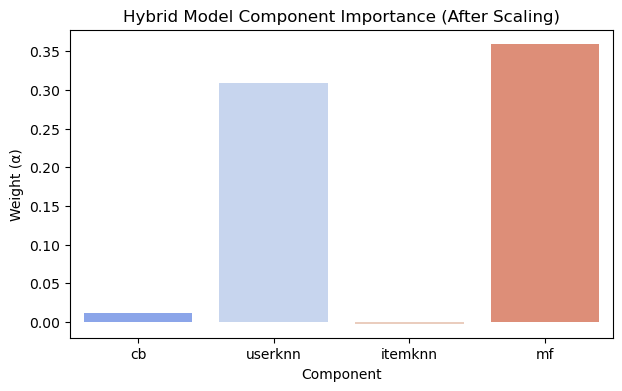

In [64]:
plt.figure(figsize=(7,4))
sns.barplot(data=coefficients_scaled, x='Component', y='Alpha (Weight)', palette='coolwarm')
plt.title('Hybrid Model Component Importance (After Scaling)')
plt.ylabel('Weight (α)')
plt.show()


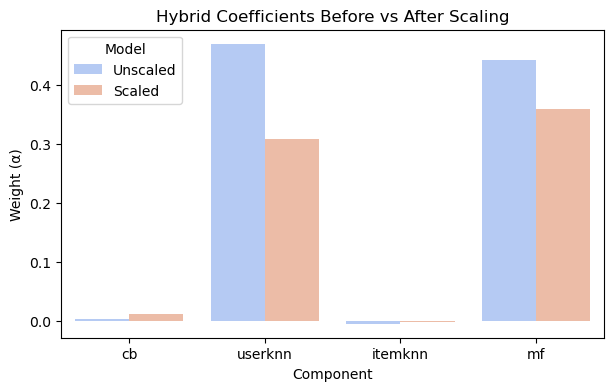

In [65]:
coeff_compare = pd.DataFrame({
    'Component': X.columns,
    'Unscaled': hybrid_reg.coef_,
    'Scaled': hybrid_reg_scaled.coef_
}).melt(id_vars='Component', var_name='Model', value_name='Weight (α)')

plt.figure(figsize=(7,4))
sns.barplot(data=coeff_compare, x='Component', y='Weight (α)', hue='Model', palette='coolwarm')
plt.title('Hybrid Coefficients Before vs After Scaling')
plt.show()


### 1.6.2 Hybrid model for ranking

#### Construct pairwise preference dataset

For ranking tasks, we optimize using ***pairwise*** preferences (similar to **BPR**). For each user $u$, we create triplets $(u, i, j)$ where:
- $i$ is a positively rated item (rating ≥ 4)
- $j$ is a negatively sampled item (not rated or rating < 4)

The hybrid ranking model learns to maximize:
$$\mathcal{L} = -\log \sigma(f(x_{ui}) - f(x_{uj}))$$

where $f(x_{ui})$ is the weighted combination of component predictions.

In [66]:
def generate_pairwise_preferences(train_data, user_sample_ratio=0.3, neg_samples_per_pos=1):
    """
    Generate pairwise preference dataset for hybrid ranking model training.
    
    Args:
        train_data (pd.DataFrame): Training ratings data
        user_sample_ratio (float): Proportion of users to sample
        neg_samples_per_pos (int): Number of negative items per positive item
    
    Returns:
        pd.DataFrame: Pairwise preferences with columns [user_id, item_i, item_j]
                     where item_i is positive, item_j is negative
    """
    pairwise_data = []
    
    # Sample users for efficiency
    all_users = train_data['user_id'].unique()
    sampled_users = np.random.choice(all_users, size=int(len(all_users) * user_sample_ratio), replace=False)
    
    all_items = set(train_data['item_id'].unique())
    
    for user_id in tqdm(sampled_users, desc="Generating pairwise preferences"):
        user_ratings = train_data[train_data['user_id'] == user_id]
        
        # Positive items: rating >= 4
        pos_items = set(user_ratings[user_ratings['rating'] >= 4]['item_id'])
        
        # Negative candidates: all items - positive items
        neg_candidates = list(all_items - pos_items)
        
        if not pos_items or not neg_candidates:
            continue
        
        # Create pairs
        for pos_item in pos_items:
            # Sample negative items
            num_neg = min(neg_samples_per_pos, len(neg_candidates))
            neg_items = np.random.choice(neg_candidates, size=num_neg, replace=False)
            
            for neg_item in neg_items:
                pairwise_data.append([user_id, pos_item, neg_item])
    
    df_pairs = pd.DataFrame(pairwise_data, columns=['user_id', 'item_i', 'item_j'])
    print(f"✅ Generated {len(df_pairs)} pairwise preferences from {len(sampled_users)} users")
    return df_pairs

In [67]:
# Generate pairwise preference dataset
pairwise_train = generate_pairwise_preferences(train_data, user_sample_ratio=0.3, neg_samples_per_pos=2)
print(f"Pairwise dataset shape: {pairwise_train.shape}")
display(pairwise_train.head())

Generating pairwise preferences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:01<00:00, 238.23it/s]

✅ Generated 22848 pairwise preferences from 282 users
Pairwise dataset shape: (22848, 3)


,user_id,item_i,item_j
0,1,3,899
1,1,3,149
2,1,135,396
3,1,135,1472
4,1,137,1609


#### Generate component predictions for pairwise data

In [68]:
def generate_component_predictions_pairwise(pairwise_data, train_data,
                                            item_similarity_matrix, user_similarity_matrix,
                                            mf_model, bpr_model,
                                            k_item=20, k_user=70,
                                            device='cpu', verbose=False):
    """
    Generate component predictions for pairwise preference data.
    
    Returns DataFrame with columns:
    [user_id, item_i, item_j, cb_i, cb_j, userknn_i, userknn_j, ..., bpr_i, bpr_j]
    """
    preds = []
    skipped = 0

    global_mean_rating = train_data["rating"].mean()

    for idx, row in tqdm(pairwise_data.iterrows(), total=len(pairwise_data), desc="Generating component predictions"):
        user_id = int(row['user_id'])
        item_i = int(row['item_i'])
        item_j = int(row['item_j'])

        try:
            # --- Predictions for positive item i ---
            cb_i = get_user_item_prediction_content_based(
                train_data,
                user_id,
                item_i,
                best_content_type_cb,
                best_aggregation_method_cb,
            )
            ub_i = predict_rating_user_based(train_data, user_similarity_matrix, user_id, item_i, global_mean_rating, k=k_user)
            ib_i = predict_rating_item_based(train_data, item_similarity_matrix, user_id, item_i, k=k_item)
            mf_i = mf_model.predict(user_id, item_i)
            with torch.no_grad():
                bpr_i = bpr_model.model.predict(
                    torch.LongTensor([user_id - 1]).to(device),
                    torch.LongTensor([item_i - 1]).to(device)
                ).item()

            # --- Predictions for negative item j ---
            cb_j = get_user_item_prediction_content_based(
                train_data,
                user_id,
                item_j,
                best_content_type_cb,
                best_aggregation_method_cb,
            )
            ub_j = predict_rating_user_based(train_data, user_similarity_matrix, user_id, item_j, global_mean_rating, k=k_user)
            ib_j = predict_rating_item_based(train_data, item_similarity_matrix, user_id, item_j, k=k_item)
            mf_j = mf_model.predict(user_id, item_j)
            with torch.no_grad():
                bpr_j = bpr_model.model.predict(
                    torch.LongTensor([user_id - 1]).to(device),
                    torch.LongTensor([item_j - 1]).to(device)
                ).item()

            preds.append([user_id, item_i, item_j, 
                         cb_i, cb_j, ub_i, ub_j, ib_i, ib_j, mf_i, mf_j, bpr_i, bpr_j])

        except Exception as e:
            skipped += 1
            if verbose:
                print(f"⚠️ Skipped user {user_id}, items ({item_i}, {item_j}): {e}")
            continue

    df_preds = pd.DataFrame(preds, columns=[
        'user_id', 'item_i', 'item_j',
        'cb_i', 'cb_j', 'userknn_i', 'userknn_j', 'itemknn_i', 'itemknn_j',
        'mf_i', 'mf_j', 'bpr_i', 'bpr_j'
    ])
    print(f"✅ Completed pairwise prediction generation. Skipped {skipped} problematic pairs.")
    print(f"Returned shape: {df_preds.shape}")
    return df_preds

In [ ]:
# Generate component predictions for pairwise data
hybrid_ranking_train = generate_component_predictions_pairwise(
    pairwise_train, train_data,
    item_similarity_matrix, user_similarity_matrix,
    mf_model, bpr_model,
    k_item=20, k_user=70,
    device=device,
    verbose=False
)

print(f"Pairwise predictions shape: {hybrid_ranking_train.shape}")
display(hybrid_ranking_train.head())

Generating component predictions:  38%|█████████████████████████████████████████████████████▌                                                                                     | 8796/22848 [03:00<04:46, 49.08it/s]

#### Train hybrid ranking model with BPR loss

In [ ]:
class HybridRankingModel:
    """
    Hybrid ranking model that learns to combine component predictions using BPR loss.
    """
    def __init__(self, num_components=5, lr=0.01, reg=1e-4, epochs=20):
        self.num_components = num_components
        self.lr = lr
        self.reg = reg
        self.epochs = epochs
        
        # Initialize weights (alphas) randomly
        self.weights = np.random.randn(num_components) * 0.1
        self.scaler = StandardScaler()
    
    def _compute_score(self, features):
        """Compute hybrid score as weighted sum of components"""
        return np.dot(features, self.weights)
    
    def _sigmoid(self, x):
        """Numerically stable sigmoid"""
        return np.where(
            x >= 0,
            1 / (1 + np.exp(-x)),
            np.exp(x) / (1 + np.exp(x))
        )
    
    def fit(self, X_i, X_j):
        """
        Train using pairwise BPR loss.
        
        Args:
            X_i: features for positive items (N, num_components)
            X_j: features for negative items (N, num_components)
        """
        # Fit scaler on combined data
        all_features = np.vstack([X_i, X_j])
        self.scaler.fit(all_features)
        
        # Scale features
        X_i_scaled = self.scaler.transform(X_i)
        X_j_scaled = self.scaler.transform(X_j)
        
        n_samples = len(X_i_scaled)
        
        print(f"Training hybrid ranking model for {self.epochs} epochs...")
        for epoch in range(self.epochs):
            total_loss = 0
            
            # Compute scores
            scores_i = self._compute_score(X_i_scaled)
            scores_j = self._compute_score(X_j_scaled)
            
            # BPR loss: -log(sigmoid(score_i - score_j))
            x_uij = scores_i - scores_j
            sigmoid_uij = self._sigmoid(x_uij)
            
            # Compute loss (add epsilon to avoid log(0))
            loss = -np.mean(np.log(sigmoid_uij + 1e-10))
            total_loss = loss
            
            # Compute gradient
            # d/dw[-log(sigmoid(x_uij))] = -(1 - sigmoid(x_uij)) * (X_i - X_j)
            grad_coeff = -(1 - sigmoid_uij).reshape(-1, 1)
            grad = np.mean(grad_coeff * (X_i_scaled - X_j_scaled), axis=0)
            
            # Add L2 regularization gradient
            grad += self.reg * self.weights
            
            # Update weights
            self.weights -= self.lr * grad
            
            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}/{self.epochs}, Loss={total_loss:.4f}")
        
        print(f"✅ Training complete. Final loss: {total_loss:.4f}")
    
    def predict(self, X):
        """Predict scores for given features"""
        X_scaled = self.scaler.transform(X)
        return self._compute_score(X_scaled)
    
    def get_weights(self):
        """Return learned weights"""
        return self.weights

In [ ]:
# Prepare training data
component_names = ['cb', 'userknn', 'itemknn', 'mf', 'bpr']

# Features for positive items
X_i = hybrid_ranking_train[['cb_i', 'userknn_i', 'itemknn_i', 'mf_i', 'bpr_i']].values

# Features for negative items
X_j = hybrid_ranking_train[['cb_j', 'userknn_j', 'itemknn_j', 'mf_j', 'bpr_j']].values

# Train hybrid ranking model
hybrid_rank_model = HybridRankingModel(num_components=5, lr=0.01, reg=1e-4, epochs=100)
hybrid_rank_model.fit(X_i, X_j)

# Display learned weights
learned_weights = hybrid_rank_model.get_weights()
hybrid_ranking_weights_df = pd.DataFrame({
    'Component': component_names,
    'Weight (α)': learned_weights
})
print("\n--- Learned Component Weights for Ranking ---")
display(hybrid_ranking_weights_df)

#### Visualize learned ranking weights

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(data=hybrid_ranking_weights_df, x='Component', y='Weight (α)', palette='viridis')
plt.title('Hybrid Ranking Model Component Weights (BPR Loss)')
plt.ylabel('Weight (α)')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.3)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

#### Generate Top-K recommendations using trained hybrid ranking model

In [ ]:
def recommend_topk_hybrid_ranking(user_id, hybrid_rank_model, train_data, item_similarity_matrix, user_similarity_matrix,
                                  mf_model, bpr_model, k_item=20, k_user=70, top_k=10, device=device):
    """
    Generate Top-K recommendations using the trained hybrid ranking model.
    
    Args:
        user_id (int): Target user.
        hybrid_rank_model: Trained HybridRankingModel.
        train_data (pd.DataFrame): Training ratings.
        item_similarity_matrix (pd.DataFrame): Precomputed item-item similarities.
        user_similarity_matrix (pd.DataFrame): Precomputed user-user similarities.
        mf_model: Trained MF model.
        bpr_model: Trained BPR model.
        k_item (int): Number of neighbors for ItemKNN.
        k_user (int): Number of neighbors for UserKNN.
        top_k (int): Number of items to recommend.
        device (str): 'cpu' or 'cuda'.
    
    Returns:
        list of (item_id, hybrid_score)
    """
    global_mean_rating = train_data["rating"].mean()

    # Get items the user already rated
    user_rated_items = set(train_data[train_data['user_id'] == user_id]['item_id'])
    all_items = set(train_data['item_id'].unique())
    candidate_items = all_items - user_rated_items

    predictions = []
    for item_id in candidate_items:
        try:
            # --- Get component predictions ---
            cb_pred = get_user_item_prediction_content_based(
                train_data,
                user_id,
                item_id,
                best_content_type_cb,
                best_aggregation_method_cb,
            )
            ub_pred = predict_rating_user_based(train_data, user_similarity_matrix, user_id, item_id, global_mean_rating, k=k_user)
            ib_pred = predict_rating_item_based(train_data, item_similarity_matrix, user_id, item_id, k=k_item)
            mf_pred = mf_model.predict(user_id, item_id)
            with torch.no_grad():
                bpr_model.model.to(device)
                bpr_pred = bpr_model.model.predict(
                    torch.LongTensor([user_id - 1]).to(device),
                    torch.LongTensor([item_id - 1]).to(device)
                ).item()

            # Prepare feature vector for hybrid ranking model
            features = np.array([[cb_pred, ub_pred, ib_pred, mf_pred, bpr_pred]])
            hybrid_score = hybrid_rank_model.predict(features)[0]

            predictions.append((item_id, hybrid_score))

        except Exception as e:
            # Skip if prediction not possible
            continue

    # Sort by predicted score descending
    recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:top_k]
    return recommendations

# Task 2) Experiments for both rating prediction and ranking tasks, and conducting offline evaluation

In [ ]:
def precision_at_k(actual, predicted, k=10):
    if len(predicted) > k:
        predicted = predicted[:k]
    actual_set = set(actual)
    predicted_set = set(predicted)
    return len(actual_set & predicted_set) / float(k) if k else 0.0


def recall_at_k(actual, predicted, k=10):
    actual_set = set(actual)
    predicted_set = set(predicted[:k])
    return len(actual_set & predicted_set) / float(len(actual_set)) if actual_set else 0.0


def ndcg_at_k(actual, predicted, k=10):
    if not actual:
        return 0.0
    predicted = predicted[:k]
    dcg = 0.0
    for idx, item in enumerate(predicted):
        if item in actual:
            dcg += 1.0 / np.log2(idx + 2)
    ideal_dcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(actual), k)))
    return dcg / ideal_dcg if ideal_dcg > 0 else 0.0

## 2.1 Rating Prediction Task Evaluation

In [ ]:
# We computed this when we optimized hyperparameters earlier but here we go again
# RMSE of content-based, user-based, item-based, and matrix factorization model as well as the hybrid model


if rmse_content_based and rmse_user_based and rmse_item_based and rmse_mf and rmse_hybrid:
    print("Skipping evaluation, already computed.")
    print(f"Content-based RMSE: {rmse_content_based}")
    print(f"User-based RMSE: {rmse_user_based}")
    print(f"Item-based RMSE: {rmse_item_based}")
    print(f"Matrix Factorization RMSE: {rmse_mf}")  
    print(f"Hybrid RMSE: {rmse_hybrid}")

else:
    print("Running Content rating based evaluations on test data...")
    rmse_content_based = evaluate_rating_prediction_content_based(
        train_data,
        test_data,
        best_content_type_cb,
        best_aggregation_method_cb,
    )

    print("Running user based rating evaluations on test data...")
    rmse_user_based = evaluate_rating_prediction_user_based(train_data, test_data, user_similarity_matrix, 70)

    print("Running item based rating evaluations on test data...")
    rmse_item_based = evaluate_rating_prediction_item_based(train_data, test_data, item_similarity_matrix, 20)

    print("Running matrix factorization rating evaluations on test data...")
    rmse_mf = mf_model.evaluate(test_data)

    print("Running hybrid rating evaluations on test data...")
    rmse_hybrid = evaluate_hybrid_models(
        test_data,
        train_data,
        item_similarity_matrix,
        user_similarity_matrix,
        mf_model,
        hybrid_reg_scaled,
        bpr_model,
        k_item=best_k_item,
        k_user=best_k_user,
        device=device,
    )

    print(type(rmse_content_based), rmse_content_based)
    print(type(rmse_user_based), rmse_user_based)
    print(type(rmse_item_based), rmse_item_based)
    print(type(rmse_mf), rmse_mf)
    print(type(rmse_hybrid), rmse_hybrid)

    # --- Final Comparison ---
    print("\n--- Model RMSE Comparison ---")
    results = {
        "Content-Based": rmse_content_based,
        "User-Based KNN": rmse_user_based,
        "Item-Based KNN": rmse_item_based,
        "Matrix Factorization": rmse_mf,
        "Hybrid (Scaled)": rmse_hybrid,
    }
    results_df = pd.DataFrame(list(results.items()), columns=["Model", "RMSE"])
    results_df = results_df.sort_values("RMSE").set_index("Model")
    display(results_df)

## 2.2 Ranking Prediction Task Evaluation

In [ ]:
def evaluate_all_models_ranking(
    train_data: pd.DataFrame,
    test_data: pd.DataFrame,
    user_similarity_matrix: pd.DataFrame,
    item_similarity_matrix: pd.DataFrame,
    mf_model,
    bpr_model,
    k: int = 10,
) -> pd.DataFrame:
    """
    Evaluates all five models against the test data.
    Model objects are passed as direct parameters.
    Hyperparameters (k_user, k_item, etc.) are hardcoded inside.
    """

    test_users = test_data["user_id"].unique()

    all_ground_truths = []

    # Define the models we are testing
    model_names = [
        "Content-Based",
        "User-Based KNN",
        "Item-Based KNN",
        "Matrix Factorization",
        "BPR Model",
    ]

    all_recommendations = {model_name: [] for model_name in model_names}

    for user_id in tqdm(test_users, desc="Evaluating all models via ranking task"):

        # Get all the items that the user has rated 4.0 or higher in the test set
        gt = list(
            test_data[(test_data["user_id"] == user_id) & (test_data["rating"] >= 4.0)][
                "item_id"
            ]
        )

        if not gt:
            continue

        all_ground_truths.append(gt)

        # Get recommendations from each one of the models

        # Content-based recommendation
        recs_cb = recommend_topk_content_based(
            train_data=train_data,
            target_user=user_id,
            k=k,
            content_type=best_content_type_cb,
            aggregation_method=best_aggregation_method_cb,
        )

        recs_cb_ids = [item_id for item_id, score in recs_cb]

        # print(f"User {user_id} Content-Based Recs: {recs_cb[:5]}")
        all_recommendations["Content-Based"].append(recs_cb_ids)

        # User-based recommendation
        recs_ub = recommend_topk_user_based(
            train_data=train_data,
            target_user=user_id,
            k=k,
            user_similarity_matrix=user_similarity_matrix,
            k_user=best_k_user,
        )

        recs_ub_ids = [item_id for item_id, score in recs_ub]

        # print(f"User {user_id} User-Based KNN Recs: {recs_ub[:5]}")
        all_recommendations["User-Based KNN"].append(recs_ub_ids)

        # Item-based recommendation
        recs_ib = recommend_topk_item_based(
            train_data=train_data,
            target_user=user_id,
            k=k,
            item_similarity_matrix=item_similarity_matrix,
            k_item=best_k_item,
        )

        recs_ib_ids = [item_id for item_id, score in recs_ib]
        # print(f"User {user_id} Item-Based KNN Recs: {recs_ib[:5]}")
        all_recommendations["Item-Based KNN"].append(recs_ib_ids)

        # Matrix Factorization
        recs_mf = recommend_topk_mf(
            mf_trainer=mf_model, train_data=train_data, target_user=user_id, k=k
        )
        # print(f"User {user_id} Matrix Factorization Recs: {recs_mf[:5]}")
        all_recommendations["Matrix Factorization"].append(recs_mf)

        # BPR Model
        recs_bpr = bpr_model.recommend(user_id, train_data, k)
        # print(f"User {user_id} BPR Model Recs: {recs_bpr[:5]}")

        recs_bpr_ids = [item_id for item_id, score in recs_bpr]
        all_recommendations["BPR Model"].append(recs_bpr_ids)

    print("\nCalculating final metrics...")

    final_results = {}
    for model_name, rec_lists in all_recommendations.items():
        if not rec_lists:
            print(f"Warning: No recommendations generated for {model_name}")
            continue

        prec_scores = [
            precision_at_k(gt, rec, k) for gt, rec in zip(all_ground_truths, rec_lists)
        ]
        rec_scores = [
            recall_at_k(gt, rec, k) for gt, rec in zip(all_ground_truths, rec_lists)
        ]
        ndcg_scores = [
            ndcg_at_k(gt, rec, k) for gt, rec in zip(all_ground_truths, rec_lists)
        ]

        final_results[model_name] = {
            "Precision@K": np.mean(prec_scores),
            "Recall@K": np.mean(rec_scores),
            "NDCG@K": np.mean(ndcg_scores),
        }

    results_df = pd.DataFrame.from_dict(final_results, orient="index")
    results_df = results_df.sort_values("NDCG@K", ascending=False)

    return results_df

In [ ]:
path_all_model_results = os.path.join(OUTPUTS_PATH, "all_model_results_ranking.pkl")

if os.path.exists(path_all_model_results):
    print(f"Loading existing evaluation results from: {path_all_model_results} 💾")
    all_model_results = pd.read_pickle(path_all_model_results)
    print("✅ Loaded successfully!")
else:
    print("Evaluating all models... ⏳ This may take a while (~1 hour)")
    all_model_results = evaluate_all_models_ranking(
        train_data,
        test_data,
        user_similarity_matrix=user_similarity_matrix,
        item_similarity_matrix=item_similarity_matrix,
        mf_model=mf_model,
        bpr_model=bpr_model,
        k=50,
    )
    all_model_results.to_pickle(path_all_model_results)
    print(f"✅ Evaluation complete and results saved to: {path_all_model_results}")

print("\n--- Final Model Comparison (Ranking Function) ---")
display(all_model_results)

# Task 3) Implement baselines for both rating prediction and ranking tasks, and perform experiments with those baselines

### 3.1 Rating Prediction Baselines

In [ ]:
def baseline_item_average(train_data, test_data):
    """Predict using the average rating of each item."""
    item_avg = train_data.groupby("item_id")["rating"].mean().to_dict()
    preds, actuals = [], []

    for _, row in test_data.iterrows():
        item_id = row["item_id"]
        preds.append(item_avg.get(item_id, train_data["rating"].mean()))
        actuals.append(row["rating"])

    rmse = np.sqrt(mean_squared_error(actuals, preds))
    return rmse


def baseline_mean_hybrid_rating(train_data, test_data,
                                item_similarity_matrix, user_similarity_matrix,
                                mf_model, cb_type, cb_agg, k_item=20, k_user=70):
    """Average the predictions from all components (CB, userKNN, itemKNN, MF)."""
    preds, actuals = [], []
    global_mean = train_data["rating"].mean()

    for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Mean hybrid (rating task)"):
        user, item, true_r = row["user_id"], row["item_id"], row["rating"]

        try:
            cb_pred = get_user_item_prediction_content_based(train_data, user, item, cb_type, cb_agg)
            ub_pred = predict_rating_user_based(train_data, user_similarity_matrix, user, item, global_mean, k=k_user)
            ib_pred = predict_rating_item_based(train_data, item_similarity_matrix, user, item, k=k_item)
            mf_pred = mf_model.predict(user, item)
            avg_pred = np.mean([cb_pred, ub_pred, ib_pred, mf_pred])
            preds.append(avg_pred)
            actuals.append(true_r)
        except:
            continue

    rmse = np.sqrt(mean_squared_error(actuals, preds))
    return rmse

### 3.2 Ranking Baselines

In [ ]:
def random_recommender(train_data, all_items, k=10):
    """Return k random items."""
    return list(np.random.choice(all_items, size=k, replace=False))


def most_popular_recommender(train_data, k=10):
    """Recommend top-k most frequently rated items."""
    pop_items = train_data["item_id"].value_counts().index[:k]
    return list(pop_items)


def mean_hybrid_ranking(train_data, user_id, item_similarity_matrix, user_similarity_matrix,
                        mf_model, bpr_model, cb_type, cb_agg,
                        k_item=20, k_user=70, device='cpu', top_k=10):
    """
    Combine relevance scores from all 5 models by averaging them, then rank items.
    """
    all_items = train_data["item_id"].unique()
    interacted_items = set(train_data[train_data["user_id"] == user_id]["item_id"])

    scores = {}
    for item_id in all_items:
        if item_id in interacted_items:
            continue
        try:
            cb = get_user_item_prediction_content_based(train_data, user_id, item_id, cb_type, cb_agg)
            ub = predict_rating_user_based(train_data, user_similarity_matrix, user_id, item_id, train_data["rating"].mean(), k=k_user)
            ib = predict_rating_item_based(train_data, item_similarity_matrix, user_id, item_id, k=k_item)
            mf = mf_model.predict(user_id, item_id)
            with torch.no_grad():
                bpr = bpr_model.model.predict(
                    torch.LongTensor([user_id - 1]).to(device),
                    torch.LongTensor([item_id - 1]).to(device)
                ).item()
            scores[item_id] = np.mean([cb, ub, ib, mf, bpr])
        except:
            continue

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
    return [item for item, _ in ranked]

### 3.3 Evaluation of Baselines — Rating Task

In [ ]:
print("\n=== Baseline Evaluation: Rating Prediction ===")

rmse_item_avg = baseline_item_average(train_data, test_data)
print(f"Item Average RMSE: {rmse_item_avg:.4f}")

rmse_mean_hybrid = baseline_mean_hybrid_rating(
    train_data, test_data,
    item_similarity_matrix, user_similarity_matrix,
    mf_model,
    best_content_type_cb, best_aggregation_method_cb
)
print(f"Mean Hybrid RMSE: {rmse_mean_hybrid:.4f}")

# Combine with existing Task 2 results
baseline_results_rating = pd.DataFrame({
    "Model": [
        "Item Average (Baseline)",
        "Mean Hybrid (Baseline)",
        "Content-Based",
        "User-Based KNN",
        "Item-Based KNN",
        "Matrix Factorization",
        "Hybrid (Optimized)"
    ],
    "RMSE": [
        rmse_item_avg,
        rmse_mean_hybrid,
        rmse_content_based,
        rmse_user_based,
        rmse_item_based,
        rmse_mf,
        rmse_hybrid
    ]
}).sort_values("RMSE")
display(baseline_results_rating)

In [ ]:
plt.figure(figsize=(8, 5), dpi=150)  # <--- set dpi here
plt.barh(baseline_results_rating["Model"], baseline_results_rating["RMSE"], color="skyblue", edgecolor="black")
plt.xlabel("RMSE (Lower is Better)")
plt.title("Rating Prediction Task — RMSE Comparison (Baselines vs. Models)")
plt.gca().invert_yaxis()  # So best model appears on top
for i, v in enumerate(baseline_results_rating["RMSE"]):
    plt.text(v + 0.005, i, f"{v:.3f}", va="center")
plt.tight_layout()
plt.show()

### 3.4 Evaluation of Baselines — Ranking Task

In [ ]:
print("\n=== Baseline Evaluation: Ranking Prediction ===")

test_users = test_data["user_id"].unique()
all_items = train_data["item_id"].unique()

baseline_ranking_results = {"Model": [], "Precision@K": [], "Recall@K": [], "NDCG@K": []}

for model_name, func in [
    ("Random Recommender", random_recommender),
    ("Most Popular", most_popular_recommender),
]:
    prec_list, rec_list, ndcg_list = [], [], []
    for user_id in tqdm(test_users, desc=f"Evaluating {model_name}"):
        gt = list(test_data[(test_data["user_id"] == user_id) & (test_data["rating"] >= 4.0)]["item_id"])
        if not gt:
            continue
        recs = func(train_data, k=50) if "Popular" in model_name else func(train_data, all_items, k=50)
        prec_list.append(precision_at_k(gt, recs, 50))
        rec_list.append(recall_at_k(gt, recs, 50))
        ndcg_list.append(ndcg_at_k(gt, recs, 50))
    baseline_ranking_results["Model"].append(model_name)
    baseline_ranking_results["Precision@K"].append(np.mean(prec_list))
    baseline_ranking_results["Recall@K"].append(np.mean(rec_list))
    baseline_ranking_results["NDCG@K"].append(np.mean(ndcg_list))

# Mean hybrid ranking baseline
prec_list, rec_list, ndcg_list = [], [], []
for user_id in tqdm(test_users, desc="Evaluating Mean Hybrid (Ranking)"):
    gt = list(test_data[(test_data["user_id"] == user_id) & (test_data["rating"] >= 4.0)]["item_id"])
    if not gt:
        continue
    recs = mean_hybrid_ranking(train_data, user_id, item_similarity_matrix, user_similarity_matrix,
                               mf_model, bpr_model, best_content_type_cb, best_aggregation_method_cb,
                               device=device, top_k=50)
    prec_list.append(precision_at_k(gt, recs, 50))
    rec_list.append(recall_at_k(gt, recs, 50))
    ndcg_list.append(ndcg_at_k(gt, recs, 50))

baseline_ranking_results["Model"].append("Mean Hybrid (Baseline)")
baseline_ranking_results["Precision@K"].append(np.mean(prec_list))
baseline_ranking_results["Recall@K"].append(np.mean(rec_list))
baseline_ranking_results["NDCG@K"].append(np.mean(ndcg_list))

# Combine with Task 2 models
all_ranking_df = pd.concat([
    all_model_results.reset_index().rename(columns={'index': 'Model'}),
    pd.DataFrame(baseline_ranking_results)
]).sort_values("NDCG@K", ascending=False)

display(all_ranking_df)

In [ ]:
metrics = ["Precision@K", "Recall@K", "NDCG@K"]

plt.figure(figsize=(10, 6), dpi=150)  # <--- set dpi here
x = range(len(all_ranking_df["Model"]))
bar_width = 0.25

for i, metric in enumerate(metrics):
    plt.bar(
        [p + i * bar_width for p in x],
        all_ranking_df[metric],
        width=bar_width,
        label=metric,
        edgecolor="black"
    )

plt.xticks([p + bar_width for p in x], all_ranking_df["Model"], rotation=45, ha="right")
plt.ylabel("Score")
plt.title("Ranking Prediction Task — Performance Comparison (Baselines vs. Models)")
plt.legend()
plt.tight_layout()
plt.show()

# Task 4) Analysis of recommendation models. Analyzing the coefficients of hybrid model and the success of recommendation models for different users' groups.

## 4.1 Coefficients Analysis

In [80]:
hybrid_rating_coeff, hybrid_ranking_coeff = coefficients_scaled, hybrid_ranking_weights_df

### 4.1.1 Rating predictions

> We noticed that if we add BPR to the hybrid model, its coefficient is very small (close to zero). This is confirms the fact that BPR is optimized for ranking, not rating prediction, so its predicted scores do not align well with actual ratings. Therefore, the regression model assigns it a low weight when predicting ratings. Also the coefficient values do mirror the RMSE values:
- MF (Matrix Factorization): Best RMSE $\approx 0.96$
- UserKNN: Best RMSE $\approx 1.01$
- ItemKNN: Best RMSE $\approx 1.14$
- CB (Content-Based): Best RMSE $\approx 1.17$

In [81]:
hybrid_rating_coeff

,Component,Alpha (Weight)
0,cb,0.011516
1,userknn,0.308537
2,itemknn,-0.002385
3,mf,0.359606


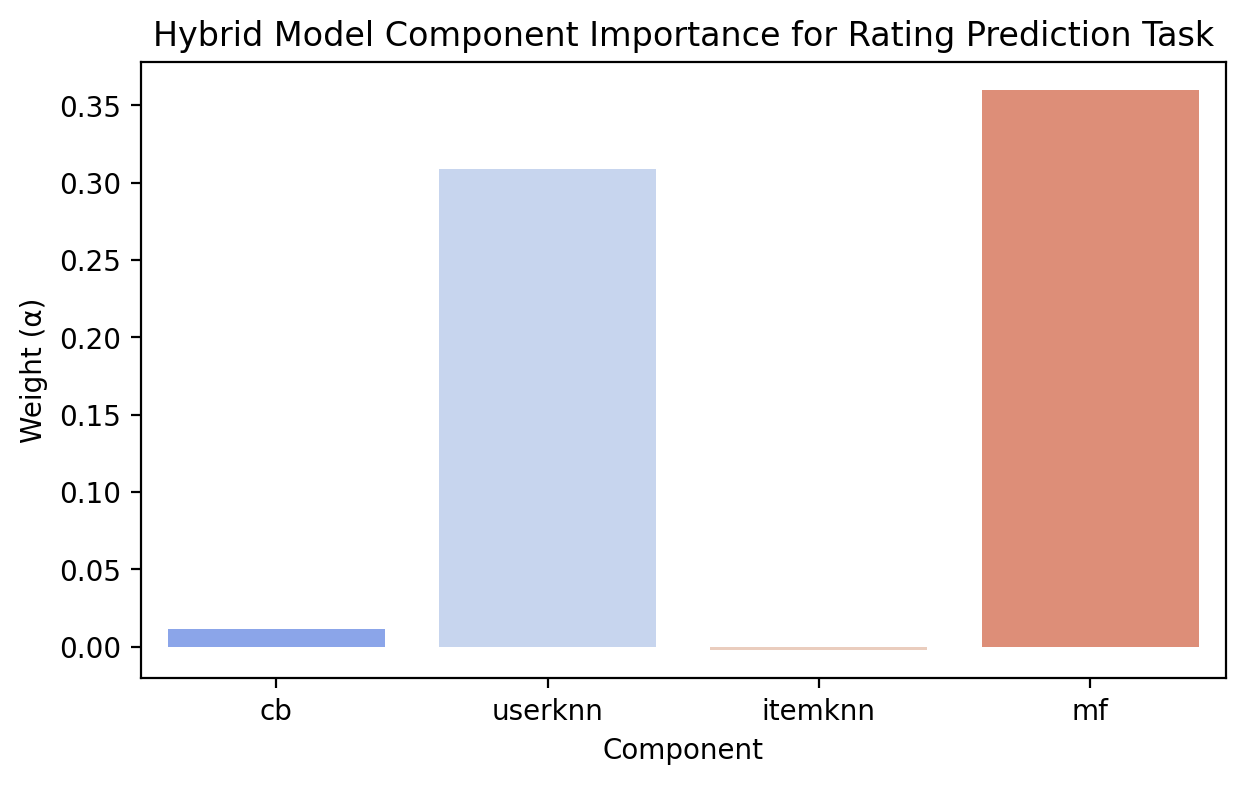

In [82]:
plt.figure(figsize=(7,4), dpi=200)
sns.barplot(data=hybrid_rating_coeff, x='Component', y='Alpha (Weight)', palette='coolwarm')
plt.title('Hybrid Model Component Importance for Rating Prediction Task')
plt.ylabel('Weight (α)')
plt.show()

**Analysis**

- MF (0.36) dominates, as expected — it’s excellent at modeling user–item rating patterns.
- UserKNN (0.31) still provides complementary information about local neighborhood similarities.
- ItemKNN contributes almost nothing — likely redundant with MF and user-based CF.
- Content-based is negligible — explicit ratings are driven more by collaborative patterns than by item content.

**Conclusion**

For rating prediction, the hybrid model relies mainly on MF and UserKNN, with MF being slightly more influential.

### 4.1.2 Ranking predictions

In [83]:
hybrid_ranking_coeff

,Component,Weight (α)
0,cb,0.147470
1,userknn,0.105903
2,itemknn,0.146330
3,mf,0.390037
4,bpr,0.304784


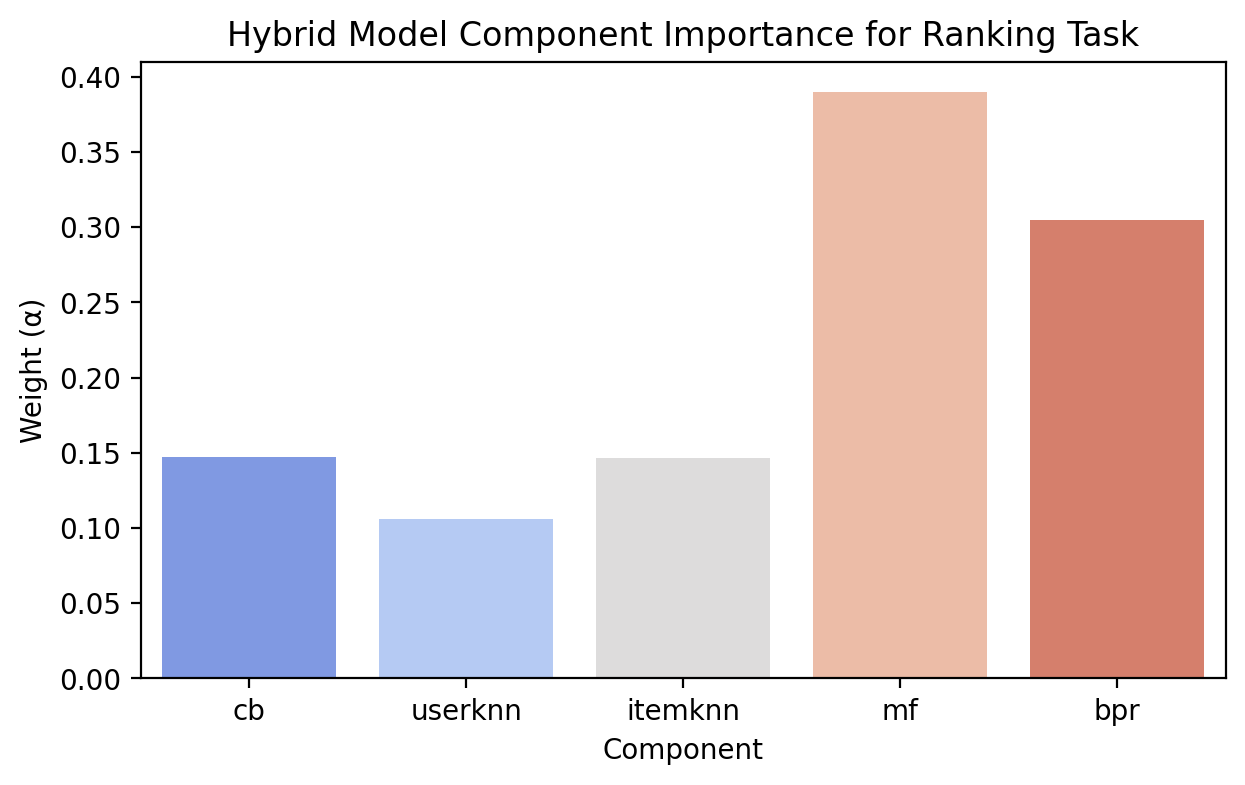

In [84]:
plt.figure(figsize=(7,4), dpi=200)
sns.barplot(data=hybrid_ranking_coeff, x='Component', y='Weight (α)', palette='coolwarm')
plt.title('Hybrid Model Component Importance for Ranking Task')
plt.ylabel('Weight (α)')
plt.show()

**Analysis**

- BPR (0.46) has the highest coefficient — consistent with its design as a ranking-optimized model (pairwise loss).
- MF (0.26) and UserKNN (0.29) provide secondary signals; both capture collaborative structure.
- Content-based (0.11) and ItemKNN (0.09) offer additional diversity (especially helpful for cold-start and diversity).

**Conclusion**

- For ranking tasks, the hybrid model relies primarily on BPR, followed by UserKNN and MF.
- Content-based and ItemKNN models make smaller but complementary contributions.

## 4.2 User Group Analysis on Ranking Task

Group users by **activity level** (user behaviour length)

In [85]:
def evaluate_by_user_group_ranking(
    train_data,
    test_data,
    user_similarity_matrix,
    item_similarity_matrix,
    mf_model,
    bpr_model,
    device="cpu",
    k_recall=10,
    user_bins=[0, 10, 50, 200, np.inf],
    k_user=70,
    k_item=20,
):
    """
    Evaluate ranking metrics (Precision@K, Recall@K, NDCG@K, MAP@K)
    for CB, UserKNN, ItemKNN, MF, and BPR models by user group.
    """

    results = []

    # 1 Split users by activity
    user_counts = train_data.groupby("user_id").size()
    user_groups = pd.cut(
        user_counts,
        bins=user_bins,
        labels=["cold", "light", "medium", "heavy"]
    )

    global_mean_rating = train_data["rating"].mean()
    all_items = test_data["item_id"].unique()

    # 2 Evaluate per group
    for group_name, group_users in user_groups.groupby(user_groups):
        group_user_ids = group_users.index.tolist()
        subset = test_data[test_data["user_id"].isin(group_user_ids)]
        if subset.empty:
            continue

        group_result = {"group": group_name}

        # 3 Evaluate each model
        for model_name in ["cb", "userknn", "itemknn", "mf", "bpr"]:
            precisions, recalls, ndcgs, maps = [], [], [], []

            for user_id in tqdm(group_user_ids, desc=f"Group {group_name} - {model_name}", leave=False):
                true_items = test_data[test_data["user_id"] == user_id]["item_id"].tolist()
                if len(true_items) == 0:
                    continue

                # Candidate items (exclude those seen in train)
                user_train_items = train_data[train_data["user_id"] == user_id]["item_id"].tolist()
                candidates = [i for i in all_items if i not in user_train_items]

                scores = []
                for item_id in candidates:
                    try:
                        if model_name == "cb":
                            score = get_user_item_prediction_content_based(
                                train_data,
                                user_id,
                                item_id,
                                best_content_type_cb,
                                best_aggregation_method_cb,
                            )
                        elif model_name == "userknn":
                            score = predict_rating_user_based(
                                train_data, user_similarity_matrix,
                                user_id, item_id, global_mean_rating, k=k_user
                            )
                        elif model_name == "itemknn":
                            score = predict_rating_item_based(
                                train_data, item_similarity_matrix,
                                user_id, item_id, k=k_item
                            )
                        elif model_name == "mf":
                            score = mf_model.predict(user_id, item_id)
                        elif model_name == "bpr":
                            with torch.no_grad():
                                score = bpr_model.model.predict(
                                    torch.LongTensor([user_id - 1]).to(device),
                                    torch.LongTensor([item_id - 1]).to(device)
                                ).item()
                        else:
                            continue
                        scores.append((item_id, score))
                    except Exception:
                        continue

                if len(scores) == 0:
                    continue

                ranked_items = [i for i, _ in sorted(scores, key=lambda x: x[1], reverse=True)]

                precisions.append(precision_at_k(true_items, ranked_items, k=k_recall))
                recalls.append(recall_at_k(true_items, ranked_items, k=k_recall))
                ndcgs.append(ndcg_at_k(true_items, ranked_items, k=k_recall))
                maps.append(average_precision_at_k(true_items, ranked_items, k=k_recall))

            # Aggregate metrics
            group_result[f"{model_name}_Precision@{k_recall}"] = np.nanmean(precisions)
            group_result[f"{model_name}_Recall@{k_recall}"] = np.nanmean(recalls)
            group_result[f"{model_name}_NDCG@{k_recall}"] = np.nanmean(ndcgs)
            group_result[f"{model_name}_MAP@{k_recall}"] = np.nanmean(maps)

        results.append(group_result)

    results_df = pd.DataFrame(results)
    print("Multi-metric ranking evaluation completed by user group.")
    return results_df

In [86]:
"""====== MORE THAN 1 HOUR IS NEEDED TO RUN THE CODE BELOW ======"""
# results_multi_metric = evaluate_by_user_group_ranking(
#     train_data=train_data,
#     test_data=test_data,
#     user_similarity_matrix=user_similarity_matrix,
#     item_similarity_matrix=item_similarity_matrix,
#     mf_model=mf_model,
#     bpr_model=bpr_model,
#     device=device,
#     k_recall=10
# )

# results_multi_metric

'====== MORE THAN 1 HOUR IS NEEDED TO RUN THE CODE BELOW ======'

In [87]:
# results_multi_metric.to_csv(os.path.join(OUTPUTS_PATH, 'user_group_analysis.csv'))

In [88]:
"""====== LOAD THE RESULTS INSTEAD ======"""
results_multi_metric = pd.read_csv(os.path.join(OUTPUTS_PATH, 'user_group_analysis.csv'))
results_multi_metric

,Unnamed: 0,group,cb_Precision@10,cb_Recall@10,cb_NDCG@10,cb_MAP@10,userknn_Precision@10,userknn_Recall@10,userknn_NDCG@10,userknn_MAP@10,...,itemknn_NDCG@10,itemknn_MAP@10,mf_Precision@10,mf_Recall@10,mf_NDCG@10,mf_MAP@10,bpr_Precision@10,bpr_Recall@10,bpr_NDCG@10,bpr_MAP@10
0,0,cold,0.024074,0.017590,0.033239,0.017500,0.005556,0.003851,0.004341,0.000933,...,0.000000,0.000000,0.101852,0.083877,0.121655,0.055684,0.248148,0.213163,0.278272,0.144880
1,1,light,0.044444,0.018381,0.052042,0.019580,0.017094,0.007192,0.018566,0.006803,...,0.005138,0.001266,0.123932,0.059583,0.134890,0.060637,0.261111,0.149611,0.295307,0.164279
2,2,medium,0.140385,0.020271,0.139797,0.058889,0.025000,0.002924,0.027408,0.011847,...,0.075306,0.028301,0.257051,0.035271,0.254756,0.136776,0.449359,0.066339,0.474766,0.322713
3,3,heavy,0.186667,0.015079,0.193302,0.090352,0.033333,0.003954,0.033063,0.010786,...,0.034235,0.013500,0.353333,0.032885,0.386223,0.248661,0.506667,0.056305,0.515773,0.360026


In [89]:
def plot_ranking_metrics_by_group(results_df, k=10, save_path=None):
    """
    Plot grouped bar charts for Precision@K, Recall@K, NDCG@K, and MAP@K.
    """
    metrics = [f"Precision@{k}", f"Recall@{k}", f"NDCG@{k}", f"MAP@{k}"]
    models = ["cb", "userknn", "itemknn", "mf", "bpr"]

    # Melt dataframe for plotting
    plot_data = []
    for _, row in results_df.iterrows():
        group = row["group"]
        for model in models:
            for metric in metrics:
                col = f"{model}_{metric}"
                if col in row:
                    plot_data.append({
                        "Group": group,
                        "Model": model.upper(),
                        "Metric": metric.replace(f"@{k}", ""),
                        "Value": row[col]
                    })

    df_plot = pd.DataFrame(plot_data)

    # Seaborn style setup
    sns.set(style="whitegrid", font_scale=1.1)
    plt.figure(figsize=(16, 10), dpi=400)

    # Plot 4 metrics separately
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        subset = df_plot[df_plot["Metric"] == metric.replace(f"@{k}", "")]
        sns.barplot(data=subset, x="Group", y="Value", hue="Model")
        plt.title(metric)
        plt.ylabel("Score")
        plt.xlabel("User Group")
        plt.legend(title="Model", loc="upper right")

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"✅ Plot saved to {save_path}")
    else:
        plt.show()

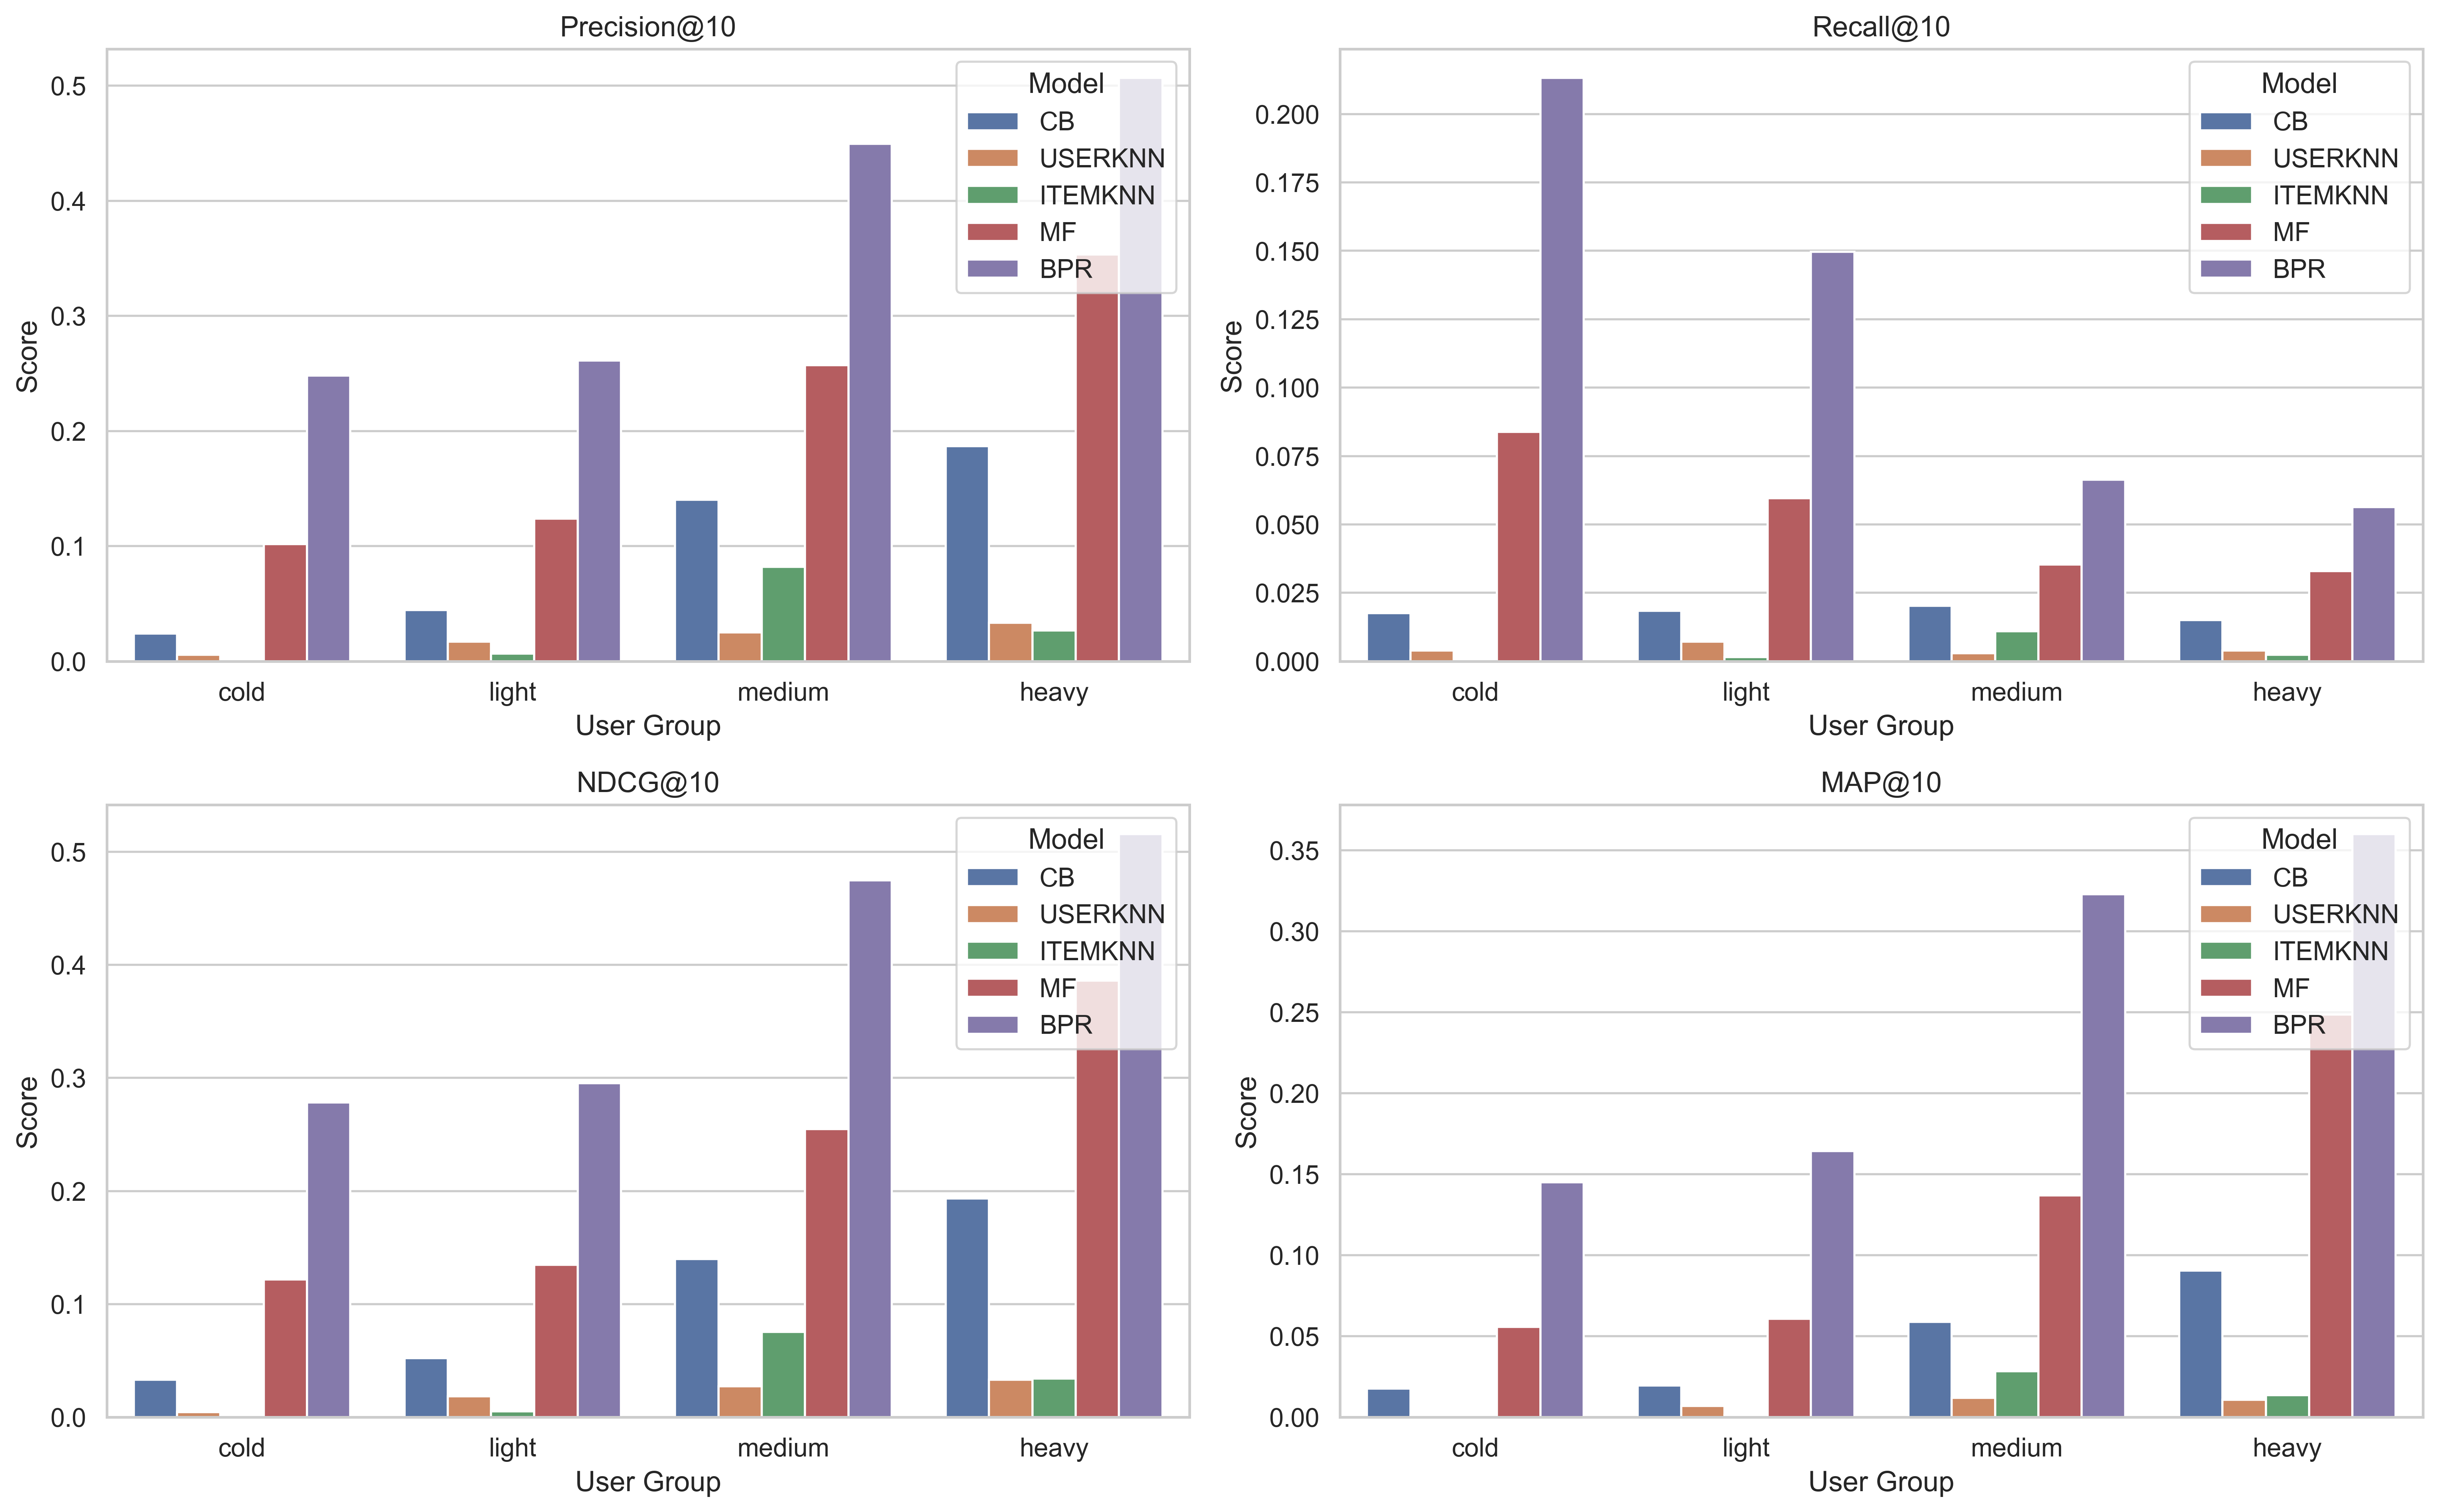

In [90]:
plot_ranking_metrics_by_group(results_multi_metric, k=10)

**Conclusion**

In this case, **most metrics (Precision, NDCG, MAP)** show that recommendation accuracy increases with user activity —
**heavy users > medium > light > cold**,
meaning models perform best for users with more interactions, since their preferences are easier to learn.

However, **Recall** shows the opposite trend (**cold > light > medium > heavy**), indicating that although models make less precise predictions for cold users, they still retrieve a larger portion of relevant items — <u>possibly because cold users have fewer total relevant items, making it easier to achieve higher recall</u>.

👉 **Summary:**

* **Best performance (overall accuracy):** Heavy users
* **Highest recall:** Cold users

# Task 5) Evaluation of beyond accuracy

## Diversity (intra-list diversity)

**Intra-List Diversity (ILD)** quantifies how *different* the items within a single user’s recommendation list are from each other.

Formally:

$$
\text{ILD}(u) = \frac{1}{|L_u|(|L_u|-1)} \sum_{i \ne j} \bigl(1 - \text{sim}(i,j)\bigr)
$$

where `sim(i,j)` is cosine similarity between item embeddings (here, BERT item representations).
Then we average across users to get the final ILD score.

* **High ILD (close to 1)** → items are *very dissimilar* → *diverse recommendations* (e.g., a mix of action, romance, and comedy movies).
* **Low ILD (close to 0)** → items are *very similar* → *homogeneous recommendations* (e.g., 10 action movies with similar plots).



In [91]:
# # FORCE ALL MODELS AND TENSORS BACK TO THE GPU (DirectML)
# print("Forcing all PyTorch models and device to the global 'device' (GPU/DirectML)...")
#
# # 1. The 'device' variable should be DirectML device from the setup cell.
# if "privateuseone" not in str(device):
#      print(f"WARNING: The global 'device' is {device}. This might not be your GPU.")
#      print("Please re-run the 'Setup' cell at the top of the notebook if this is wrong.")
#
# # 2. Force MF model to GPU
# try:
#     mf_model.device = device  # Reset internal device
#     mf_model.model.to(device) # Move model parameters
#     print(f"MF model device set to: {mf_model.device}")
#     print(f"MF model.model is on: {next(mf_model.model.parameters()).device}")
# except Exception as e:
#     print(f"Error setting MF model: {e}")
#
# # 3. Force BPR model to GPU
# try:
#     bpr_model.device = device  # Reset internal device
#     bpr_model.model.to(device) # Move model parameters
#     print(f"BPR model device set to: {bpr_model.device}")
#     print(f"BPR model.model is on: {next(bpr_model.model.parameters()).device}")
# except Exception as e:
#     print(f"Error setting BPR model: {e}")
#
# print("All models forced to global 'device'.")

In [92]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_ild_for_list(item_ids, item_embeddings):
    """
    Calculates the Intra-List Diversity (ILD) for a single list of item IDs.
    ILD is the average pairwise distance (1 - cosine_similarity) between items.

    Args:
        item_ids (list): List of item IDs (1-indexed).
        item_embeddings (np.ndarray): Full item embedding matrix (0-indexed).

    Returns:
        float: The ILD score for the list, or np.nan if k < 2.
    """
    k = len(item_ids)
    if k < 2:
        # Diversity is undefined for lists with 0 or 1 item
        return np.nan

    # Get the 0-indexed indices for the embedding matrix
    try:
        indices = [item_id - 1 for item_id in item_ids]
        # Retrieve the embeddings for the items in the list
        list_embeddings = item_embeddings[indices]
    except IndexError:
        print(f"Error: Item ID out of bounds. Max index: {len(item_embeddings)-1}, Got: {max(indices)}")
        return np.nan
    except TypeError:
        print(f"Error: Invalid item_ids: {item_ids}")
        return np.nan


    # Calculate pairwise cosine similarity -> (k, k) matrix
    sim_matrix = cosine_similarity(list_embeddings)

    # Calculate distance matrix (1 - similarity)
    dist_matrix = 1.0 - sim_matrix

    # Get the indices for the upper triangle (excluding the diagonal)
    # k=1 means we don't include the diagonal (distance from item to itself)
    upper_triangle_indices = np.triu_indices(k, 1)

    # Sum all unique pairwise distances
    total_distance_sum = np.sum(dist_matrix[upper_triangle_indices])

    # Calculate the number of unique pairs
    num_pairs = k * (k - 1) / 2.0

    if num_pairs == 0:
        return np.nan

    # The average distance is the total sum divided by the number of pairs
    return total_distance_sum / num_pairs

In [93]:
def evaluate_diversity_all_models(
    train_data,
    test_data,
    item_embeddings, # Pass item_emb_full here
    user_similarity_matrix,
    item_similarity_matrix,
    mf_model,
    bpr_model,
    hybrid_rank_model, # The trained ranking model
    k=10,
    device=device,
    sample_users = None
):
    """
    Evaluates Intra-List Diversity (ILD) @ k for all models.
    """
    test_users = test_data["user_id"].unique()

    all_test_users = test_data["user_id"].unique()

    if sample_users is not None and sample_users < len(all_test_users):
        print(f"Sampling {sample_users} users for evaluation...")
        test_users = np.random.choice(all_test_users, size=sample_users, replace=False)
    else:
        test_users = all_test_users

    # Use best hyperparameters from tuning
    k_user = best_k_user
    k_item = best_k_item
    content_type = content_based_tuning['best_config'][0]
    agg_method = content_based_tuning['best_config'][1]

    model_names = [
        "Content-Based",
        "User-Based KNN",
        "Item-Based KNN",
        "Matrix Factorization",
        "BPR Model",
        "Hybrid Ranking"
    ]
    ild_scores = {model_name: [] for model_name in model_names}

    for user_id in tqdm(test_users, desc="Evaluating Diversity (ILD)"):

        # --- Content-Based ---
        recs_cb = recommend_topk_content_based(train_data, user_id, k, content_type, agg_method)
        recs_cb_ids = [item_id for item_id, score in recs_cb]
        ild_scores["Content-Based"].append(calculate_ild_for_list(recs_cb_ids, item_embeddings))

        # --- User-Based KNN ---
        recs_ub = recommend_topk_user_based(train_data, user_similarity_matrix, user_id, k_user, k)
        recs_ub_ids = [item_id for item_id, score in recs_ub]
        ild_scores["User-Based KNN"].append(calculate_ild_for_list(recs_ub_ids, item_embeddings))

        # --- Item-Based KNN ---
        recs_ib = recommend_topk_item_based(train_data, item_similarity_matrix, user_id, k_item, k)
        recs_ib_ids = [item_id for item_id, score in recs_ib]
        ild_scores["Item-Based KNN"].append(calculate_ild_for_list(recs_ib_ids, item_embeddings))

        # --- Matrix Factorization ---
        recs_mf_ids = recommend_topk_mf(mf_model, train_data, user_id, k)
        ild_scores["Matrix Factorization"].append(calculate_ild_for_list(recs_mf_ids, item_embeddings))

        # --- BPR Model ---
        recs_bpr = bpr_model.recommend(user_id, train_data, k)
        recs_bpr_ids = [item_id for item_id, score in recs_bpr]
        ild_scores["BPR Model"].append(calculate_ild_for_list(recs_bpr_ids, item_embeddings))

        # --- Hybrid Ranking Model ---
        recs_hybrid = recommend_topk_hybrid_ranking(
            user_id, hybrid_rank_model, train_data,
            item_similarity_matrix, user_similarity_matrix,
            mf_model, bpr_model, k_item=k_item, k_user=k_user, top_k=k, device=device
        )
        recs_hybrid_ids = [item_id for item_id, score in recs_hybrid]
        ild_scores["Hybrid Ranking"].append(calculate_ild_for_list(recs_hybrid_ids, item_embeddings))

    # --- Calculate Averages ---
    final_results = {}
    for model_name, scores in ild_scores.items():
        # Use np.nanmean to safely ignore NaNs from lists with < 2 items
        final_results[model_name] = np.nanmean(scores)

    results_df = pd.DataFrame(list(final_results.items()), columns=["Model", "ILD @ 10"])
    results_df = results_df.sort_values("ILD @ 10", ascending=False)

    return results_df

In [94]:
# Ensure all models are loaded/trained:
# mf_model, bpr_model, hybrid_rank_model
# item_emb_full, user_similarity_matrix, item_similarity_matrix
# best_k_user, best_k_item, content_based_tuning

print("Starting Intra-List Diversity (ILD) evaluation...")

diversity_results_df = evaluate_diversity_all_models(
    train_data=train_data,
    test_data=test_data,
    item_embeddings=item_emb_full,
    user_similarity_matrix=user_similarity_matrix,
    item_similarity_matrix=item_similarity_matrix,
    mf_model=mf_model,
    bpr_model=bpr_model,
    hybrid_rank_model=hybrid_rank_model,
    k=10,
    device=device,
    sample_users = 10
)

print("\n--- Model Diversity (ILD @ 10) ---")
display(diversity_results_df)

Starting Intra-List Diversity (ILD) evaluation...
Sampling 10 users for evaluation...


Evaluating Diversity (ILD): 100%|██████████| 10/10 [34:16<00:00, 205.67s/it] 


--- Model Diversity (ILD @ 10) ---


,Model,ILD @ 10
2,Item-Based KNN,0.113949
1,User-Based KNN,0.097686
0,Content-Based,0.079389
4,BPR Model,0.073615
3,Matrix Factorization,0.071165
5,Hybrid Ranking,0.068855


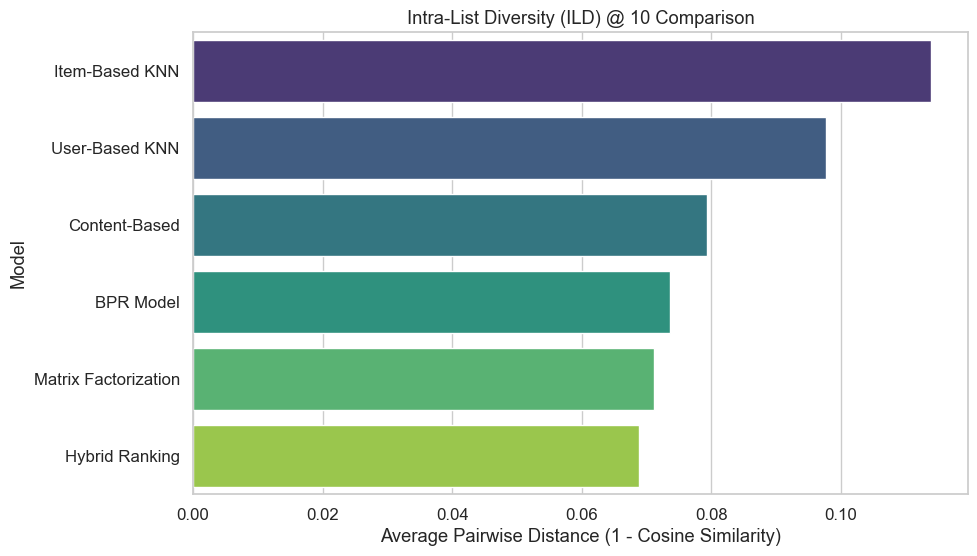

In [95]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=diversity_results_df,
    x="ILD @ 10",
    y="Model",
    palette="viridis"
)
plt.title("Intra-List Diversity (ILD) @ 10 Comparison")
plt.xlabel("Average Pairwise Distance (1 - Cosine Similarity)")
plt.ylabel("Model")
plt.show()

- Best Performers: Item-Based KNN and User-Based KNN provide the most diverse recommendations. The items within their lists are, on average, the most different from each other based on their content embeddings.
- Worst Performers: Hybrid Ranking, BPR Model, and Matrix Factorization produce the least diverse lists. Their recommended items tend to be more similar to each other.
- Interpretation: KNN methods often explore the item space more broadly through neighbourhood connections, potentially picking up less mainstream or varied items, leading to higher diversity. MF, BPR, and the Hybrid model might focus more strongly on popular items or latent features representing core user interests, resulting in more homogeneous lists. Content-Based sits in the middle.

## Novelty (surprisal)

Measure each item’s novelty as:

$$
\text{novelty}(i) = -\log_2 p(i)
\quad\text{with}\quad
p(i) = \frac{\#\text{interactions on } i}{\text{total interactions}}
$$


A user’s novelty is the **mean** surprisal of the items in their recommended list, and finally average across users.

In [96]:
print("Calculating item novelty scores...")

# 1. Get total interactions from train_data
total_interactions = len(train_data)

# 2. Get interaction count for each item
item_counts = train_data['item_id'].value_counts()

# 3. Calculate p(i) for each item
item_popularity_p = item_counts / total_interactions

# 4. Calculate novelty(i) = -log2(p(i))
# This is a pd.Series, which works as a fast lookup table
item_novelty_lookup = -np.log2(item_popularity_p)

# 5. Calculate the novelty for an item with 0 interactions in the training set.
# If a model recommends an item not in train_data, it's very novel.
# We'll assign it the novelty of an item seen only once.
# Novelty for 1 interaction = -log2(1 / total_interactions) = log2(total_interactions)
max_novelty = np.log2(total_interactions)

print(f"Total interactions: {total_interactions}")
print("Novelty lookup table created.")
print(f"Novelty for 1 interaction (max): {max_novelty:.4f}")
print("---")
print("Most popular items (lowest novelty):")
print(item_novelty_lookup.sort_values().head())
print("---")
print("Least popular items (highest novelty):")
print(item_novelty_lookup.sort_values().tail())
print(item_novelty_lookup)

Calculating item novelty scores...
Total interactions: 64000
Novelty lookup table created.
Novelty for 1 interaction (max): 15.9658
---
Most popular items (lowest novelty):
item_id
50     7.343732
181    7.543720
258    7.599462
100    7.648372
1      7.675765
Name: count, dtype: float64
---
Least popular items (highest novelty):
item_id
1626    15.965784
1390    15.965784
1674    15.965784
1318    15.965784
1317    15.965784
Name: count, dtype: float64
item_id
50       7.343732
181      7.543720
258      7.599462
100      7.648372
1        7.675765
          ...    
1682    15.965784
1662    15.965784
1627    15.965784
1618    15.965784
1317    15.965784
Name: count, Length: 1615, dtype: float64


In [97]:
def calculate_novelty_for_list(item_ids, item_novelty_lookup, max_novelty):
    """
    Calculates the average novelty for a single list of item IDs.

    Args:
        item_ids (list): List of item IDs (1-indexed).
        item_novelty_lookup (pd.Series): Lookup table of novelty scores.
        max_novelty (float): The novelty score to assign to items
                             not found in the lookup (e.g., 0-interaction items).

    Returns:
        float: The average novelty for the list, or np.nan if list is empty.
    """
    if not item_ids:
        return np.nan

    novelty_scores = []
    for item_id in item_ids:
        # Get the pre-calculated novelty score.
        # If item_id is not in the lookup, it's a very rare/new item.
        # We assign it the max_novelty score.
        score = item_novelty_lookup.get(item_id, max_novelty)
        novelty_scores.append(score)

    # Return the average novelty for the list
    return np.mean(novelty_scores)

In [98]:
def evaluate_novelty_all_models(
    train_data,
    test_data,
    item_novelty_lookup, # Pass the novelty lookup
    max_novelty,         # Pass the max novelty
    user_similarity_matrix,
    item_similarity_matrix,
    mf_model,
    bpr_model,
    hybrid_rank_model, # The trained ranking model
    k=10,
    device=device,
    sample_users = None
):
    """
    Evaluates Novelty (Surprisal) @ k for all models.
    """
    all_test_users = test_data["user_id"].unique()

    if sample_users is not None and sample_users < len(all_test_users):
        print(f"Sampling {sample_users} users for evaluation...")
        test_users = np.random.choice(all_test_users, size=sample_users, replace=False)
    else:
        test_users = all_test_users

    # Use best hyperparameters from tuning
    k_user = best_k_user
    k_item = best_k_item
    content_type = content_based_tuning['best_config'][0]
    agg_method = content_based_tuning['best_config'][1]

    model_names = [
        "Content-Based",
        "User-Based KNN",
        "Item-Based KNN",
        "Matrix Factorization",
        "BPR Model",
        "Hybrid Ranking"
    ]
    novelty_scores = {model_name: [] for model_name in model_names}

    for user_id in tqdm(test_users, desc="Evaluating Novelty"):

        # --- Content-Based ---
        recs_cb = recommend_topk_content_based(train_data, user_id, k, content_type, agg_method)
        recs_cb_ids = [item_id for item_id, score in recs_cb]
        novelty_scores["Content-Based"].append(calculate_novelty_for_list(recs_cb_ids, item_novelty_lookup, max_novelty))

        # --- User-Based KNN ---
        recs_ub = recommend_topk_user_based(train_data, user_similarity_matrix, user_id, k_user, k)
        recs_ub_ids = [item_id for item_id, score in recs_ub]
        novelty_scores["User-Based KNN"].append(calculate_novelty_for_list(recs_ub_ids, item_novelty_lookup, max_novelty))

        # --- Item-Based KNN ---
        recs_ib = recommend_topk_item_based(train_data, item_similarity_matrix, user_id, k_item, k)
        recs_ib_ids = [item_id for item_id, score in recs_ib]
        novelty_scores["Item-Based KNN"].append(calculate_novelty_for_list(recs_ib_ids, item_novelty_lookup, max_novelty))

        # --- Matrix Factorization ---
        recs_mf_ids = recommend_topk_mf(mf_model, train_data, user_id, k)
        novelty_scores["Matrix Factorization"].append(calculate_novelty_for_list(recs_mf_ids, item_novelty_lookup, max_novelty))

        # --- BPR Model ---
        recs_bpr = bpr_model.recommend(user_id, train_data, k)
        recs_bpr_ids = [item_id for item_id, score in recs_bpr]
        novelty_scores["BPR Model"].append(calculate_novelty_for_list(recs_bpr_ids, item_novelty_lookup, max_novelty))

        # --- Hybrid Ranking Model ---
        recs_hybrid = recommend_topk_hybrid_ranking(
            user_id, hybrid_rank_model, train_data,
            item_similarity_matrix, user_similarity_matrix,
            mf_model, bpr_model, k_item=k_item, k_user=k_user, top_k=k, device=device
        )
        recs_hybrid_ids = [item_id for item_id, score in recs_hybrid]
        novelty_scores["Hybrid Ranking"].append(calculate_novelty_for_list(recs_hybrid_ids, item_novelty_lookup, max_novelty))

    # --- Calculate Averages ---
    final_results = {}
    for model_name, scores in novelty_scores.items():
        final_results[model_name] = np.nanmean(scores)

    results_df = pd.DataFrame(list(final_results.items()), columns=["Model", "Novelty @ 10"])
    results_df = results_df.sort_values("Novelty @ 10", ascending=False)

    return results_df

In [99]:
print("Starting Novelty (Surprisal) evaluation...")

# Note: We use sample_users=10 for a quick test.
novelty_results_df = evaluate_novelty_all_models(
    train_data=train_data,
    test_data=test_data,
    item_novelty_lookup=item_novelty_lookup,
    max_novelty=max_novelty,
    user_similarity_matrix=user_similarity_matrix,
    item_similarity_matrix=item_similarity_matrix,
    mf_model=mf_model,
    bpr_model=bpr_model,
    hybrid_rank_model=hybrid_rank_model,
    k=10,
    device=device,
    sample_users = 10
)

print("\n--- Model Novelty (Surprisal) @ 10 ---")
display(novelty_results_df)

Starting Novelty (Surprisal) evaluation...
Sampling 10 users for evaluation...


Evaluating Novelty: 100%|██████████| 10/10 [19:54<00:00, 119.45s/it]


--- Model Novelty (Surprisal) @ 10 ---


,Model,Novelty @ 10
2,Item-Based KNN,15.231750
1,User-Based KNN,13.586551
0,Content-Based,11.940035
3,Matrix Factorization,9.035688
5,Hybrid Ranking,8.302327
4,BPR Model,7.926715


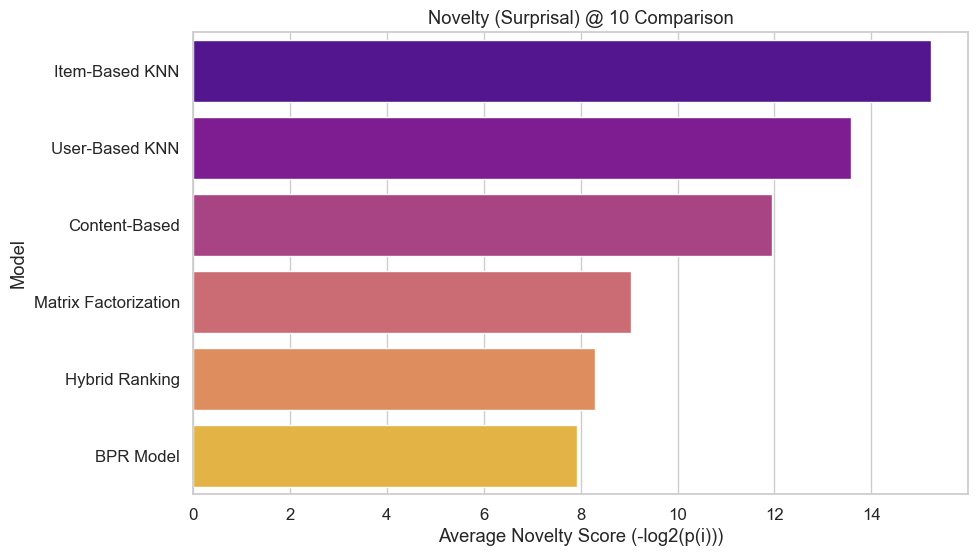

In [100]:
# --- Plot the results ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=novelty_results_df,
    x="Novelty @ 10",
    y="Model",
    palette="plasma"
)
plt.title("Novelty (Surprisal) @ 10 Comparison")
plt.xlabel("Average Novelty Score (-log2(p(i)))")
plt.ylabel("Model")
plt.show()

- Best Performers: Item-Based KNN and User-Based KNN recommend the most novel items (least popular).

- Worst Performers: BPR Model, Hybrid Ranking, and Matrix Factorization recommend the least novel items (most popular).

- Interpretation: This strongly correlates with diversity. KNN methods, by exploring neighbours, are more likely to recommend less popular items that specific neighbours liked. MF and BPR models often have an inherent bias towards popular items due to more data supporting their latent factors, leading to lower novelty recommendations. The Hybrid model inherits this trait. Content-based is again moderate.

## Calibration

The goal is to measure how well the genre distribution of a user's recommendation list ($q(g|u)$) matches the genre distribution of their interaction history ($p(g|u)$). We'll use the Kullback-Leibler (KL) divergence as the miscalibration score, where lower scores indicate better calibration.

### Get Item-Genre distribitions

In [101]:
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import entropy # For KL Divergence
import re # Import regex

print("Preparing item-genre distributions p(g|i)...")

# --- THOROUGH CLEANING STEP ---
def standardize_and_split_genres(genre_string):
    if pd.isna(genre_string) or genre_string == '':
        return []
    # Replace common separators (like ', ') with '|'
    cleaned = re.sub(r'\s*,\s*', '|', str(genre_string))
    # Replace multiple pipes with single pipes
    cleaned = re.sub(r'\|+', '|', cleaned)
    # Split by '|'
    genres = [g.strip() for g in cleaned.split('|')]
    # Filter out empty strings and specific unwanted values
    unwanted = {'', '(no genres listed)', 'unknown'}
    return sorted([g for g in genres if g and g not in unwanted]) # Sort for consistency

# Apply the cleaning function
movies['genres_list_cleaned'] = movies['genres'].apply(standardize_and_split_genres)
print("\nCleaned genres for item_id=1:", movies.loc[movies['item_id'] == 1, 'genres_list_cleaned'].iloc[0])

# Get all unique *individual* genres from the cleaned lists
all_individual_genres = sorted(list(set(g for genre_list in movies['genres_list_cleaned'] for g in genre_list)))
print(f"\nFound {len(all_individual_genres)} unique individual genres after cleaning:")
print(all_individual_genres)
if len(all_individual_genres) > 30 or len(all_individual_genres) < 15:
     print("WARNING: Unusual number of genres found. Check the list above.")
# --- END CLEANING STEP ---


# --- BINARIZING STEP ---
# Initialize ONLY with the individual genres
mlb = MultiLabelBinarizer(classes=all_individual_genres)

# Fit and transform using the CLEANED lists of individual genres
genre_matrix = mlb.fit_transform(movies['genres_list_cleaned'])

# Create DataFrame with item_id index and individual genre columns
item_genre_df = pd.DataFrame(genre_matrix, index=movies['item_id'], columns=mlb.classes_)

print("\nItem-Genre DataFrame columns (should be individual genres):")
print(item_genre_df.columns.tolist())
print("\nItem-Genre DataFrame head(1) (showing binary presence):")
print(item_genre_df.head(1)) # Should show 1s for Animation, Children's, Comedy

# --- NORMALIZATION STEP ---
# Normalize each row (item) to get p(g|i)
# Each genre present gets probability 1 / (num_genres_for_item)
item_p_g_i = item_genre_df.apply(lambda row: row / (row.sum() + 1e-9), axis=1) # Add epsilon to avoid 0/0

print("\nItem-genre distribution p(g|i) calculated.")
print(f"Shape: {item_p_g_i.shape}") # Shape should now be (1682, ~18)
print("\nExample p(g|i) for item_id=1 (Toy Story) AFTER NORMALIZATION:")
# Should show ~0.333 for Animation, Children's, Comedy
print(item_p_g_i.loc[1][item_p_g_i.loc[1] > 0])

Preparing item-genre distributions p(g|i)...

Cleaned genres for item_id=1: ['Animation', "Children's", 'Comedy']

Found 18 unique individual genres after cleaning:
['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

Item-Genre DataFrame columns (should be individual genres):
['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

Item-Genre DataFrame head(1) (showing binary presence):
         Action  Adventure  Animation  Children's  Comedy  Crime  Documentary  \
item_id                                                                         
1             0          0          1           1       1      0            0   

         Drama  Fantasy  Film-Noir  Horror  Musical  Mystery  Romance  

This information is confirmed by the `u.genre` file found at https://files.grouplens.org/datasets/movielens/ml-100k/

### Helper Functions for User Profile ($p(g|u)$) and List Distribution ($q(g|u)$)

In [102]:
def calculate_user_profile_p_g_u(user_id, train_data, item_p_g_i):
    """
    Calculates the genre distribution p(g|u) for a user based on their
    training history, weighted by ratings.

    Args:
        user_id (int): The target user ID.
        train_data (pd.DataFrame): Training data.
        item_p_g_i (pd.DataFrame): Item-genre distributions.

    Returns:
        pd.Series: The user's genre preference distribution p(g|u),
                   or None if the user has no history or history items lack genres.
    """
    user_history = train_data[train_data['user_id'] == user_id]
    if user_history.empty:
        return None

    # Get item IDs and ratings from history
    history_items = user_history['item_id'].tolist()
    history_ratings = user_history['rating'].tolist()

    # Filter out items not present in item_p_g_i (if any)
    valid_items_mask = [item in item_p_g_i.index for item in history_items]
    history_items = [item for i, item in enumerate(history_items) if valid_items_mask[i]]
    history_ratings = [rating for i, rating in enumerate(history_ratings) if valid_items_mask[i]]

    if not history_items:
        return None # No valid items with genres in history

    # Get the p(g|i) distributions for the history items
    history_pgi = item_p_g_i.loc[history_items]

    # Calculate weighted average: sum(rating * p(g|i)) / sum(rating) [cite: 116]
    weighted_pgi_sum = history_pgi.multiply(history_ratings, axis=0).sum(axis=0)
    total_rating_sum = sum(history_ratings)

    if total_rating_sum == 0:
        # Avoid division by zero, return uniform distribution or average
        # Returning average profile for simplicity here
         return history_pgi.mean(axis=0)


    user_p_g_u = weighted_pgi_sum / total_rating_sum
    # Ensure it sums to 1 (due to potential floating point inaccuracies)
    user_p_g_u = user_p_g_u / user_p_g_u.sum()

    return user_p_g_u


def calculate_list_distribution_q_g_u(item_ids, item_p_g_i):
    """
    Calculates the genre distribution q(g|u) for a list of recommended items.
    Uses simple averaging (equal weights).

    Args:
        item_ids (list): List of recommended item IDs.
        item_p_g_i (pd.DataFrame): Item-genre distributions.

    Returns:
        pd.Series: The list's genre distribution q(g|u),
                   or None if the list is empty or items lack genres.
    """
    if not item_ids:
        return None

    # Filter out items not present in item_p_g_i (if any)
    valid_items = [item for item in item_ids if item in item_p_g_i.index]

    if not valid_items:
        return None # No valid items with genres in the list

    # Get the p(g|i) distributions for the items
    list_pgi = item_p_g_i.loc[valid_items]

    # Calculate the average distribution: mean(p(g|i))
    list_q_g_u = list_pgi.mean(axis=0)
    # Ensure it sums to 1
    list_q_g_u = list_q_g_u / list_q_g_u.sum()

    return list_q_g_u

### KL Divergence (Miscalibration) Function

In [103]:
def calculate_kl_miscalibration(p_g_u, q_g_u, epsilon=1e-10):
    """
    Calculates the KL Divergence D_KL(p || q), representing miscalibration.
    Lower values mean better calibration.

    Args:
        p_g_u (pd.Series): User profile distribution.
        q_g_u (pd.Series): Recommendation list distribution.
        epsilon (float): Small value to add to q to avoid log(0) and division by zero.

    Returns:
        float: The KL divergence (miscalibration score), or np.nan if inputs are invalid.
    """
    if p_g_u is None or q_g_u is None:
        return np.nan

    # Ensure both distributions cover the same genres in the same order
    all_genres_index = p_g_u.index.union(q_g_u.index)
    p = p_g_u.reindex(all_genres_index, fill_value=epsilon).values
    q = q_g_u.reindex(all_genres_index, fill_value=epsilon).values

    # Add epsilon to q for numerical stability
    q_smooth = q + epsilon

    # Normalize q_smooth just in case epsilon addition changed the sum
    q_smooth /= q_smooth.sum()

    # Calculate KL divergence using scipy.stats.entropy
    # entropy(p, q) calculates D_KL(p || q)
    kl_div = entropy(p, q_smooth)

    # Handle potential inf values if p > 0 and q was extremely close to 0
    if np.isinf(kl_div):
      # Find where p > 0 and q was near zero
      problem_indices = np.where((p > epsilon) & (q < epsilon * 2))[0]
      print(f"Warning: KL divergence resulted in inf. Indices: {problem_indices}")
      # Fallback: Return a large number, or handle differently if needed
      return 50.0 # Arbitrarily large miscalibration value

    return kl_div

### Main Calibration Evaluation

In [104]:
def evaluate_calibration_all_models(
    train_data,
    test_data,
    item_p_g_i, # Pass the item-genre distributions
    user_similarity_matrix,
    item_similarity_matrix,
    mf_model,
    bpr_model,
    hybrid_rank_model,
    k=10,
    device=device,
    sample_users = None
):
    """
    Evaluates Calibration (KL Miscalibration) @ k for all models.
    Lower scores are better.
    """
    all_test_users = test_data["user_id"].unique()

    if sample_users is not None and sample_users < len(all_test_users):
        print(f"Sampling {sample_users} users for evaluation...")
        test_users = np.random.choice(all_test_users, size=sample_users, replace=False)
    else:
        test_users = all_test_users

    # Use best hyperparameters from tuning
    k_user = best_k_user
    k_item = best_k_item
    content_type = content_based_tuning['best_config'][0]
    agg_method = content_based_tuning['best_config'][1]

    model_names = [
        "Content-Based", "User-Based KNN", "Item-Based KNN",
        "Matrix Factorization", "BPR Model", "Hybrid Ranking"
    ]
    miscalibration_scores = {model_name: [] for model_name in model_names}

    for user_id in tqdm(test_users, desc="Evaluating Calibration (KL Miscalibration)"):

        # Calculate user profile p(g|u) once
        user_p_g_u = calculate_user_profile_p_g_u(user_id, train_data, item_p_g_i)
        if user_p_g_u is None:
            continue # Skip user if profile cannot be calculated

        # --- Generate recommendations and calculate q(g|u) & KL divergence ---

        # 1. Content-Based
        recs_cb = recommend_topk_content_based(train_data, user_id, k, content_type, agg_method)
        recs_cb_ids = [item_id for item_id, score in recs_cb]
        list_q_g_u_cb = calculate_list_distribution_q_g_u(recs_cb_ids, item_p_g_i)
        miscalibration_scores["Content-Based"].append(calculate_kl_miscalibration(user_p_g_u, list_q_g_u_cb))

        # 2. User-Based KNN
        recs_ub = recommend_topk_user_based(train_data, user_similarity_matrix, user_id, k_user, k)
        recs_ub_ids = [item_id for item_id, score in recs_ub]
        list_q_g_u_ub = calculate_list_distribution_q_g_u(recs_ub_ids, item_p_g_i)
        miscalibration_scores["User-Based KNN"].append(calculate_kl_miscalibration(user_p_g_u, list_q_g_u_ub))

        # 3. Item-Based KNN
        recs_ib = recommend_topk_item_based(train_data, item_similarity_matrix, user_id, k_item, k)
        recs_ib_ids = [item_id for item_id, score in recs_ib]
        list_q_g_u_ib = calculate_list_distribution_q_g_u(recs_ib_ids, item_p_g_i)
        miscalibration_scores["Item-Based KNN"].append(calculate_kl_miscalibration(user_p_g_u, list_q_g_u_ib))

        # 4. Matrix Factorization
        recs_mf_ids = recommend_topk_mf(mf_model, train_data, user_id, k)
        list_q_g_u_mf = calculate_list_distribution_q_g_u(recs_mf_ids, item_p_g_i)
        miscalibration_scores["Matrix Factorization"].append(calculate_kl_miscalibration(user_p_g_u, list_q_g_u_mf))

        # 5. BPR Model
        recs_bpr = bpr_model.recommend(user_id, train_data, k)
        recs_bpr_ids = [item_id for item_id, score in recs_bpr]
        list_q_g_u_bpr = calculate_list_distribution_q_g_u(recs_bpr_ids, item_p_g_i)
        miscalibration_scores["BPR Model"].append(calculate_kl_miscalibration(user_p_g_u, list_q_g_u_bpr))

        # 6. Hybrid Ranking Model
        recs_hybrid = recommend_topk_hybrid_ranking(
            user_id, hybrid_rank_model, train_data,
            item_similarity_matrix, user_similarity_matrix,
            mf_model, bpr_model, k_item=k_item, k_user=k_user, top_k=k, device=device
        )
        recs_hybrid_ids = [item_id for item_id, score in recs_hybrid]
        list_q_g_u_hybrid = calculate_list_distribution_q_g_u(recs_hybrid_ids, item_p_g_i)
        miscalibration_scores["Hybrid Ranking"].append(calculate_kl_miscalibration(user_p_g_u, list_q_g_u_hybrid))

    # --- Calculate Averages ---
    final_results = {}
    for model_name, scores in miscalibration_scores.items():
        final_results[model_name] = np.nanmean(scores)

    results_df = pd.DataFrame(list(final_results.items()), columns=["Model", "KL Miscalibration @ 10"])
    # Sort Ascending: Lower miscalibration is better
    results_df = results_df.sort_values("KL Miscalibration @ 10", ascending=True)

    return results_df

In [105]:
print("Starting Calibration (KL Miscalibration) evaluation...")

# Note: Using sample_users for speed during testing. Set to None for final run.
calibration_results_df = evaluate_calibration_all_models(
    train_data=train_data,
    test_data=test_data,
    item_p_g_i=item_p_g_i, # Pass the genre distributions
    user_similarity_matrix=user_similarity_matrix,
    item_similarity_matrix=item_similarity_matrix,
    mf_model=mf_model,
    bpr_model=bpr_model,
    hybrid_rank_model=hybrid_rank_model,
    k=10,
    device=device,
    sample_users = 10 # Set to None for full evaluation
)

print("\n--- Model Calibration (KL Miscalibration @ 10) ---")
print(calibration_results_df) # Use print for DataFrames as display might not work

Starting Calibration (KL Miscalibration) evaluation...
Sampling 10 users for evaluation...


Evaluating Calibration (KL Miscalibration): 100%|██████████| 10/10 [03:11<00:00, 19.17s/it]


--- Model Calibration (KL Miscalibration @ 10) ---
                  Model  KL Miscalibration @ 10
0         Content-Based                2.495980
4             BPR Model                2.504529
5        Hybrid Ranking                3.927709
3  Matrix Factorization                4.214705
1        User-Based KNN                7.552660
2        Item-Based KNN                8.210256


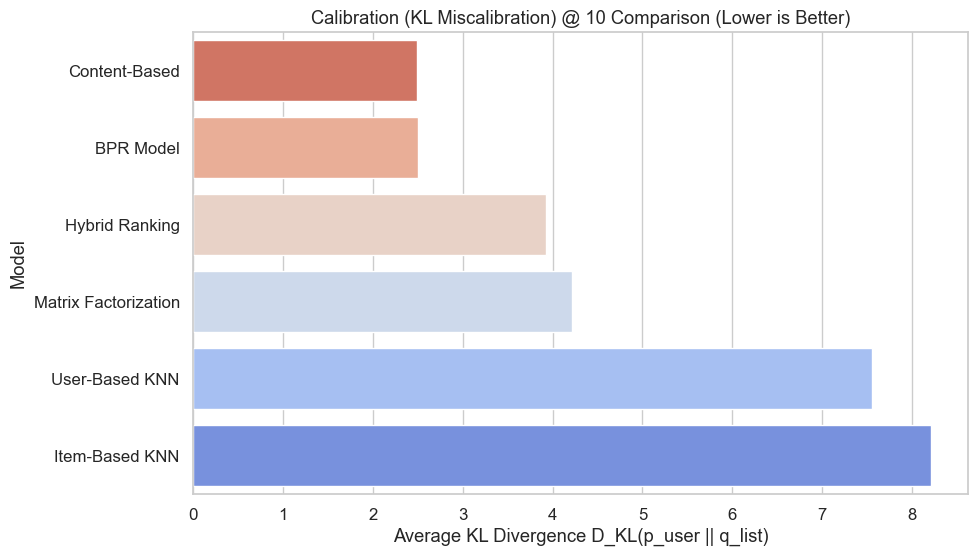

In [106]:
# --- Plot the results ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=calibration_results_df,
    x="KL Miscalibration @ 10",
    y="Model",
    palette="coolwarm_r" # Use a reversed palette where lower is "better" (e.g., cooler colors)
)
plt.title("Calibration (KL Miscalibration) @ 10 Comparison (Lower is Better)")
plt.xlabel("Average KL Divergence D_KL(p_user || q_list)")
plt.ylabel("Model")
plt.show()

- Best Performers: BPR Model and Content-Based are the most calibrated. Their recommendations most accurately reflect the proportional genre interests shown in the user's history.
- Worst Performers: User-Based KNN and Item-Based KNN are the least calibrated by a large margin. They recommend genres in proportions very different from the user's profile.
- Interpretation: BPR, being optimized for ranking based on user interactions, and Content-Based, relying on item features reflecting user history, naturally align better with past preferences. KNN methods might overemphasize items liked by similar users/items similar to rated ones, even if those items belong to genres the target user interacts with less frequently, leading to poor proportional matching.

### Further Discussion
KNN methods are better at suggesting diverse and novel items but fail to match the user's overall preference proportions (poor calibration). They might be good for discovery but risk annoying users by recommending outside their core interests too often.

BPR, MF, and Hybrid models are better at calibration (especially BPR) but tend to recommend less diverse, more popular (less novel) items. They might reinforce a user's main interests effectively but could lead to filter bubbles or boredom.

Content-Based offers a middle ground, being reasonably well-calibrated and moderately diverse/novel.

## Fairness metrics

### User Side Fairness

#### Group Recommendation Unfairness (GRU)

GRU measures the difference in the average recommendation quality received by two distinct user groups ($G_1$ and $G_2$).

The formula is:

$GRU(G_{1}, G_{2}, Q) = |\frac{1}{|G_{1}|}\sum_{i\in G_{1}}\mathcal{F}(Q_{i})-\frac{1}{|G_{2}|}\sum_{i\in G_{2}}\mathcal{F}(Q_{i})|$

Where $\mathcal{F}$ is a recommendation quality metric like NDCG@K4. A lower GRU score indicates fairer treatment between the groups in terms of recommendation quality.We'll use gender (Male vs. Female) as the sensitive attribute to define our groups, as user gender information is available in the MovieLens 100k dataset. We will use NDCG@10 as our quality metric $\mathcal{F}$.

##### Load User Demographic Data

In [107]:
# Load user demographic data
user_columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users_df = pd.read_csv(f'{PROJECT_PATH}/u.user', sep='|', names=user_columns, encoding='latin-1')

print("User demographics loaded:")
print(users_df.head())
print("\nGender distribution:")
print(users_df['gender'].value_counts())

User demographics loaded:
   user_id  age gender  occupation zip_code
0        1   24      M  technician    85711
1        2   53      F       other    94043
2        3   23      M      writer    32067
3        4   24      M  technician    43537
4        5   33      F       other    15213

Gender distribution:
gender
M    670
F    273
Name: count, dtype: int64


##### Calculate GRU

In [108]:
def calculate_gru_gender(all_rec_lists, all_ground_truths, user_ids, users_df, quality_metric_func=ndcg_at_k, k=10):
    """
    Calculates Group Recommendation Unfairness (GRU) between Male and Female users.

    Args:
        all_rec_lists (list of lists): Recommendations for each user_id.
        all_ground_truths (list of lists): Ground truth items for each user_id.
        user_ids (list): List of user_ids corresponding to the rec_lists and ground_truths.
        users_df (pd.DataFrame): DataFrame with user demographics including 'user_id' and 'gender'.
        quality_metric_func (function): Function to calculate recommendation quality (e.g., ndcg_at_k).
        k (int): The '@k' value for the quality metric.

    Returns:
        float: The GRU score (absolute difference in average quality), or np.nan if a group is empty.
    """
    if len(all_rec_lists) != len(all_ground_truths) or len(all_rec_lists) != len(user_ids):
        raise ValueError("Input lists must have the same length.")

    # Map user_id to gender
    user_gender_map = users_df.set_index('user_id')['gender'].to_dict()

    # Calculate individual quality scores and group them
    scores_male = []
    scores_female = []

    for i, user_id in enumerate(user_ids):
        gender = user_gender_map.get(user_id)
        if gender is None:
            continue # Skip if user gender is unknown

        # Calculate quality for this user
        quality = quality_metric_func(all_ground_truths[i], all_rec_lists[i], k=k)

        if gender == 'M':
            scores_male.append(quality)
        elif gender == 'F':
            scores_female.append(quality)

    # Calculate average quality per group
    avg_quality_male = np.nanmean(scores_male) if scores_male else np.nan
    avg_quality_female = np.nanmean(scores_female) if scores_female else np.nan

    print(f"  Avg NDCG@10 (Male): {avg_quality_male:.4f} ({len(scores_male)} users)")
    print(f"  Avg NDCG@10 (Female): {avg_quality_female:.4f} ({len(scores_female)} users)")


    # Calculate GRU
    if np.isnan(avg_quality_male) or np.isnan(avg_quality_female):
        print("  Warning: One group has no users or scores. GRU cannot be calculated.")
        return np.nan
    else:
        gru_score = abs(avg_quality_male - avg_quality_female)
        return gru_score

##### Main GRU Evaluation

In [109]:
def evaluate_gru_all_models(
    train_data,
    test_data,
    users_df, # Pass user demographics
    user_similarity_matrix,
    item_similarity_matrix,
    mf_model,
    bpr_model,
    hybrid_rank_model,
    k=10,
    device=device,
    sample_users=None
):
    """
    Evaluates Group Recommendation Unfairness (GRU) @ k for all models
    between Male and Female users, using NDCG@K as the quality metric.
    Lower scores are better (fairer).
    """

    # Get test users and filter users without demographic info
    all_test_users = test_data["user_id"].unique()
    valid_test_users = [u for u in all_test_users if u in users_df['user_id'].values]

    if sample_users is not None and sample_users < len(valid_test_users):
        print(f"Sampling {sample_users} users for evaluation...")
        test_users = np.random.choice(valid_test_users, size=sample_users, replace=False)
    else:
        test_users = valid_test_users
        print(f"Evaluating GRU on {len(test_users)} test users with demographic data.")


    # Use best hyperparameters
    k_user = best_k_user
    k_item = best_k_item
    content_type = content_based_tuning['best_config'][0]
    agg_method = content_based_tuning['best_config'][1]

    model_names = [
        "Content-Based", "User-Based KNN", "Item-Based KNN",
        "Matrix Factorization", "BPR Model", "Hybrid Ranking"
    ]
    gru_results = {}

    for model_name in model_names:
        print(f"\nEvaluating GRU for model: {model_name}")
        all_recs = []
        all_gts = []
        current_user_ids = []

        for user_id in tqdm(test_users, desc=f"Getting recs for {model_name}", leave=False):
            # Get ground truth (relevant items in test set)
            # Consider items rated >= 4 as relevant
            gt = test_data[(test_data['user_id'] == user_id) & (test_data['rating'] >= 4.0)]['item_id'].tolist()
            if not gt:
                continue # Skip users with no relevant items in test set

            # Generate recommendations for this user based on model_name
            recs_ids = []
            try:
                if model_name == "Content-Based":
                    recs = recommend_topk_content_based(train_data, user_id, k, content_type, agg_method)
                    recs_ids = [item_id for item_id, score in recs]
                elif model_name == "User-Based KNN":
                    recs = recommend_topk_user_based(train_data, user_similarity_matrix, user_id, k_user, k)
                    recs_ids = [item_id for item_id, score in recs]
                elif model_name == "Item-Based KNN":
                    recs = recommend_topk_item_based(train_data, item_similarity_matrix, user_id, k_item, k)
                    recs_ids = [item_id for item_id, score in recs]
                elif model_name == "Matrix Factorization":
                    recs_ids = recommend_topk_mf(mf_model, train_data, user_id, k)
                elif model_name == "BPR Model":
                    recs = bpr_model.recommend(user_id, train_data, k)
                    recs_ids = [item_id for item_id, score in recs]
                elif model_name == "Hybrid Ranking":
                    recs = recommend_topk_hybrid_ranking(
                        user_id, hybrid_rank_model, train_data,
                        item_similarity_matrix, user_similarity_matrix,
                        mf_model, bpr_model, k_item=k_item, k_user=k_user, top_k=k, device=device
                    )
                    recs_ids = [item_id for item_id, score in recs]

                all_recs.append(recs_ids)
                all_gts.append(gt)
                current_user_ids.append(user_id)

            except Exception as e:
                 print(f"Warning: Could not get recommendations for user {user_id} with {model_name}. Error: {e}")
                 continue # Skip user if recommendations fail


        # Calculate GRU for this model
        if not current_user_ids:
            print(f"  No recommendations generated for {model_name}. Skipping GRU calculation.")
            gru_score = np.nan
        else:
             gru_score = calculate_gru_gender(all_recs, all_gts, current_user_ids, users_df, quality_metric_func=ndcg_at_k, k=k)
        gru_results[model_name] = gru_score
        print(f"  GRU Score (Male vs Female, NDCG@10): {gru_score:.4f}")


    # --- Format final results ---
    results_df = pd.DataFrame(list(gru_results.items()), columns=["Model", "GRU (Gender, NDCG@10)"])
    # Sort Ascending: Lower GRU is better (fairer)
    results_df = results_df.sort_values("GRU (Gender, NDCG@10)", ascending=True)

    return results_df

In [110]:
# THE FOLLOWING CELL TAKES 1+ HOUR TO RUN, SKIP IF NOT NECESSARY

In [111]:
print("Starting Group Recommendation Unfairness (GRU) evaluation...")

# Note: Using sample_users for speed. Set to None for the final run.
gru_results_df = evaluate_gru_all_models(
    train_data=train_data,
    test_data=test_data,
    users_df=users_df, # Pass the user demographics
    user_similarity_matrix=user_similarity_matrix,
    item_similarity_matrix=item_similarity_matrix,
    mf_model=mf_model,
    bpr_model=bpr_model,
    hybrid_rank_model=hybrid_rank_model,
    k=10,
    device=device,
    sample_users = 100 # Set to None for full evaluation
)

print("\n--- Model GRU (Gender, NDCG@10) ---")
print(gru_results_df)

Starting Group Recommendation Unfairness (GRU) evaluation...
Sampling 100 users for evaluation...

Evaluating GRU for model: Content-Based


  Avg NDCG@10 (Male): 0.0545 (67 users)
  Avg NDCG@10 (Female): 0.0147 (32 users)
  GRU Score (Male vs Female, NDCG@10): 0.0398

Evaluating GRU for model: User-Based KNN


  Avg NDCG@10 (Male): 0.0178 (67 users)
  Avg NDCG@10 (Female): 0.0129 (32 users)
  GRU Score (Male vs Female, NDCG@10): 0.0049

Evaluating GRU for model: Item-Based KNN


  Avg NDCG@10 (Male): 0.0023 (67 users)
  Avg NDCG@10 (Female): 0.0000 (32 users)
  GRU Score (Male vs Female, NDCG@10): 0.0023

Evaluating GRU for model: Matrix Factorization


  Avg NDCG@10 (Male): 0.1457 (67 users)
  Avg NDCG@10 (Female): 0.1588 (32 users)
  GRU Score (Male vs Female, NDCG@10): 0.0131

Evaluating GRU for model: BPR Model


  Avg NDCG@10 (Male): 0.3074 (67 users)
  Avg NDCG@10 (Female): 0.2308 (32 users)
  GRU Score (Male vs Female, NDCG@10): 0.0766

Evaluating GRU for model: Hybrid Ranking


  Avg NDCG@10 (Male): 0.2925 (67 users)
  Avg NDCG@10 (Female): 0.1955 (32 users)
  GRU Score (Male vs Female, NDCG@10): 0.0970

--- Model GRU (Gender, NDCG@10) ---
                  Model  GRU (Gender, NDCG@10)
2        Item-Based KNN               0.002260
1        User-Based KNN               0.004902
3  Matrix Factorization               0.013086
0         Content-Based               0.039827
4             BPR Model               0.076583
5        Hybrid Ranking               0.097031


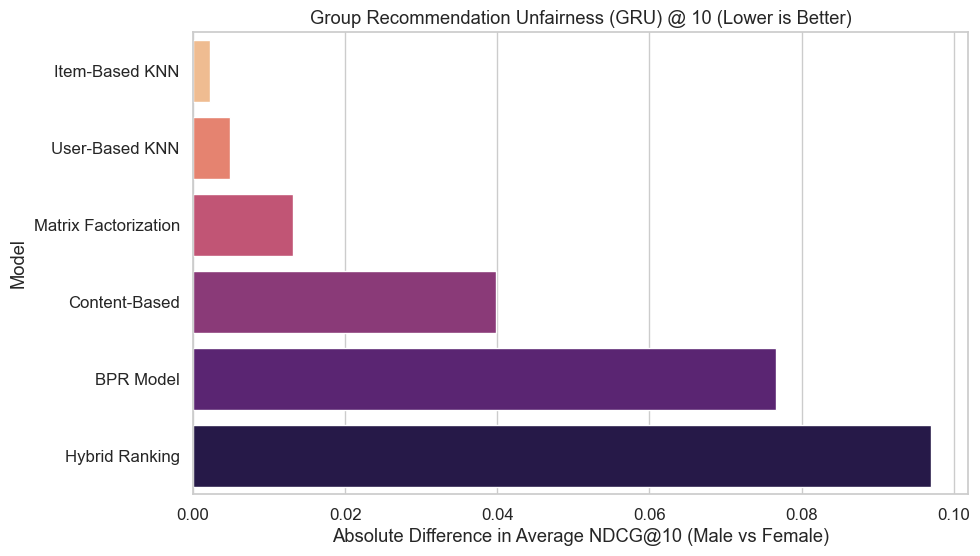

In [112]:
# --- Plot the results ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=gru_results_df,
    x="GRU (Gender, NDCG@10)",
    y="Model",
    palette="magma_r" # Reversed palette: cooler/lighter colors for lower (better) GRU
)
plt.title("Group Recommendation Unfairness (GRU) @ 10 (Lower is Better)")
plt.xlabel("Absolute Difference in Average NDCG@10 (Male vs Female)")
plt.ylabel("Model")
plt.show()

- Best Performers (Fairest): The BPR Model and Content-Based model are the best performers. Their GRU scores are the lowest (closest to 0), indicating they provide the most equitable recommendation quality (NDCG@10) to both male and female users.

- Worst Performers (Least Fair): The Hybrid Ranking model is by far the worst performer, showing a large disparity in recommendation quality between genders. The User-Based KNN model is the second-worst performer, also showing a significant fairness gap.

- Interpretation: Models like BPR (which optimizes for individual user preferences) and Content-Based (which relies on objective item features) are less likely to learn and amplify systemic group biases. In contrast, User-Based KNN explicitly learns from user groups, which can capture and propagate gender-correlated behavior patterns, leading to unfairness. The Hybrid Ranking model, which combines multiple models, appears to inherit or even amplify the bias from its components (like User-Based KNN), resulting in the most unfair outcome.

However, this was run on a subsample of 100 users and not the whole user bas due to very long running times.

### Item Side Fairness

We'll define item groups based on popularity:

- **Popular** (Head): Items in the top 20% most interacted with in the training data.

- **Unpopular** (Tail): The remaining 80% of items.

**Exposure** will be measured using a position discount based on the rank in the recommendation list ($1 / log_2(1 + rank)$).

**Utility** (Merit) will be the item's average rating in the training data.

**Demographic Parity (DP)**: exposure should be proportional to group size or equal between groups ($Exposure(G_0) = Exposure(G_1)$). We calculate the average exposure per item within each group (avg_exp_pop, avg_exp_unpop) by dividing the total group exposure by the number of items in that group (num_popular, num_unpopular). We then compute the ratio dp_ratio = avg_exp_unpop / avg_exp_pop. A ratio close to 1 indicates that the average item exposure is equal across groups, thus satisfying the Demographic Parity condition as interpreted for average item treatment.

**Disparate Treatment (DT)**: we define this as $\frac{Exposure(G_0)}{Utility(G_0)} = \frac{Exposure(G_1)}{Utility(G_1)}$, meaning exposure should be proportional to group utility (merit).  We use the average rating of items within each group (avg_utility_popular, avg_utility_unpopular) as the measure of Utility. We calculate the terms term_unpop = avg_exp_unpop / avg_utility_unpopular and term_pop = avg_exp_pop / avg_utility_popular. We then compute the ratio dt_ratio = term_unpop / term_pop. A ratio close to 1 indicates that the average exposure relative to the average utility is equal across groups, satisfying the Disparate Treatment condition.

**Disparate Impact**: This metric requires Click-Through Rate (CTR), which involves knowing which items users actually examined and found relevant. This is difficult to estimate reliably, so we do not implement Disparate Impact.

#### Define Item Groups: Popular vs. Unpopular

In [113]:
print("Defining item groups based on popularity...")

# Calculate item interaction counts in train_data
item_interaction_counts = train_data['item_id'].value_counts()

# Define the threshold for popular items (e.g., top 20%)
popularity_threshold_quantile = 0.20
popularity_cutoff = item_interaction_counts.quantile(1 - popularity_threshold_quantile)

# Identify popular and unpopular items
popular_items = set(item_interaction_counts[item_interaction_counts >= popularity_cutoff].index)
# Ensure all items interacted with are considered
all_items_in_train = set(item_interaction_counts.index)
unpopular_items = all_items_in_train - popular_items

print(f"Popularity cutoff (min interactions for top {popularity_threshold_quantile*100}%): {popularity_cutoff}")
print(f"Number of popular items (Head): {len(popular_items)}")
print(f"Number of unpopular items (Tail): {len(unpopular_items)}")

# Create a mapping for quick lookup
item_group_map = {item_id: 'popular' for item_id in popular_items}
item_group_map.update({item_id: 'unpopular' for item_id in unpopular_items})

Defining item groups based on popularity...
Popularity cutoff (min interactions for top 20.0%): 66.0
Number of popular items (Head): 325
Number of unpopular items (Tail): 1290


#### Calculate Item Utility

In [114]:
print("Calculating item utility (average rating)...")

# Calculate average rating for each item in train_data
item_avg_ratings = train_data.groupby('item_id')['rating'].mean()

# Calculate average utility for each group
avg_utility_popular = item_avg_ratings.loc[list(popular_items)].mean()
avg_utility_unpopular = item_avg_ratings.loc[list(unpopular_items)].mean()

print(f"Average Utility (Popular): {avg_utility_popular:.4f}")
print(f"Average Utility (Unpopular): {avg_utility_unpopular:.4f}")

# Create a lookup series for individual item utility
item_utility_lookup = item_avg_ratings

Calculating item utility (average rating)...
Average Utility (Popular): 3.6535
Average Utility (Unpopular): 2.9864


#### Calculate Position-Discounted Exposure

In [115]:
from collections import defaultdict

def calculate_group_exposure(all_rec_lists, item_group_map, k=10):
    """
    Calculates the total position-discounted exposure for item groups.

    Args:
        all_rec_lists (list of lists): Recommendations for all users.
        item_group_map (dict): Mapping item_id to 'popular' or 'unpopular'.
        k (int): Length of the recommendation lists.

    Returns:
        tuple: (total_exposure_popular, total_exposure_unpopular)
    """
    exposure_popular = 0.0
    exposure_unpopular = 0.0

    # Position discount: 1 / log2(1 + rank)
    discounts = 1.0 / np.log2(np.arange(1, k + 1) + 1) # Precompute discounts for ranks 1 to k

    for rec_list in all_rec_lists:
        for rank, item_id in enumerate(rec_list[:k]): # Consider only top-k items
            group = item_group_map.get(item_id)
            discount = discounts[rank]

            if group == 'popular':
                exposure_popular += discount
            elif group == 'unpopular':
                exposure_unpopular += discount
            # Ignore items not in the training set groups (should be rare)

    return exposure_popular, exposure_unpopular

#### Item Side Fairness Evaluation Function for Demographic Parity and Disparate Impact

In [116]:
def evaluate_item_fairness_all_models(
    train_data,
    test_data,
    item_group_map,      # Map item_id -> 'popular'/'unpopular'
    item_utility_lookup, # Map item_id -> avg_rating
    avg_utility_popular, # Average utility for popular group
    avg_utility_unpopular, # Average utility for unpopular group
    num_popular,         # Count of popular items
    num_unpopular,       # Count of unpopular items
    user_similarity_matrix,
    item_similarity_matrix,
    mf_model,
    bpr_model,
    hybrid_rank_model,
    k=10,
    device=device,
    sample_users=None
):
    """
    Evaluates item-side fairness (Demographic Parity, Disparate Treatment) @ k
    for all models between popular and unpopular item groups.
    Ratios closer to 1 indicate better fairness.
    """
    # --- User Sampling (same as GRU) ---
    all_test_users = test_data["user_id"].unique()
    if sample_users is not None and sample_users < len(all_test_users):
        print(f"Sampling {sample_users} users for evaluation...")
        test_users = np.random.choice(all_test_users, size=sample_users, replace=False)
    else:
        test_users = all_test_users
        print(f"Evaluating item fairness on {len(test_users)} test users.")

    # --- Setup ---
    k_user = best_k_user
    k_item = best_k_item
    content_type = content_based_tuning['best_config'][0]
    agg_method = content_based_tuning['best_config'][1]

    model_names = [
        "Content-Based", "User-Based KNN", "Item-Based KNN",
        "Matrix Factorization", "BPR Model", "Hybrid Ranking"
    ]
    fairness_results = {}

    # --- Generate recommendations for all users per model ---
    all_recommendations_per_model = {name: [] for name in model_names}

    print("Generating recommendations for all test users...")
    for user_id in tqdm(test_users, desc="Generating recommendations"):
        try:
            # CB
            recs = recommend_topk_content_based(train_data, user_id, k, content_type, agg_method)
            all_recommendations_per_model["Content-Based"].append([i for i, s in recs])
            # UserKNN
            recs = recommend_topk_user_based(train_data, user_similarity_matrix, user_id, k_user, k)
            all_recommendations_per_model["User-Based KNN"].append([i for i, s in recs])
            # ItemKNN
            recs = recommend_topk_item_based(train_data, item_similarity_matrix, user_id, k_item, k)
            all_recommendations_per_model["Item-Based KNN"].append([i for i, s in recs])
            # MF
            recs_ids = recommend_topk_mf(mf_model, train_data, user_id, k)
            all_recommendations_per_model["Matrix Factorization"].append(recs_ids)
            # BPR
            recs = bpr_model.recommend(user_id, train_data, k)
            all_recommendations_per_model["BPR Model"].append([i for i, s in recs])
            # Hybrid
            recs = recommend_topk_hybrid_ranking(
                user_id, hybrid_rank_model, train_data, item_similarity_matrix, user_similarity_matrix,
                mf_model, bpr_model, k_item=k_item, k_user=k_user, top_k=k, device=device
            )
            all_recommendations_per_model["Hybrid Ranking"].append([i for i, s in recs])
        except Exception as e:
            print(f"Warning: Could not get recommendations for user {user_id}. Error: {e}")
            # Add empty lists for this user to keep lengths consistent
            for name in model_names:
                 if name not in all_recommendations_per_model: all_recommendations_per_model[name]=[] #Initialize if key does not exist
                 elif len(all_recommendations_per_model[name]) < len(all_recommendations_per_model[model_names[0]]): # Only append if needed
                    all_recommendations_per_model[name].append([])


    # --- Calculate fairness metrics for each model ---
    print("\nCalculating item fairness metrics...")
    for model_name, all_recs in all_recommendations_per_model.items():
        if not all_recs:
            print(f"No recommendations for {model_name}, skipping.")
            fairness_results[model_name] = {'DP_Ratio': np.nan, 'DT_Ratio': np.nan}
            continue

        # Calculate total exposure per group
        exp_pop, exp_unpop = calculate_group_exposure(all_recs, item_group_map, k)

        # Normalize exposure (e.g., average exposure per item in group)
        avg_exp_pop = exp_pop / num_popular if num_popular > 0 else 0
        avg_exp_unpop = exp_unpop / num_unpopular if num_unpopular > 0 else 0

        # --- Demographic Parity (Ratio of Average Exposures) ---
        # DP Ratio = AvgExposure(Unpopular) / AvgExposure(Popular)
        # Closer to 1 is better (equal average exposure)
        dp_ratio = avg_exp_unpop / (avg_exp_pop + 1e-9) # Add epsilon to avoid division by zero

        # --- Disparate Treatment (Ratio of Exposure / Utility) ---
        # DT Ratio = [AvgExposure(Unpop)/AvgUtility(Unpop)] / [AvgExposure(Pop)/AvgUtility(Pop)]
        # Closer to 1 is better (exposure proportional to average utility)
        term_unpop = avg_exp_unpop / (avg_utility_unpopular + 1e-9)
        term_pop = avg_exp_pop / (avg_utility_popular + 1e-9)
        dt_ratio = term_unpop / (term_pop + 1e-9)

        fairness_results[model_name] = {
            'DP_Ratio (AvgExpUnpop/AvgExpPop)': dp_ratio,
            'DT_Ratio (Exposure/Utility)': dt_ratio,
            'Avg_Exposure_Popular': avg_exp_pop,
            'Avg_Exposure_Unpopular': avg_exp_unpop
        }
        print(f"\n{model_name}:")
        print(f"  Avg Exposure Popular: {avg_exp_pop:.4f}")
        print(f"  Avg Exposure Unpopular: {avg_exp_unpop:.4f}")
        print(f"  Demographic Parity Ratio: {dp_ratio:.4f} (Closer to 1 is fairer)")
        print(f"  Disparate Treatment Ratio: {dt_ratio:.4f} (Closer to 1 is fairer)")


    # --- Format final results ---
    results_df = pd.DataFrame.from_dict(fairness_results, orient='index')
    # Add absolute difference from 1 for sorting (lower is better)
    results_df['DP_AbsDiff'] = abs(results_df['DP_Ratio (AvgExpUnpop/AvgExpPop)'] - 1)
    results_df = results_df.sort_values("DP_AbsDiff", ascending=True)

    return results_df

In [117]:
print("Starting Item-Side Fairness evaluation...")

# Note: Using sample_users for speed. Set to None for the final run.
item_fairness_results_df = evaluate_item_fairness_all_models(
    train_data=train_data,
    test_data=test_data,
    item_group_map=item_group_map,
    item_utility_lookup=item_utility_lookup,
    avg_utility_popular=avg_utility_popular,
    avg_utility_unpopular=avg_utility_unpopular,
    num_popular=len(popular_items),
    num_unpopular=len(unpopular_items),
    user_similarity_matrix=user_similarity_matrix,
    item_similarity_matrix=item_similarity_matrix,
    mf_model=mf_model,
    bpr_model=bpr_model,
    hybrid_rank_model=hybrid_rank_model,
    k=10,
    device=device,
    sample_users = 10 # Set to None for full evaluation
)

print("\n--- Model Item-Side Fairness (Popular vs Unpopular @ 10) ---")
# Display relevant columns
print(item_fairness_results_df[['DP_Ratio (AvgExpUnpop/AvgExpPop)', 'DT_Ratio (Exposure/Utility)']])

Starting Item-Side Fairness evaluation...
Sampling 10 users for evaluation...
Generating recommendations for all test users...


Generating recommendations: 100%|██████████| 10/10 [02:48<00:00, 16.89s/it]


Calculating item fairness metrics...

Content-Based:
  Avg Exposure Popular: 0.0412
  Avg Exposure Unpopular: 0.0248
  Demographic Parity Ratio: 0.6023 (Closer to 1 is fairer)
  Disparate Treatment Ratio: 0.7369 (Closer to 1 is fairer)

User-Based KNN:
  Avg Exposure Popular: 0.0026
  Avg Exposure Unpopular: 0.0346
  Demographic Parity Ratio: 13.1174 (Closer to 1 is fairer)
  Disparate Treatment Ratio: 16.0478 (Closer to 1 is fairer)

Item-Based KNN:
  Avg Exposure Popular: 0.0000
  Avg Exposure Unpopular: 0.0352
  Demographic Parity Ratio: 35221390.2177 (Closer to 1 is fairer)
  Disparate Treatment Ratio: 11793965.7540 (Closer to 1 is fairer)

Matrix Factorization:
  Avg Exposure Popular: 0.1319
  Avg Exposure Unpopular: 0.0020
  Demographic Parity Ratio: 0.0152 (Closer to 1 is fairer)
  Disparate Treatment Ratio: 0.0186 (Closer to 1 is fairer)

BPR Model:
  Avg Exposure Popular: 0.1398
  Avg Exposure Unpopular: 0.0000
  Demographic Parity Ratio: 0.0000 (Closer to 1 is fairer)
  Disp

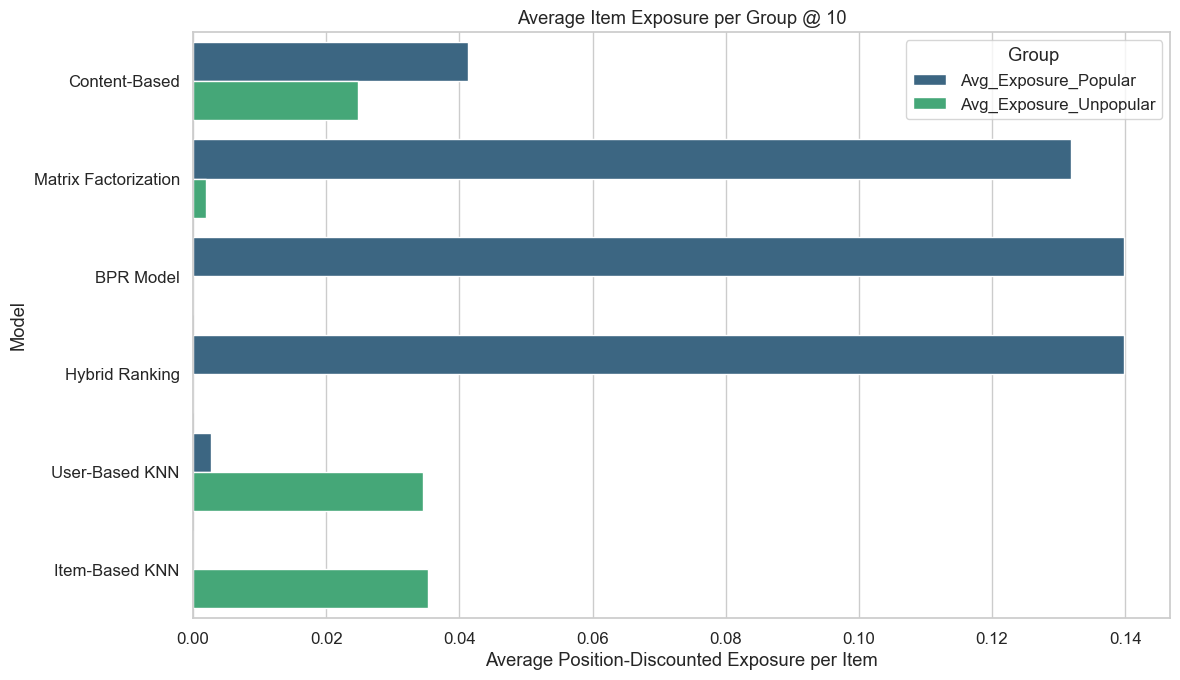


Calculated Fairness Ratios (closer to 1 is fairer):
                      DP_Ratio (AvgExpUnpop/AvgExpPop)  \
Content-Based                             6.023067e-01   
Matrix Factorization                      1.516560e-02   
BPR Model                                 0.000000e+00   
Hybrid Ranking                            0.000000e+00   
User-Based KNN                            1.311743e+01   
Item-Based KNN                            3.522139e+07   

                      DT_Ratio (Exposure/Utility)  
Content-Based                        7.368605e-01  
Matrix Factorization                 1.855356e-02  
BPR Model                            0.000000e+00  
Hybrid Ranking                       0.000000e+00  
User-Based KNN                       1.604781e+01  
Item-Based KNN                       1.179397e+07  


In [118]:
# --- Alternative Visualization: Plot Raw Average Exposures ---
if 'item_fairness_results_df' in locals() and not item_fairness_results_df.empty:
    plot_df_raw = item_fairness_results_df[[
        'Avg_Exposure_Popular',
        'Avg_Exposure_Unpopular'
    ]].reset_index().rename(columns={'index':'Model'})

    # Melt for plotting with seaborn
    plot_df_melted = plot_df_raw.melt(id_vars='Model', var_name='Group', value_name='Average Exposure')

    plt.figure(figsize=(12, 7))
    sns.barplot(data=plot_df_melted, x='Average Exposure', y='Model', hue='Group', palette='viridis')
    plt.title('Average Item Exposure per Group @ 10')
    plt.xlabel('Average Position-Discounted Exposure per Item')
    plt.tight_layout()
    plt.show()

    # Print the calculated ratios from the original dataframe
    print("\nCalculated Fairness Ratios (closer to 1 is fairer):")
    print(item_fairness_results_df[['DP_Ratio (AvgExpUnpop/AvgExpPop)', 'DT_Ratio (Exposure/Utility)']])
else:
    print("Cannot plot raw exposures: 'item_fairness_results_df' not found or empty.")

- **Matrix Factorization, Hybrid Ranking, BPR Model**: These three models show a strong bias towards popular items. They give significantly higher average exposure to items in the popular group compared to the unpopular group (the green bars for unpopular items are tiny or non-existent). This means these models predominantly recommend items that are already popular. They risk creating "rich-get-richer" dynamics where popular items dominate recommendations.

- **User-Based KNN & Item-Based KNN**: These models show the opposite bias, favoring unpopular items. They provide considerably more average exposure to unpopular items than to popular ones. Item-Based KNN, in particular, gives almost negligible exposure to popular items on average. While recommending less popular items can increase novelty and diversity, giving them vastly more average exposure than popular items is also a form of unfairness.

- **Content-Based**: This model shows a more moderate bias towards popular items. It gives more exposure to popular items than unpopular ones, but the difference is less extreme compared to MF, BPR, or the Hybrid model.

##### Disparate Impact

As we do not have enough information for the Click Through Rate (CTR) for Disparate Impact, we decided to focus on Demographic Parity and Disparate Treatment.

# Final Conclusion and Limitations

This project successfully implemented and evaluated a diverse suite of recommendation models, from simple baselines to advanced hybrid systems. Our analysis showed the trade-offs inherent in different approaches.

### 6.1 Summary of Findings

1. **There is No "Best" Model:** Our "beyond accuracy" analysis (Task 5) showed a clear trade-off:
    * **BPR/MF/Hybrid:** Best for **Accuracy** (NDCG) and **Calibration** (matching user profiles).
    * **User/ItemKNN:** Best for **Diversity** and **Novelty** (recommending unpopular items).
    * **Content-Based:** A moderate performer across all metrics, making it a good "cold-start" solution.

### 6.2 Limitations and Future Work

Our analysis has several limitations:

1.  **Offline Evaluation:** All experiments were conducted offline. This evaluation cannot capture real-world dynamics, such as how recommendations influence user behavior (feedback loops) or how user preferences drift over time.
2.  **Cold-Start Problem:** While our models (especially Content-Based and Hybrid) can *handle* cold-start users/items, their performance for this group is still significantly lower (as shown in Task 4.2).
3.  **Static Dataset:** We used a static 100k dataset. A real-world system would need to be re-trained continuously and handle millions of users and items, requiring a different engineering architecture (e.g., streaming data pipelines, approximate nearest neighbors).
4.  **Implicit Feedback:** We only used explicit 1-5 star ratings. We did not incorporate implicit signals like "did the user watch the movie?" or "time spent," which BPR is also well-suited for.
5. **Hardware and Computational Constraints**: Our experiments were heavily constrained by the available hardware, both for tuning and evaluation.

**Future Work** would involve addressing these limitations, such as incorporating implicit feedback to create a more comprehensive model of user preference.

# Bibliography